# Default Parameter

Import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, roc_curve, auc
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import time

Summary Data

In [8]:
file_path = r'D:\TA_baru\dataset\all_label_extracted_features.xlsx'  # Adjust to your file path
df = pd.read_excel(file_path)

print(f"Dataset loaded: {df.shape[0]} samples with {df.shape[1]} columns")

# Check the first few rows to confirm data structure
print("\nData preview:")
print(df.head())

# Check for label distribution
print("\nLabel distribution:")
print(df["label"].value_counts())

Dataset loaded: 61004 samples with 51 columns

Data preview:
                      segment_id     label  rr_interval  lead1_st_segment  \
0  patient002_s0015lre.npy_beat0  anterior          NaN               NaN   
1  patient002_s0015lre.npy_beat1  anterior     470.0000           -0.0016   
2  patient002_s0015lre.npy_beat2  anterior     727.0000           -0.0017   
3  patient002_s0015lre.npy_beat3  anterior     725.0000           -0.0018   
4  patient002_s0015lre.npy_beat4  anterior     712.0000           -0.0009   

   lead1_qr_interval  lead1_q_amplitude  lead1_r_amplitude  lead2_st_segment  \
0                350            -0.0034             0.0103            0.0017   
1                 36            -0.0017             0.0149            0.0058   
2                 38            -0.0024             0.0162            0.0060   
3                 36            -0.0023             0.0158            0.0070   
4                 33            -0.0019             0.0155            0.0060

LightGBM Default

In [26]:

def ensemble_boosting_classification(df):
    # Prepare data
    X = df.drop(columns=["segment_id", "label"])
    y = df["label"]

    # Handle missing values
    X = X.fillna(0)

    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded = train_test_split(
        X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    # Dictionary to store all results
    results = {
        'models': {},
        'predictions': {},
        'metrics': {}
    }
    
    # LightGBM Classification
    print("\n=== LightGBM Classification with 5-Fold Cross-Validation ===")
    # Modified to include test data as parameters 
    lgb_model, lgb_metrics, cv_results = train_lightgbm_with_cv(
        X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, le
    )
    
    results['models']['lightgbm'] = lgb_model
    results['metrics']['lightgbm'] = lgb_metrics
    results['cv_results'] = cv_results
    
    # Calculate and display class-wise metrics
    calculate_class_wise_metrics(results['cv_results'], le)
    
    # Plot confusion matrix for best Model on CV Fold
    plot_cv_results(cv_results, le)

    # Plot confusion matrix for final model on test data
    plot_final_confusion_matrix(y_test_encoded, results['metrics']['lightgbm']['predictions'], le)
    
    # Calculate class-wise metrics for test data
    calculate_test_class_wise_metrics(y_test_encoded, results['metrics']['lightgbm']['predictions'], le)
    
    return results

def train_lightgbm_with_cv(X_train, y_train, X_test, y_test, label_encoder):
    # Get number of unique classes
    num_classes = len(np.unique(y_train))
    
    # Initialize the cross-validation splitter
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Using default parameters for LightGBM
    lgb_params = {
        'objective': 'multiclass',
        'num_class': num_classes,
        'metric': 'multi_logloss',  # Added for tracking loss
        'verbose': -1               # Suppress verbose output
    }
    
    # Perform cross-validation and store results
    cv_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrices': [],
        'fold_models': [],
        'fold_predictions': [],
        'fold_probabilities': [],
        'y_true': [],  
        'y_pred': [],  
        'class_reports': [],
        'train_accuracy': [], # Track training accuracy for each fold
        'val_accuracy': [],   # Track validation accuracy for each fold
        'train_loss': [],     # Track training loss for each fold
        'val_loss': [],       # Track validation loss for each fold
        'best_fold_history': None # Will store training history for best fold
    }
    
    print("\nPerforming 5-fold cross-validation on training data:")
    fold_num = 1
    best_fold = 0
    best_accuracy = 0
    best_fold_model = None
    
    # Track start time for entire training process
    start_time = time.time()
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
        
        # Create LightGBM datasets for training with callback support
        train_data = lgb.Dataset(X_fold_train, label=y_fold_train)
        valid_data = lgb.Dataset(X_fold_val, label=y_fold_val, reference=train_data)
        
        # Dictionary to store training history
        history = {
            'train_accuracy': [],
            'val_accuracy': [],
            'train_loss': [],
            'val_loss': []
        }
        
        # Callback function to collect metrics during training
        def callback(env):
            # Get current iteration metrics
            train_loss = env.evaluation_result_list[0][2]
            val_loss = env.evaluation_result_list[1][2]
            
            # Calculate accuracy on training data (using the current booster)
            train_preds = np.argmax(env.model.predict(X_fold_train), axis=1)
            train_acc = accuracy_score(y_fold_train, train_preds)
            
            # Calculate accuracy on validation data
            val_preds = np.argmax(env.model.predict(X_fold_val), axis=1)
            val_acc = accuracy_score(y_fold_val, val_preds)
            
            # Store metrics
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['train_accuracy'].append(train_acc)
            history['val_accuracy'].append(val_acc)
            
            return False  # Return False to continue training
        
        # Train the model on this fold with callbacks
        fold_model = lgb.train(
            lgb_params,
            train_data,
            num_boost_round=100,  # number of boosting iterations
            valid_sets=[train_data, valid_data],
            valid_names=['training', 'validation'],
            callbacks=[lgb.log_evaluation(period=100), callback]
        )
        
        # Evaluate on training set using the booster
        y_train_prob = fold_model.predict(X_fold_train)
        train_pred = np.argmax(y_train_prob, axis=1)
        train_accuracy = accuracy_score(y_fold_train, train_pred)
        cv_results['train_accuracy'].append(train_accuracy)
        
        # Prediction on Validation set using the booster
        y_val_prob = fold_model.predict(X_fold_val)
        y_pred = np.argmax(y_val_prob, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_fold_val, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_fold_val, y_pred, average='weighted')
        cm = confusion_matrix(y_fold_val, y_pred)
        
        # Store validation accuracy
        cv_results['val_accuracy'].append(accuracy)
        
        # Store validation and training loss (take the last values)
        cv_results['train_loss'].append(history['train_loss'][-1])
        cv_results['val_loss'].append(history['val_loss'][-1])
        
        # Store classification report as a dictionary
        class_report = classification_report(y_fold_val, y_pred, output_dict=True)
        
        # Store results for this fold
        cv_results['accuracy'].append(accuracy)
        cv_results['precision'].append(precision)
        cv_results['recall'].append(recall)
        cv_results['f1'].append(f1)
        cv_results['conf_matrices'].append(cm)
        cv_results['fold_models'].append(fold_model)  # Simpan booster langsung
        cv_results['fold_predictions'].append(y_pred)
        cv_results['fold_probabilities'].append(y_val_prob)
        cv_results['y_true'].append(y_fold_val)
        cv_results['y_pred'].append(y_pred)
        cv_results['class_reports'].append(class_report)
        
        # Track the best fold based on validation accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_fold = fold_num - 1  # Using 0-based indexing for arrays
            # Store training history for the best fold
            cv_results['best_fold_history'] = history
            best_fold_model = fold_model
        
        # Show results with 4 decimal places
        print(f"Fold {fold_num}: Train Accuracy={train_accuracy:.4f}, Val Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")
        fold_num += 1
    
    # Calculate mean and std of all metrics across folds
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        mean_val = np.mean(cv_results[metric])
        std_val = np.std(cv_results[metric])
        print(f"Mean {metric}: {mean_val:.4f} (±{std_val:.4f})")
    
    # Use the best fold model for final evaluation
    print(f"\nBest model found in fold {best_fold + 1} with validation accuracy of {best_accuracy:.4f}")
    final_model = best_fold_model 
    # Evaluate the best fold model on the test set
    test_prob = final_model.predict(X_test)  
    test_pred = np.argmax(test_prob, axis=1)  
    
    # Calculate final metrics on test set
    training_time = time.time() - start_time
    metrics = evaluate_classifier(y_test, test_pred, test_prob, label_encoder, training_time)
    
    # Add predictions to metrics for confusion matrix plotting
    metrics['predictions'] = test_pred
    
    # Display test set results
    print(f"\nFinal Training Time: {training_time:.4f} seconds")
    print("\nFinal model evaluation on test set (20% of data):")
    print(classification_report(y_test, test_pred, target_names=label_encoder.classes_, digits=4))
    
    # Plot accuracy and loss for the best fold
    plot_accuracy_loss_curves(cv_results['best_fold_history'], best_fold)
    
    return final_model, metrics, cv_results

def evaluate_classifier(y_true, y_pred, y_prob, label_encoder, training_time=None):
    """Evaluate classifier performance"""
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create metrics dictionary
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'training_time': training_time,
        # Add class-wise metrics
        'class_report': classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)
    }
    
    return metrics

def plot_cv_results(cv_results, label_encoder):
    
    # Get class names
    class_names = label_encoder.classes_

    # ADDITION: Plot the best fold's confusion matrix
    best_fold = np.argmax(cv_results['accuracy'])
    best_cm = cv_results['conf_matrices'][best_fold]
    plt.figure(figsize=(10, 8))
    sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.tick_params(axis='both', which='major', labelsize=22)
    plt.title(f'Best Fold (Fold {best_fold + 1}) Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('best_fold_CM_LightGBM.png')

def plot_final_confusion_matrix(y_true, y_pred, label_encoder):
    """Plot confusion matrix for final model evaluation on test data"""
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Get class names
    class_names = label_encoder.classes_
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title('Confusion Matrix - Final Model on Test Data')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('final_model_CM_LightGBM.png')
    plt.show()
    
    # Calculate and display normalized confusion matrix (percentage)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title('Normalized Confusion Matrix - Final Model on Test Data')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    
    # Print additional information
    print("\nConfusion Matrix Analysis:")
    for i, class_name in enumerate(class_names):
        true_positive = cm[i, i]
        total_actual = np.sum(cm[i, :])
        total_predicted = np.sum(cm[:, i])
        print(f"\nClass: {class_name}")
        print(f"True Positive: {true_positive}")
        print(f"Total Actual: {total_actual}")
        print(f"Total Predicted as {class_name}: {total_predicted}")
        if total_actual > 0:
            print(f"Recall (Sensitivity): {true_positive/total_actual:.4f}")
        if total_predicted > 0:
            print(f"Precision: {true_positive/total_predicted:.4f}")

def plot_accuracy_loss_curves(history, best_fold):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot accuracy
    ax1.plot(history['train_accuracy'], label='Training Accuracy', marker='o')
    ax1.plot(history['val_accuracy'], label='Validation Accuracy', marker='o')
    ax1.set_title(f'Model Accuracy - Best Fold ({best_fold + 1})',  fontsize=26)
    ax1.set_xlabel('Iteration', fontsize=26)
    ax1.set_ylabel('Accuracy', fontsize=26)
    ax1.legend(fontsize=26)
    ax1.tick_params(axis='both', which='major', labelsize=22)
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history['train_loss'], label='Training Loss', marker='o')
    ax2.plot(history['val_loss'], label='Validation Loss', marker='o')
    ax2.set_title(f'Model Loss - Best Fold ({best_fold + 1})',  fontsize=26)
    ax2.set_xlabel('Iteration', fontsize=26)
    ax2.set_ylabel('Loss', fontsize=26)
    ax2.legend(fontsize=26)
    ax2.tick_params(axis='both', which='major', labelsize=22)
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('best_fold_accuracy_loss_curves_LightGBM.png', dpi=300)
    plt.show()
    
    # Print final metrics for best fold
    print(f"\nBest Fold ({best_fold + 1}) Final Metrics:")
    print(f"Training Accuracy: {history['train_accuracy'][-1]:.4f}")
    print(f"Validation Accuracy: {history['val_accuracy'][-1]:.4f}")
    print(f"Training Loss: {history['train_loss'][-1]:.4f}")
    print(f"Validation Loss: {history['val_loss'][-1]:.4f}")
    
    # Calculate improvements
    first_train_acc = history['train_accuracy'][0]
    last_train_acc = history['train_accuracy'][-1]
    train_acc_improvement = last_train_acc - first_train_acc
    
    first_val_acc = history['val_accuracy'][0]
    last_val_acc = history['val_accuracy'][-1]
    val_acc_improvement = last_val_acc - first_val_acc
    
    first_train_loss = history['train_loss'][0]
    last_train_loss = history['train_loss'][-1]
    train_loss_reduction = first_train_loss - last_train_loss
    
    first_val_loss = history['val_loss'][0]
    last_val_loss = history['val_loss'][-1]
    val_loss_reduction = first_val_loss - last_val_loss
    
    print("\nImprovements:")
    print(f"Training Accuracy Improvement: {train_acc_improvement:.4f} ({train_acc_improvement/first_train_acc*100:.2f}%)")
    print(f"Validation Accuracy Improvement: {val_acc_improvement:.4f} ({val_acc_improvement/first_val_acc*100:.2f}%)")
    print(f"Training Loss Reduction: {train_loss_reduction:.4f} ({train_loss_reduction/first_train_loss*100:.2f}%)")
    print(f"Validation Loss Reduction: {val_loss_reduction:.4f} ({val_loss_reduction/first_val_loss*100:.2f}%)")

def calculate_class_wise_metrics(cv_results, label_encoder):
    print("\n====== Class-Wise Metrics Across CV Folds ======")
    
    # Concatenate results from all folds
    all_y_true = np.concatenate([y for y in cv_results['y_true']])
    all_y_pred = np.concatenate([y for y in cv_results['y_pred']])
    
    # Calculate per-class metrics across all folds
    class_report = classification_report(all_y_true, all_y_pred, 
                                         target_names=label_encoder.classes_, 
                                         output_dict=True)
    
    # Create DataFrame for better formatting
    classes = label_encoder.classes_
    class_metrics = pd.DataFrame({
        'Class': classes,
        'Precision': [class_report[c]['precision'] for c in classes],
        'Recall/Sensitivity': [class_report[c]['recall'] for c in classes],
        'F1-Score': [class_report[c]['f1-score'] for c in classes],
        'Support': [class_report[c]['support'] for c in classes]
    })
    
    # Add per-class accuracy
    accuracies = []
    for i, class_name in enumerate(classes):
        # For each class, accuracy is:
        # (true positives + true negatives) / (total samples)
        true_class = (all_y_true == i)
        pred_class = (all_y_pred == i)
        
        tp = np.sum(true_class & pred_class)  # True positives
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        total = len(all_y_true)
        
        accuracy = (tp + tn) / total
        accuracies.append(accuracy)
    
    class_metrics['Accuracy'] = accuracies
    
    # Add specificity (true negative rate)
    specificities = []
    for i, class_name in enumerate(classes):
        true_class = (all_y_true == i)  
        pred_class = (all_y_pred == i)
        
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        fp = np.sum(~true_class & pred_class)   # False positives
        
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificities.append(specificity)
    
    class_metrics['Specificity'] = specificities
    
    # Calculate per-fold metrics for each class
    fold_metrics = []
    for fold in range(len(cv_results['y_true'])):
        fold_y_true = cv_results['y_true'][fold]
        fold_y_pred = cv_results['y_pred'][fold]
        
        # Get classification report for this fold
        fold_report = classification_report(fold_y_true, fold_y_pred, 
                                           target_names=label_encoder.classes_,
                                           output_dict=True)
        
        # Extract class metrics
        for i, class_name in enumerate(classes):
            # Calculate class accuracy for this fold
            true_class = (fold_y_true == i)
            pred_class = (fold_y_pred == i)
            
            tp = np.sum(true_class & pred_class)  # True positives
            tn = np.sum(~true_class & ~pred_class)  # True negatives
            total = len(fold_y_true)
            
            accuracy = (tp + tn) / total
            
            # Calculate specificity
            tn = np.sum(~true_class & ~pred_class)  # True negatives
            fp = np.sum(~true_class & pred_class)   # False positives
            
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            
            fold_metrics.append({
                'Fold': fold + 1,
                'Class': class_name,
                'Precision': fold_report[class_name]['precision'],
                'Recall/Sensitivity': fold_report[class_name]['recall'], 
                'F1-Score': fold_report[class_name]['f1-score'],
                'Support': fold_report[class_name]['support'],
                'Accuracy': accuracy,
                'Specificity': specificity
            })
    
    # Create DataFrame with all fold results
    fold_df = pd.DataFrame(fold_metrics)
    
    # Display average metrics across all folds with 4 decimal places
    pd.set_option('display.float_format', '{:.4f}'.format)
    print("Per-Class Metrics Averaged Across All CV Folds:")
    print(class_metrics)
    
    # Save to CSV
    class_metrics.to_csv('class_wise_metrics_cv_LightGBM.csv', index=False)
    fold_df.to_csv('class_wise_metrics_by_fold_LightGBM.csv', index=False)
    
    # Display detailed results for each class by fold
    for class_name in classes:
        print(f"\nDetailed metrics for class '{class_name}' across folds:")
        class_fold_data = fold_df[fold_df['Class'] == class_name]
        
        # Calculate mean and std for each metric
        metrics_summary = {}
        for metric in ['Precision', 'Recall/Sensitivity', 'F1-Score', 'Accuracy', 'Specificity']:
            mean_val = class_fold_data[metric].mean()
            std_val = class_fold_data[metric].std()
            metrics_summary[metric] = f"{mean_val:.4f} (±{std_val:.4f})"
        
        # Print summary
        for metric, value in metrics_summary.items():
            print(f"{metric}: {value}")

def calculate_test_class_wise_metrics(y_true, y_pred, label_encoder):
    """Calculate detailed class-wise metrics for test data"""
    print("\n====== Class-Wise Metrics on Test Data ======")
    
    # Calculate per-class metrics on test data
    class_report = classification_report(y_true, y_pred, 
                                        target_names=label_encoder.classes_, 
                                        output_dict=True)
    
    # Create DataFrame for better formatting
    classes = label_encoder.classes_
    test_class_metrics = pd.DataFrame({
        'Class': classes,
        'Precision': [class_report[c]['precision'] for c in classes],
        'Recall/Sensitivity': [class_report[c]['recall'] for c in classes],
        'F1-Score': [class_report[c]['f1-score'] for c in classes],
        'Support': [class_report[c]['support'] for c in classes]
    })
    
    # Add per-class accuracy
    accuracies = []
    for i, class_name in enumerate(classes):
        # For each class, accuracy is:
        # (true positives + true negatives) / (total samples)
        true_class = (y_true == i)
        pred_class = (y_pred == i)
        
        tp = np.sum(true_class & pred_class)  # True positives
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        total = len(y_true)
        
        accuracy = (tp + tn) / total
        accuracies.append(accuracy)
    
    test_class_metrics['Accuracy'] = accuracies
    
    # Add specificity (true negative rate)
    specificities = []
    for i, class_name in enumerate(classes):
        true_class = (y_true == i)  
        pred_class = (y_pred == i)
        
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        fp = np.sum(~true_class & pred_class)   # False positives
        
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificities.append(specificity)
    
    test_class_metrics['Specificity'] = specificities
    
    # Calculate additional useful metrics for each class
    npvs = []  # Negative Predictive Values
    balanced_accuracies = []  # Balanced Accuracy (mean of sensitivity and specificity)
    
    for i, class_name in enumerate(classes):
        true_class = (y_true == i)
        pred_class = (y_pred == i)
        
        tp = np.sum(true_class & pred_class)  # True positives
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        fp = np.sum(~true_class & pred_class)  # False positives
        fn = np.sum(true_class & ~pred_class)  # False negatives
        
        # Negative Predictive Value = TN / (TN + FN)
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        npvs.append(npv)
        
        # Sensitivity (Recall)
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        # Specificity (already calculated)
        specificity = specificities[i]
        
        # Balanced Accuracy
        bal_acc = (sensitivity + specificity) / 2
        balanced_accuracies.append(bal_acc)
    
    test_class_metrics['NPV'] = npvs
    test_class_metrics['Balanced_Accuracy'] = balanced_accuracies
    
    # Display test metrics with 4 decimal places
    pd.set_option('display.float_format', '{:.4f}'.format)
    print("Per-Class Metrics on Test Data:")
    print(test_class_metrics)
    
    # Save to CSV
    test_class_metrics.to_csv('test_class_wise_metrics_LightGBM.csv', index=False)
    
    # Calculate and print overall metrics on test set
    print("\nOverall Test Metrics:")
    overall_accuracy = accuracy_score(y_true, y_pred)
    overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted'
    )
    print(f"Accuracy: {overall_accuracy:.4f}")
    print(f"Weighted Precision: {overall_precision:.4f}")
    print(f"Weighted Recall: {overall_recall:.4f}")
    print(f"Weighted F1-Score: {overall_f1:.4f}")
    
    # Additional diagnostics for each class
    print("\nDetailed Per-Class Analysis on Test Set:")
    for i, class_name in enumerate(classes):
        true_class = (y_true == i)
        pred_class = (y_pred == i)
        
        tp = np.sum(true_class & pred_class)  # True positives
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        fp = np.sum(~true_class & pred_class)  # False positives
        fn = np.sum(true_class & ~pred_class)  # False negatives
        
        print(f"\nClass: {class_name}")
        print(f"True Positives: {tp}")
        print(f"False Positives: {fp}")
        print(f"True Negatives: {tn}")
        print(f"False Negatives: {fn}")
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"Precision: {precision:.4f}")
        print(f"Recall/Sensitivity: {recall:.4f}")
        print(f"Specificity: {specificity:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1-Score: {f1:.4f}")
        
    return test_class_metrics


=== LightGBM Classification with 5-Fold Cross-Validation ===

Performing 5-fold cross-validation on training data:
[100]	training's multi_logloss: 3.6878e-05	validation's multi_logloss: 0.0116372
Fold 1: Train Accuracy=1.0000, Val Accuracy=0.9978, Precision=0.9979, Recall=0.9978, F1=0.9978
[100]	training's multi_logloss: 3.92051e-05	validation's multi_logloss: 0.015519
Fold 2: Train Accuracy=1.0000, Val Accuracy=0.9981, Precision=0.9981, Recall=0.9981, F1=0.9981
[100]	training's multi_logloss: 3.84689e-05	validation's multi_logloss: 0.00851769
Fold 3: Train Accuracy=1.0000, Val Accuracy=0.9980, Precision=0.9980, Recall=0.9980, F1=0.9979
[100]	training's multi_logloss: 3.64393e-05	validation's multi_logloss: 0.00873962
Fold 4: Train Accuracy=1.0000, Val Accuracy=0.9974, Precision=0.9974, Recall=0.9974, F1=0.9974
[100]	training's multi_logloss: 3.94004e-05	validation's multi_logloss: 0.00609883
Fold 5: Train Accuracy=1.0000, Val Accuracy=0.9983, Precision=0.9983, Recall=0.9983, F1=0.998

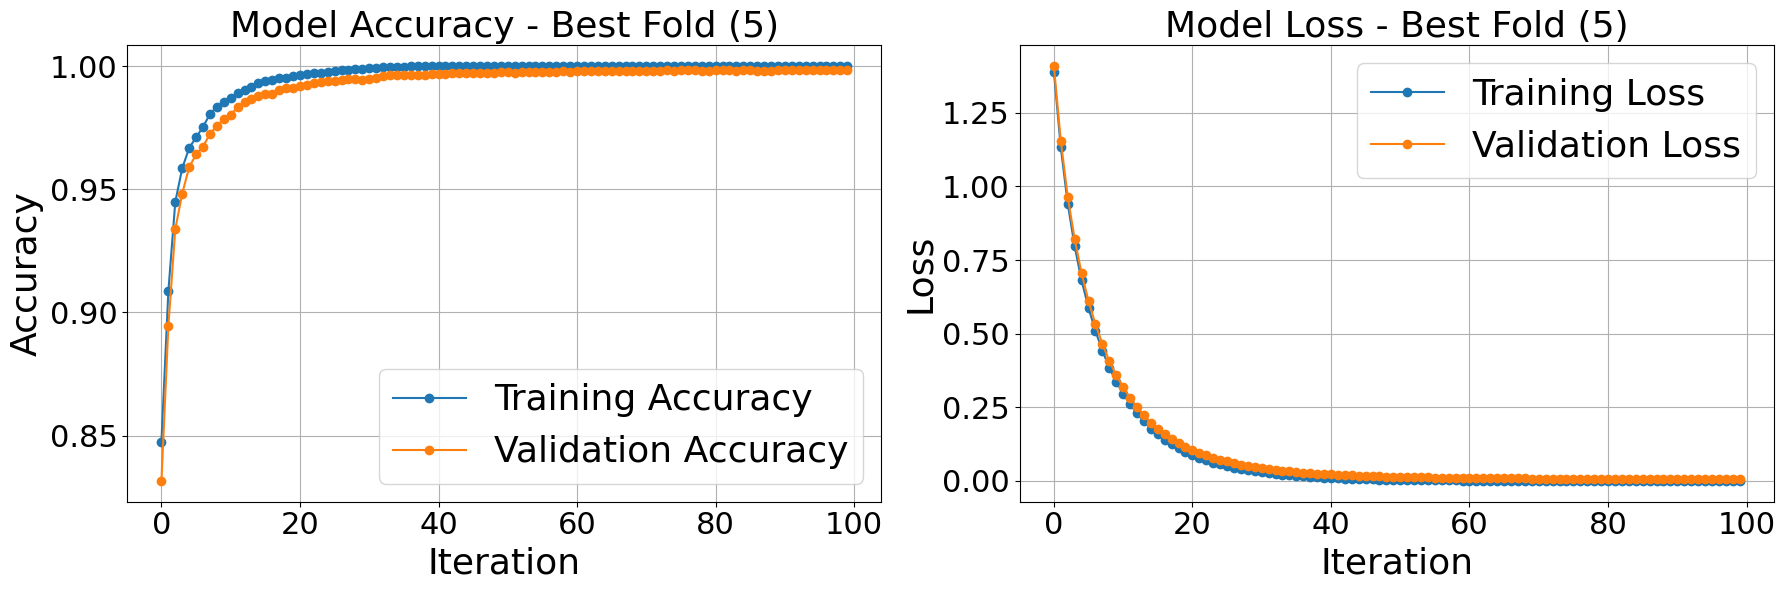


Best Fold (5) Final Metrics:
Training Accuracy: 1.0000
Validation Accuracy: 0.9983
Training Loss: 0.0000
Validation Loss: 0.0061

Improvements:
Training Accuracy Improvement: 0.1525 (18.00%)
Validation Accuracy Improvement: 0.1667 (20.05%)
Training Loss Reduction: 1.3902 (100.00%)
Validation Loss Reduction: 1.4026 (99.57%)

====== Class-Wise Metrics Across CV Folds ======
Per-Class Metrics Averaged Across All CV Folds:
                     Class  Precision  Recall/Sensitivity  F1-Score  \
0          Healthy_control     0.9996              0.9991    0.9994   
1                 anterior     0.9986              0.9969    0.9978   
2           antero-lateral     0.9968              0.9987    0.9978   
3            antero-septal     0.9977              0.9983    0.9980   
4     antero-septo-lateral     0.9818              0.9863    0.9841   
5                 inferior     0.9969              0.9979    0.9974   
6           infero-lateral     0.9980              0.9982    0.9981   
7       

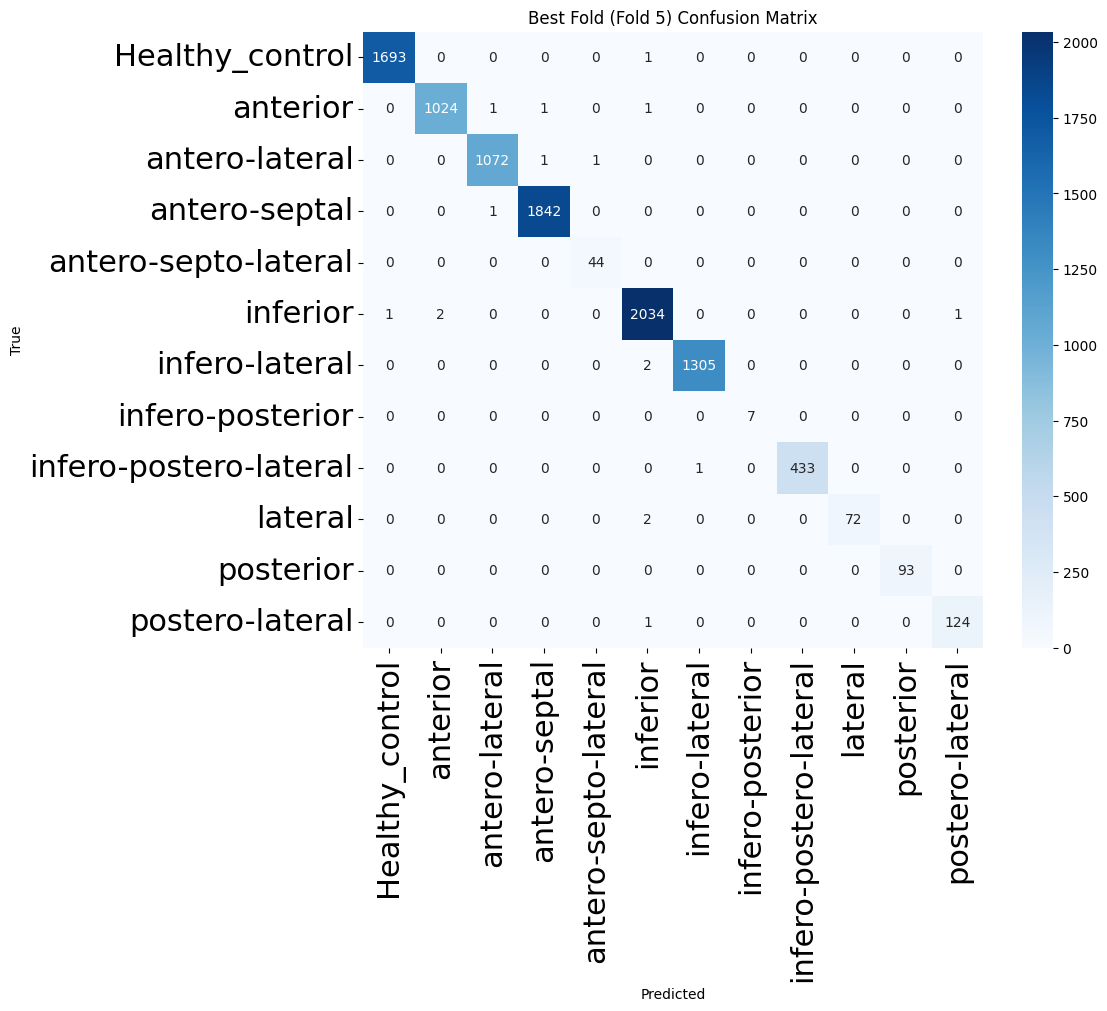

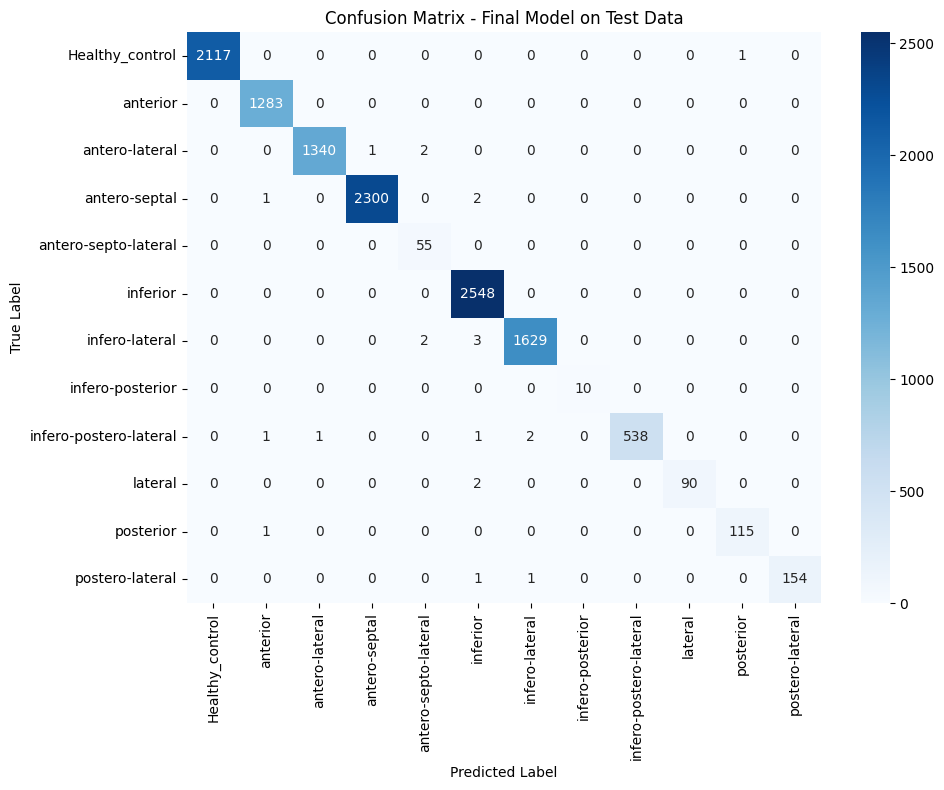

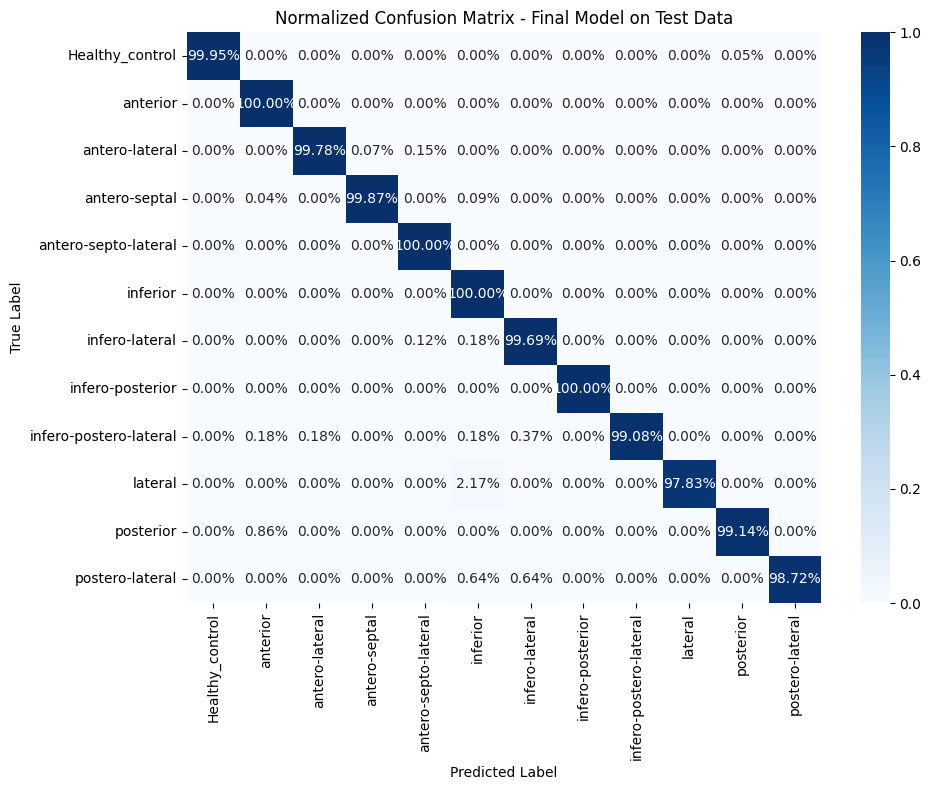


Confusion Matrix Analysis:

Class: Healthy_control
True Positive: 2117
Total Actual: 2118
Total Predicted as Healthy_control: 2117
Recall (Sensitivity): 0.9995
Precision: 1.0000

Class: anterior
True Positive: 1283
Total Actual: 1283
Total Predicted as anterior: 1286
Recall (Sensitivity): 1.0000
Precision: 0.9977

Class: antero-lateral
True Positive: 1340
Total Actual: 1343
Total Predicted as antero-lateral: 1341
Recall (Sensitivity): 0.9978
Precision: 0.9993

Class: antero-septal
True Positive: 2300
Total Actual: 2303
Total Predicted as antero-septal: 2301
Recall (Sensitivity): 0.9987
Precision: 0.9996

Class: antero-septo-lateral
True Positive: 55
Total Actual: 55
Total Predicted as antero-septo-lateral: 59
Recall (Sensitivity): 1.0000
Precision: 0.9322

Class: inferior
True Positive: 2548
Total Actual: 2548
Total Predicted as inferior: 2557
Recall (Sensitivity): 1.0000
Precision: 0.9965

Class: infero-lateral
True Positive: 1629
Total Actual: 1634
Total Predicted as infero-lateral:

In [27]:
# Load data
file_path = r'D:\TA_baru\dataset\all_label_extracted_features.xlsx'  # Adjust to your file path
df = pd.read_excel(file_path)

# Run classification with cross-validation
results = ensemble_boosting_classification(df)

XGBoost Default

In [22]:

def XGBoost_classification(df):
    # Prepare data
    X = df.drop(columns=["segment_id", "label"])
    y = df["label"]

    # Handle missing values
    X = X.fillna(0)

    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded = train_test_split(
        X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    # Dictionary to store all results
    results = {
        'models': {},
        'predictions': {},
        'metrics': {}
    }
    
    # XGBoost Classification
    print("\n=== XGBoost Classification with 5-Fold Cross-Validation ===")
    # Modified to include test data as parameters 
    xgb_model, xgb_metrics, cv_results = train_xgboost_with_cv(
        X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, le
    )
    
    results['models']['xgboost'] = xgb_model
    results['metrics']['xgboost'] = xgb_metrics
    results['cv_results'] = cv_results
    
    # Calculate and display class-wise metrics
    calculate_class_wise_metrics(results['cv_results'], le)

    # Plot confusion matrix for best model on training data
    plot_cv_results(results['cv_results'], le)
    
    # Plot confusion matrix for final model on test data
    plot_final_confusion_matrix(y_test_encoded, results['metrics']['xgboost']['predictions'], le)
    
    # Calculate class-wise metrics for test data 
    calculate_test_class_wise_metrics(y_test_encoded, results['metrics']['xgboost']['predictions'], le)
    
    return results

def train_xgboost_with_cv(X_train, y_train, X_test, y_test, label_encoder):
    # Get number of unique classes
    num_classes = len(np.unique(y_train))
    
    # Initialize the cross-validation splitter
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # XGBoost parameters for multiclass classification
    xgb_params = {
        'objective': 'multi:softprob',  # For multiclass probability output
        'num_class': num_classes,
        'eval_metric': 'mlogloss',      # Multi-class log loss
        'verbosity': 1                  # Suppress verbose output
    }
    
    # Perform cross-validation and store results
    cv_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrices': [],
        'fold_models': [],
        'fold_predictions': [],
        'fold_probabilities': [],
        'y_true': [],  
        'y_pred': [],  
        'class_reports': [],
        'train_accuracy': [], # Track training accuracy for each fold
        'val_accuracy': [],   # Track validation accuracy for each fold
        'train_loss': [],     # Track training loss for each fold
        'val_loss': [],       # Track validation loss for each fold
        'best_fold_history': None # Will store training history for best fold
    }
    
    print("\nPerforming 5-fold cross-validation on training data:")
    fold_num = 1
    best_fold = 0
    best_accuracy = 0
    best_fold_model = None
    
    # Track start time for entire training process
    start_time = time.time()
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
        
        # Create XGBoost DMatrix for training
        dtrain = xgb.DMatrix(X_fold_train, label=y_fold_train)
        dval = xgb.DMatrix(X_fold_val, label=y_fold_val)
        
        # Dictionary to store training history
        history = {
            'train_accuracy': [],
            'val_accuracy': [],
            'train_loss': [],
            'val_loss': []
        }
        
        # Evaluation list for tracking training progress
        evallist = [(dtrain, 'train'), (dval, 'eval')]
        
        # Store evaluation results
        evals_result = {}
        
        # Train the XGBoost model on this fold
        fold_model = xgb.train(
            xgb_params,
            dtrain,
            num_boost_round=100,  # number of boosting rounds
            evals=evallist,
            evals_result=evals_result,
            verbose_eval=False    # Suppress training output
        )
        
        # Extract training history from evals_result
        history['train_loss'] = evals_result['train']['mlogloss']
        history['val_loss'] = evals_result['eval']['mlogloss']
        
        # Calculate accuracy for each iteration (approximate)
        for i in range(len(history['train_loss'])):
            # Get predictions at this iteration
            train_pred_prob = fold_model.predict(dtrain, iteration_range=(0, i+1))
            val_pred_prob = fold_model.predict(dval, iteration_range=(0, i+1))
            
            # Convert probabilities to class predictions
            train_pred = np.argmax(train_pred_prob, axis=1)
            val_pred = np.argmax(val_pred_prob, axis=1)
            
            # Calculate accuracy
            train_acc = accuracy_score(y_fold_train, train_pred)
            val_acc = accuracy_score(y_fold_val, val_pred)
            
            history['train_accuracy'].append(train_acc)
            history['val_accuracy'].append(val_acc)
        
        # Final evaluation on training set
        train_pred_prob = fold_model.predict(dtrain)
        train_pred = np.argmax(train_pred_prob, axis=1)
        train_accuracy = accuracy_score(y_fold_train, train_pred)
        cv_results['train_accuracy'].append(train_accuracy)
        
        # Final evaluation on validation set
        val_pred_prob = fold_model.predict(dval)
        val_pred = np.argmax(val_pred_prob, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_fold_val, val_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_fold_val, val_pred, average='weighted')
        cm = confusion_matrix(y_fold_val, val_pred)
        
        # Store validation accuracy and loss
        cv_results['val_accuracy'].append(accuracy)
        cv_results['train_loss'].append(history['train_loss'][-1])
        cv_results['val_loss'].append(history['val_loss'][-1])
        
        # Store classification report as a dictionary
        class_report = classification_report(y_fold_val, val_pred, output_dict=True)
        
        # Store results for this fold
        cv_results['accuracy'].append(accuracy)
        cv_results['precision'].append(precision)
        cv_results['recall'].append(recall)
        cv_results['f1'].append(f1)
        cv_results['conf_matrices'].append(cm)
        cv_results['fold_models'].append(fold_model)
        cv_results['fold_predictions'].append(val_pred)
        cv_results['fold_probabilities'].append(val_pred_prob)
        cv_results['y_true'].append(y_fold_val)
        cv_results['y_pred'].append(val_pred)
        cv_results['class_reports'].append(class_report)
        
        # Track the best fold based on validation accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_fold = fold_num - 1  # Using 0-based indexing for arrays
            # Store training history for the best fold
            cv_results['best_fold_history'] = history
            best_fold_model = fold_model
        
        # Show results with 4 decimal places
        print(f"Fold {fold_num}: Train Accuracy={train_accuracy:.4f}, Val Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")
        fold_num += 1
    
    # Calculate mean and std of all metrics across folds
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        mean_val = np.mean(cv_results[metric])
        std_val = np.std(cv_results[metric])
        print(f"Mean {metric}: {mean_val:.4f} (±{std_val:.4f})")
    
    # Use the best fold model for final evaluation
    print(f"\nBest model found in fold {best_fold + 1} with validation accuracy of {best_accuracy:.4f}")
    final_model = best_fold_model
    
    # Evaluate the best fold model on the test set
    dtest = xgb.DMatrix(X_test)
    test_prob = final_model.predict(dtest)
    test_pred = np.argmax(test_prob, axis=1)
    
    # Calculate final metrics on test set
    training_time = time.time() - start_time
    metrics = evaluate_classifier(y_test, test_pred, test_prob, label_encoder, training_time)
    
    # Add predictions to metrics for confusion matrix plotting
    metrics['predictions'] = test_pred
    
    # Display test set results
    print(f"\nFinal Training Time: {training_time:.4f} seconds")
    print("\nFinal model evaluation on test set (20% of data):")
    print(classification_report(y_test, test_pred, target_names=label_encoder.classes_, digits=4))
    
    # Plot accuracy and loss for the best fold
    plot_accuracy_loss_curves(cv_results['best_fold_history'], best_fold)
    
    return final_model, metrics, cv_results

def evaluate_classifier(y_true, y_pred, y_prob, label_encoder, training_time=None):
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create metrics dictionary - REMOVED ROC metrics
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'training_time': training_time,
        # Add class-wise metrics
        'class_report': classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)
    }
    
    return metrics

def plot_cv_results(cv_results, label_encoder):
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    # Get class names
    class_names = label_encoder.classes_

    # Plot the best fold's confusion matrix
    best_fold = np.argmax(cv_results['accuracy'])
    best_cm = cv_results['conf_matrices'][best_fold]
    plt.figure(figsize=(10, 8))
    sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title(f'Best Fold (Fold {best_fold + 1}) Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    # plt.savefig('best_fold_CM_XGBoost.png')

def plot_final_confusion_matrix(y_true, y_pred, label_encoder):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Get class names
    class_names = label_encoder.classes_
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title('Confusion Matrix - Final Model on Test Data')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    # plt.savefig('final_model_CM_XGBoost.png')
    plt.show()
    
    # Calculate and display normalized confusion matrix (percentage)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title('Normalized Confusion Matrix - Final Model on Test Data')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('final_model_normalized_CM_XGBoost.png')
    plt.show()
    
    # Print additional information
    print("\nConfusion Matrix Analysis:")
    for i, class_name in enumerate(class_names):
        true_positive = cm[i, i]
        total_actual = np.sum(cm[i, :])
        total_predicted = np.sum(cm[:, i])
        print(f"\nClass: {class_name}")
        print(f"True Positive: {true_positive}")
        print(f"Total Actual: {total_actual}")
        print(f"Total Predicted as {class_name}: {total_predicted}")
        if total_actual > 0:
            print(f"Recall (Sensitivity): {true_positive/total_actual:.4f}")
        if total_predicted > 0:
            print(f"Precision: {true_positive/total_predicted:.4f}")

def plot_accuracy_loss_curves(history, best_fold):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot accuracy
    ax1.plot(history['train_accuracy'], label='Training Accuracy', marker='o')
    ax1.plot(history['val_accuracy'], label='Validation Accuracy', marker='o')
    ax1.set_title(f'Model Accuracy - Best Fold ({best_fold + 1})', fontsize=26)
    ax1.set_xlabel('Iteration', fontsize=26)
    ax1.set_ylabel('Accuracy', fontsize=26)
    ax1.legend(fontsize=26)
    ax1.tick_params(axis='both', which='major', labelsize=22)
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history['train_loss'], label='Training Loss', marker='o')
    ax2.plot(history['val_loss'], label='Validation Loss', marker='o')
    ax2.set_title(f'Model Loss - Best Fold ({best_fold + 1})', fontsize=26)
    ax2.set_xlabel('Iteration', fontsize=26)
    ax2.set_ylabel('Loss', fontsize=26)
    ax2.legend(fontsize=26)
    ax2.tick_params(axis='both', which='major', labelsize=22)
    ax2.grid(True)
    
    plt.tight_layout()
    # plt.savefig('best_fold_accuracy_loss_curves_XGBoost.png')
    plt.show()
    
    # Print final metrics for best fold
    print(f"\nBest Fold ({best_fold + 1}) Final Metrics:")
    print(f"Training Accuracy: {history['train_accuracy'][-1]:.4f}")
    print(f"Validation Accuracy: {history['val_accuracy'][-1]:.4f}")
    print(f"Training Loss: {history['train_loss'][-1]:.4f}")
    print(f"Validation Loss: {history['val_loss'][-1]:.4f}")
    
    # Calculate improvements
    first_train_acc = history['train_accuracy'][0]
    last_train_acc = history['train_accuracy'][-1]
    train_acc_improvement = last_train_acc - first_train_acc
    
    first_val_acc = history['val_accuracy'][0]
    last_val_acc = history['val_accuracy'][-1]
    val_acc_improvement = last_val_acc - first_val_acc
    
    first_train_loss = history['train_loss'][0]
    last_train_loss = history['train_loss'][-1]
    train_loss_reduction = first_train_loss - last_train_loss
    
    first_val_loss = history['val_loss'][0]
    last_val_loss = history['val_loss'][-1]
    val_loss_reduction = first_val_loss - last_val_loss
    
    print("\nImprovements:")
    print(f"Training Accuracy Improvement: {train_acc_improvement:.4f} ({train_acc_improvement/first_train_acc*100:.2f}%)")
    print(f"Validation Accuracy Improvement: {val_acc_improvement:.4f} ({val_acc_improvement/first_val_acc*100:.2f}%)")
    print(f"Training Loss Reduction: {train_loss_reduction:.4f} ({train_loss_reduction/first_train_loss*100:.2f}%)")
    print(f"Validation Loss Reduction: {val_loss_reduction:.4f} ({val_loss_reduction/first_val_loss*100:.2f}%)")

def calculate_class_wise_metrics(cv_results, label_encoder):
    print("\n====== Class-Wise Metrics Across CV Folds ======")
    
    # Concatenate results from all folds
    all_y_true = np.concatenate([y for y in cv_results['y_true']])
    all_y_pred = np.concatenate([y for y in cv_results['y_pred']])
    
    # Calculate per-class metrics across all folds
    class_report = classification_report(all_y_true, all_y_pred, 
                                         target_names=label_encoder.classes_, 
                                         output_dict=True)
    
    # Create DataFrame for better formatting
    classes = label_encoder.classes_
    class_metrics = pd.DataFrame({
        'Class': classes,
        'Precision': [class_report[c]['precision'] for c in classes],
        'Recall/Sensitivity': [class_report[c]['recall'] for c in classes],
        'F1-Score': [class_report[c]['f1-score'] for c in classes],
        'Support': [class_report[c]['support'] for c in classes]
    })
    
    # Add per-class accuracy
    accuracies = []
    for i, class_name in enumerate(classes):
        # For each class, accuracy is:
        # (true positives + true negatives) / (total samples)
        true_class = (all_y_true == i)
        pred_class = (all_y_pred == i)
        
        tp = np.sum(true_class & pred_class)  # True positives
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        total = len(all_y_true)
        
        accuracy = (tp + tn) / total
        accuracies.append(accuracy)
    
    class_metrics['Accuracy'] = accuracies
    
    # Add specificity (true negative rate)
    specificities = []
    for i, class_name in enumerate(classes):
        true_class = (all_y_true == i)  
        pred_class = (all_y_pred == i)
        
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        fp = np.sum(~true_class & pred_class)   # False positives
        
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificities.append(specificity)
    
    class_metrics['Specificity'] = specificities
    
    # Calculate per-fold metrics for each class
    fold_metrics = []
    for fold in range(len(cv_results['y_true'])):
        fold_y_true = cv_results['y_true'][fold]
        fold_y_pred = cv_results['y_pred'][fold]
        
        # Get classification report for this fold
        fold_report = classification_report(fold_y_true, fold_y_pred, 
                                           target_names=label_encoder.classes_,
                                           output_dict=True)
        
        # Extract class metrics
        for i, class_name in enumerate(classes):
            # Calculate class accuracy for this fold
            true_class = (fold_y_true == i)
            pred_class = (fold_y_pred == i)
            
            tp = np.sum(true_class & pred_class)  # True positives
            tn = np.sum(~true_class & ~pred_class)  # True negatives
            total = len(fold_y_true)
            
            accuracy = (tp + tn) / total
            
            # Calculate specificity
            tn = np.sum(~true_class & ~pred_class)  # True negatives
            fp = np.sum(~true_class & pred_class)   # False positives
            
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            
            fold_metrics.append({
                'Fold': fold + 1,
                'Class': class_name,
                'Precision': fold_report[class_name]['precision'],
                'Recall/Sensitivity': fold_report[class_name]['recall'], 
                'F1-Score': fold_report[class_name]['f1-score'],
                'Support': fold_report[class_name]['support'],
                'Accuracy': accuracy,
                'Specificity': specificity
            })
    
    # Create DataFrame with all fold results
    fold_df = pd.DataFrame(fold_metrics)
    
    # Display average metrics across all folds with 4 decimal places
    pd.set_option('display.float_format', '{:.4f}'.format)
    print("Per-Class Metrics Averaged Across All CV Folds:")
    print(class_metrics)
    
    # Save to CSV
    # class_metrics.to_csv('class_wise_metrics_cv_XGBoost.csv', index=False)
    # fold_df.to_csv('class_wise_metrics_by_fold_XGBoost.csv', index=False)
    
    # Display detailed results for each class by fold
    for class_name in classes:
        print(f"\nDetailed metrics for class '{class_name}' across folds:")
        class_fold_data = fold_df[fold_df['Class'] == class_name]
        
        # Calculate mean and std for each metric
        metrics_summary = {}
        for metric in ['Precision', 'Recall/Sensitivity', 'F1-Score', 'Accuracy', 'Specificity']:
            mean_val = class_fold_data[metric].mean()
            std_val = class_fold_data[metric].std()
            metrics_summary[metric] = f"{mean_val:.4f} (±{std_val:.4f})"
        
        # Print summary
        for metric, value in metrics_summary.items():
            print(f"{metric}: {value}")

def calculate_test_class_wise_metrics(y_true, y_pred, label_encoder):
    """Calculate detailed class-wise metrics for test data"""
    print("\n====== Class-Wise Metrics on Test Data ======")
    
    # Calculate per-class metrics on test data
    class_report = classification_report(y_true, y_pred, 
                                        target_names=label_encoder.classes_, 
                                        output_dict=True)
    
    # Create DataFrame for better formatting
    classes = label_encoder.classes_
    test_class_metrics = pd.DataFrame({
        'Class': classes,
        'Precision': [class_report[c]['precision'] for c in classes],
        'Recall/Sensitivity': [class_report[c]['recall'] for c in classes],
        'F1-Score': [class_report[c]['f1-score'] for c in classes],
        'Support': [class_report[c]['support'] for c in classes]
    })
    
    # Add per-class accuracy
    accuracies = []
    for i, class_name in enumerate(classes):
        # For each class, accuracy is:
        # (true positives + true negatives) / (total samples)
        true_class = (y_true == i)
        pred_class = (y_pred == i)
        
        tp = np.sum(true_class & pred_class)  # True positives
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        total = len(y_true)
        
        accuracy = (tp + tn) / total
        accuracies.append(accuracy)
    
    test_class_metrics['Accuracy'] = accuracies
    
    # Add specificity (true negative rate)
    specificities = []
    for i, class_name in enumerate(classes):
        true_class = (y_true == i)  
        pred_class = (y_pred == i)
        
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        fp = np.sum(~true_class & pred_class)   # False positives
        
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificities.append(specificity)
    
    test_class_metrics['Specificity'] = specificities
    
    # Calculate additional useful metrics for each class
    npvs = []  # Negative Predictive Values
    balanced_accuracies = []  # Balanced Accuracy (mean of sensitivity and specificity)
    
    for i, class_name in enumerate(classes):
        true_class = (y_true == i)
        pred_class = (y_pred == i)
        
        tp = np.sum(true_class & pred_class)  # True positives
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        fp = np.sum(~true_class & pred_class)  # False positives
        fn = np.sum(true_class & ~pred_class)  # False negatives
        
        # Negative Predictive Value = TN / (TN + FN)
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        npvs.append(npv)
        
        # Sensitivity (Recall)
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        # Specificity (already calculated)
        specificity = specificities[i]
        
        # Balanced Accuracy
        bal_acc = (sensitivity + specificity) / 2
        balanced_accuracies.append(bal_acc)
    
    test_class_metrics['NPV'] = npvs
    test_class_metrics['Balanced_Accuracy'] = balanced_accuracies
    
    # Display test metrics with 4 decimal places
    pd.set_option('display.float_format', '{:.4f}'.format)
    print("Per-Class Metrics on Test Data:")
    print(test_class_metrics)
    
    # Save to CSV
    # test_class_metrics.to_csv('test_class_wise_metrics_XGBoost.csv', index=False)
    
    # Calculate and print overall metrics on test set
    print("\nOverall Test Metrics:")
    overall_accuracy = accuracy_score(y_true, y_pred)
    overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted'
    )
    print(f"Accuracy: {overall_accuracy:.4f}")
    print(f"Weighted Precision: {overall_precision:.4f}")
    print(f"Weighted Recall: {overall_recall:.4f}")
    print(f"Weighted F1-Score: {overall_f1:.4f}")
    
    # Additional diagnostics for each class
    print("\nDetailed Per-Class Analysis on Test Set:")
    for i, class_name in enumerate(classes):
        true_class = (y_true == i)
        pred_class = (y_pred == i)
        
        tp = np.sum(true_class & pred_class)  # True positives
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        fp = np.sum(~true_class & pred_class)  # False positives
        fn = np.sum(true_class & ~pred_class)  # False negatives
        
        print(f"\nClass: {class_name}")
        print(f"True Positives: {tp}")
        print(f"False Positives: {fp}")
        print(f"True Negatives: {tn}")
        print(f"False Negatives: {fn}")
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"Precision: {precision:.4f}")
        print(f"Recall/Sensitivity: {recall:.4f}")
        print(f"Specificity: {specificity:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1-Score: {f1:.4f}")
        
    return test_class_metrics


=== XGBoost Classification with 5-Fold Cross-Validation ===

Performing 5-fold cross-validation on training data:
Fold 1: Train Accuracy=1.0000, Val Accuracy=0.9978, Precision=0.9979, Recall=0.9978, F1=0.9978
Fold 2: Train Accuracy=1.0000, Val Accuracy=0.9980, Precision=0.9980, Recall=0.9980, F1=0.9979
Fold 3: Train Accuracy=1.0000, Val Accuracy=0.9977, Precision=0.9978, Recall=0.9977, F1=0.9977
Fold 4: Train Accuracy=1.0000, Val Accuracy=0.9977, Precision=0.9977, Recall=0.9977, F1=0.9977
Fold 5: Train Accuracy=1.0000, Val Accuracy=0.9990, Precision=0.9990, Recall=0.9990, F1=0.9990
Mean accuracy: 0.9981 (±0.0005)
Mean precision: 0.9981 (±0.0005)
Mean recall: 0.9981 (±0.0005)
Mean f1: 0.9981 (±0.0005)

Best model found in fold 5 with validation accuracy of 0.9990

Final Training Time: 60.9167 seconds

Final model evaluation on test set (20% of data):
                        precision    recall  f1-score   support

       Healthy_control     0.9995    0.9991    0.9993      2118
        

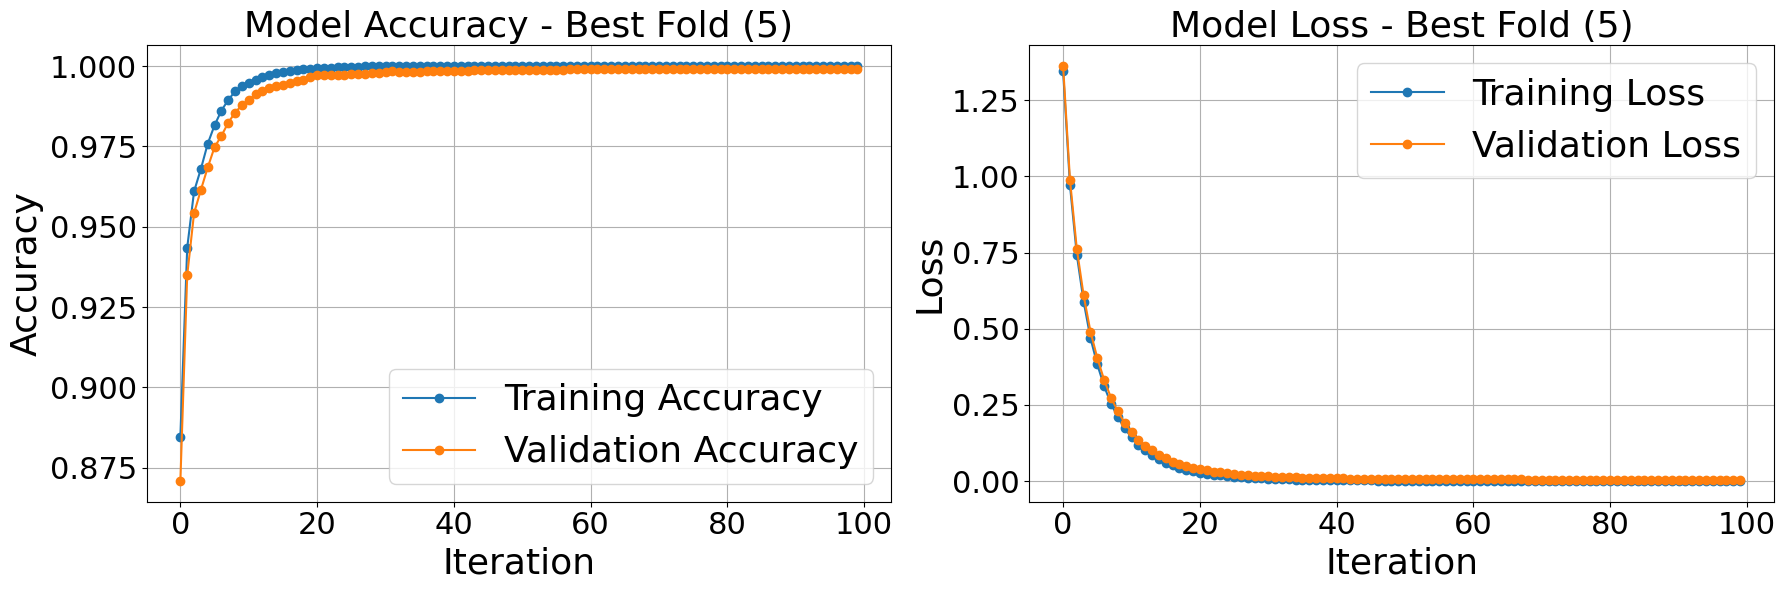


Best Fold (5) Final Metrics:
Training Accuracy: 1.0000
Validation Accuracy: 0.9990
Training Loss: 0.0004
Validation Loss: 0.0045

Improvements:
Training Accuracy Improvement: 0.1153 (13.04%)
Validation Accuracy Improvement: 0.1281 (14.71%)
Training Loss Reduction: 1.3443 (99.97%)
Validation Loss Reduction: 1.3579 (99.67%)

====== Class-Wise Metrics Across CV Folds ======
Per-Class Metrics Averaged Across All CV Folds:
                     Class  Precision  Recall/Sensitivity  F1-Score  \
0          Healthy_control     0.9995              0.9992    0.9994   
1                 anterior     0.9988              0.9965    0.9977   
2           antero-lateral     0.9957              0.9983    0.9970   
3            antero-septal     0.9979              0.9980    0.9980   
4     antero-septo-lateral     0.9954              0.9863    0.9908   
5                 inferior     0.9973              0.9979    0.9976   
6           infero-lateral     0.9983              0.9985    0.9984   
7        

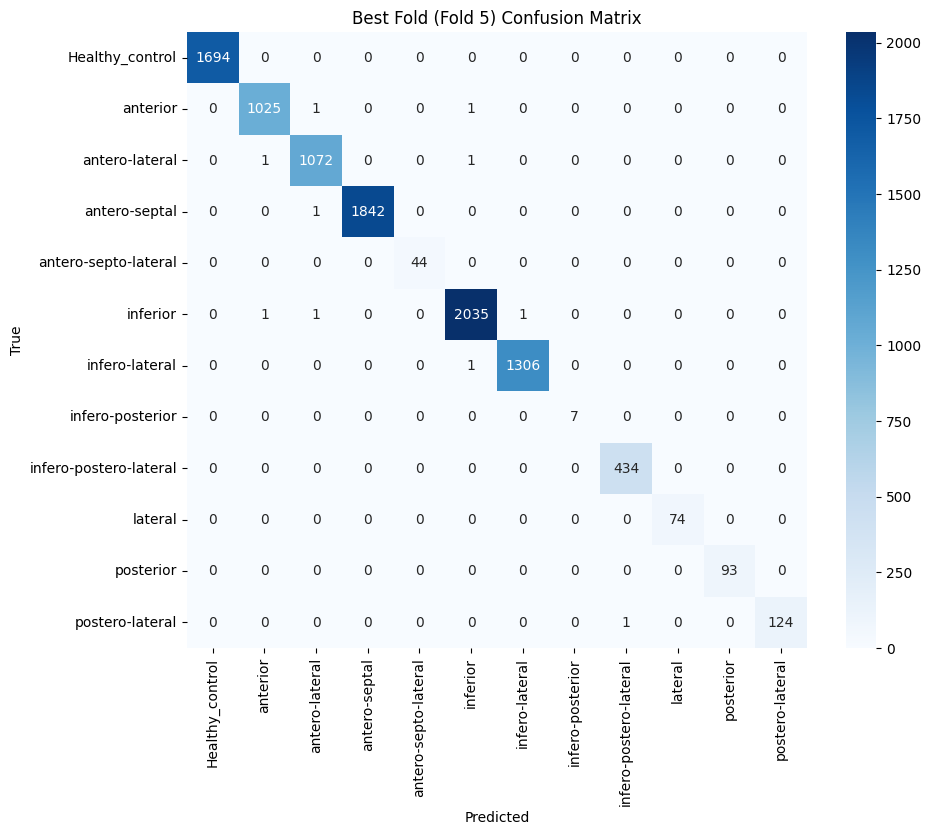

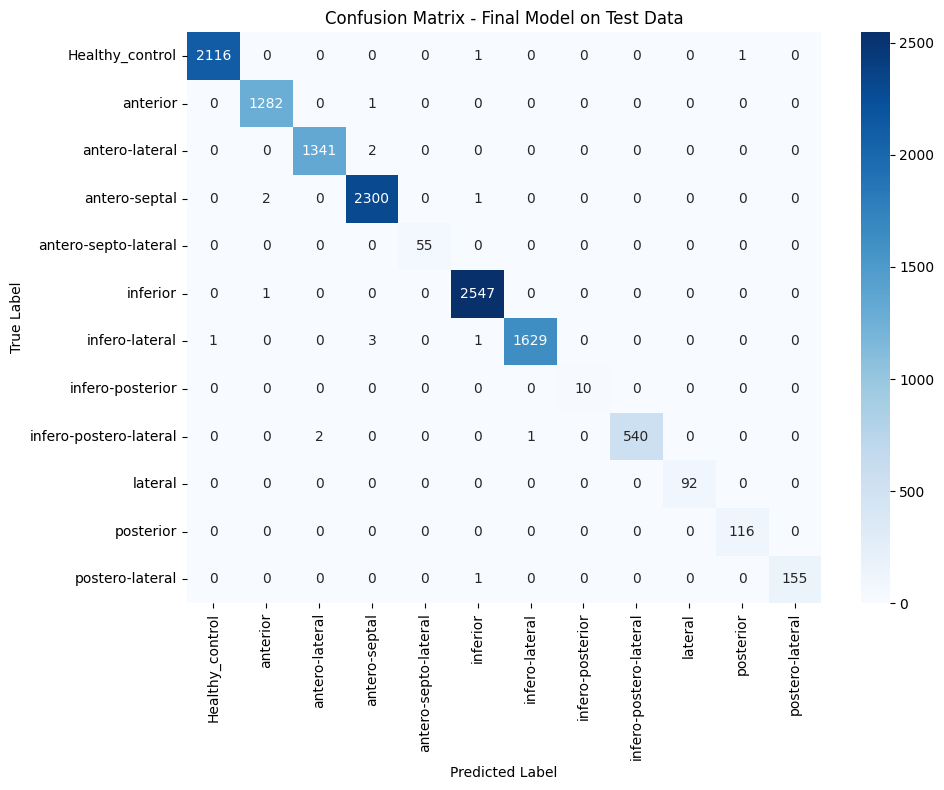

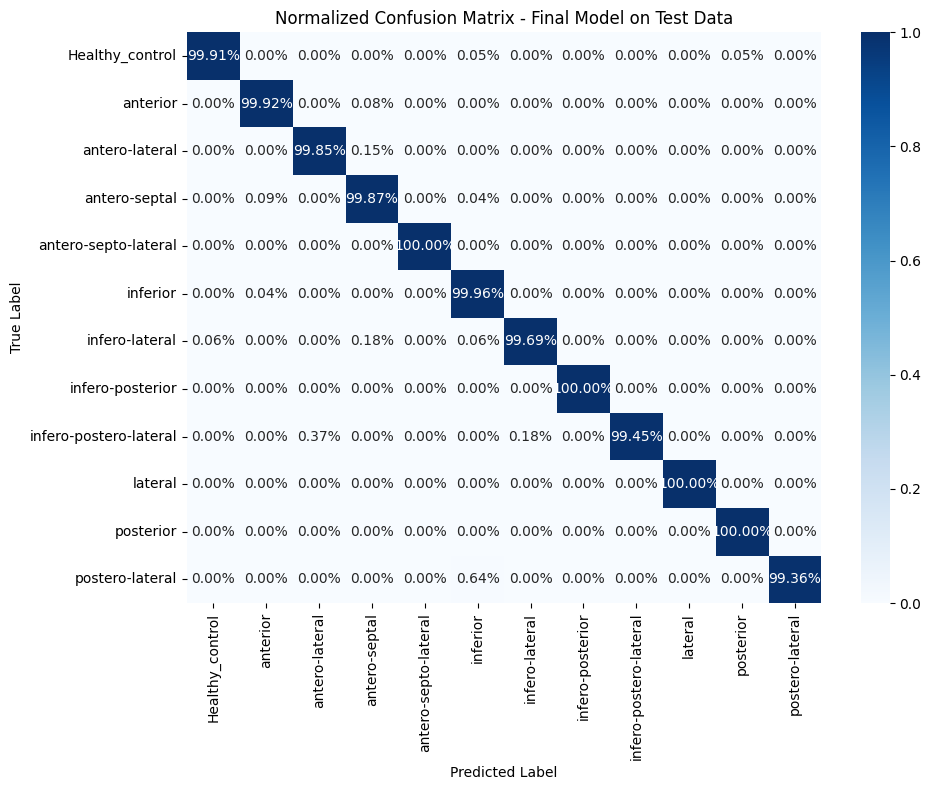


Confusion Matrix Analysis:

Class: Healthy_control
True Positive: 2116
Total Actual: 2118
Total Predicted as Healthy_control: 2117
Recall (Sensitivity): 0.9991
Precision: 0.9995

Class: anterior
True Positive: 1282
Total Actual: 1283
Total Predicted as anterior: 1285
Recall (Sensitivity): 0.9992
Precision: 0.9977

Class: antero-lateral
True Positive: 1341
Total Actual: 1343
Total Predicted as antero-lateral: 1343
Recall (Sensitivity): 0.9985
Precision: 0.9985

Class: antero-septal
True Positive: 2300
Total Actual: 2303
Total Predicted as antero-septal: 2306
Recall (Sensitivity): 0.9987
Precision: 0.9974

Class: antero-septo-lateral
True Positive: 55
Total Actual: 55
Total Predicted as antero-septo-lateral: 55
Recall (Sensitivity): 1.0000
Precision: 1.0000

Class: inferior
True Positive: 2547
Total Actual: 2548
Total Predicted as inferior: 2551
Recall (Sensitivity): 0.9996
Precision: 0.9984

Class: infero-lateral
True Positive: 1629
Total Actual: 1634
Total Predicted as infero-lateral:

In [23]:
# Load data
file_path = r'D:\TA_baru\dataset\all_label_extracted_features.xlsx'  # Adjust to your file path
df = pd.read_excel(file_path)

# Run classification with cross-validation
results = XGBoost_classification(df)

ADAboost Default

In [17]:

def AdaBoost_classification(df):
    # Prepare data
    X = df.drop(columns=["segment_id", "label"])
    y = df["label"]

    # Handle missing values
    X = X.fillna(0)

    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded = train_test_split(
        X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    # Dictionary to store all results
    results = {
        'models': {},
        'predictions': {},
        'metrics': {}
    }
    
    # AdaBoost Classification
    print("\n=== AdaBoost Classification with 5-Fold Cross-Validation ===")
    # Modified to include test data as parameters 
    ada_model, ada_metrics, cv_results = train_adaboost_with_cv(
        X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, le
    )
    
    results['models']['adaboost'] = ada_model
    results['metrics']['adaboost'] = ada_metrics
    results['cv_results'] = cv_results
    
    # Calculate and display class-wise metrics
    calculate_class_wise_metrics(results['cv_results'], le)
    
    # Plot cross-validation results
    plot_cv_results(results['cv_results'],le)

    # Plot confusion matrix for final model on test data
    plot_final_confusion_matrix(y_test_encoded, results['metrics']['adaboost']['predictions'], le)
    
    # Calculate class-wise metrics for test data (ADDED)
    calculate_test_class_wise_metrics(y_test_encoded, results['metrics']['adaboost']['predictions'], le)
    
    return results

def train_adaboost_with_cv(X_train, y_train, X_test, y_test, label_encoder):
    # Get number of unique classes
    num_classes = len(np.unique(y_train))
    
    # Initialize the cross-validation splitter
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # AdaBoost parameters
    # Using Decision Tree as base estimator with limited depth to prevent overfitting
    base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)
    ada_params = {
        'estimator': base_estimator,
        'n_estimators': 100,
        'algorithm': 'SAMME',
        'random_state': 42
    }
    
    # Perform cross-validation and store results
    cv_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrices': [],
        'fold_models': [],
        'fold_predictions': [],
        'fold_probabilities': [],
        'y_true': [],  
        'y_pred': [],  
        'class_reports': [],
        'train_accuracy': [], # Track training accuracy for each fold
        'val_accuracy': [],   # Track validation accuracy for each fold
        'train_loss': [],     # Track training loss for each fold
        'val_loss': [],       # Track validation loss for each fold
        'best_fold_history': None # Will store training history for best fold
    }
    
    print("\nPerforming 5-fold cross-validation on training data:")
    fold_num = 1
    best_fold = 0
    best_accuracy = 0
    best_fold_model = None
    
    # Track start time for entire training process
    start_time = time.time()
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
        
        # Create AdaBoost classifier
        fold_model = AdaBoostClassifier(**ada_params)
        
        # Dictionary to store training history for staged predictions
        history = {
            'train_accuracy': [],
            'val_accuracy': [],
            'train_loss': [],
            'val_loss': []
        }
        
        # Train the model
        fold_model.fit(X_fold_train, y_fold_train)
        
        # Get staged predictions to track training progress
        # AdaBoost allows us to get predictions at each stage of boosting
        train_staged_scores = list(fold_model.staged_decision_function(X_fold_train))
        val_staged_scores = list(fold_model.staged_decision_function(X_fold_val))
        
        # For binary classification, we need to convert labels to -1, 1 for proper loss calculation
        if num_classes == 2:
            y_fold_train_binary = 2 * y_fold_train - 1  # Convert 0,1 to -1,1
            y_fold_val_binary = 2 * y_fold_val - 1      # Convert 0,1 to -1,1
        
        # Convert decision function scores to predictions and calculate metrics
        for stage_idx in range(len(train_staged_scores)):
            # For training data
            if num_classes == 2:
                train_stage_pred = (train_staged_scores[stage_idx] > 0).astype(int)
                # Calculate exponential loss for binary classification
                # Loss = exp(-y * f(x)) where y is in {-1, 1}
                train_loss = np.mean(np.exp(-y_fold_train_binary * train_staged_scores[stage_idx]))
            else:
                train_stage_pred = np.argmax(train_staged_scores[stage_idx], axis=1)
                # For multiclass, use cross-entropy loss approximation
                # Convert decision scores to probabilities
                exp_scores = np.exp(train_staged_scores[stage_idx])
                probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
                # Calculate cross-entropy loss
                train_loss = -np.mean(np.log(probs[np.arange(len(y_fold_train)), y_fold_train] + 1e-15))
            
            train_acc = accuracy_score(y_fold_train, train_stage_pred)
            
            # For validation data
            if num_classes == 2:
                val_stage_pred = (val_staged_scores[stage_idx] > 0).astype(int)
                # Calculate exponential loss for binary classification
                val_loss = np.mean(np.exp(-y_fold_val_binary * val_staged_scores[stage_idx]))
            else:
                val_stage_pred = np.argmax(val_staged_scores[stage_idx], axis=1)
                # For multiclass, use cross-entropy loss approximation
                exp_scores = np.exp(val_staged_scores[stage_idx])
                probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
                val_loss = -np.mean(np.log(probs[np.arange(len(y_fold_val)), y_fold_val] + 1e-15))
                
            val_acc = accuracy_score(y_fold_val, val_stage_pred)
            
            # Store metrics
            history['train_accuracy'].append(train_acc)
            history['val_accuracy'].append(val_acc)
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
        
        # Final predictions for this fold
        y_train_pred = fold_model.predict(X_fold_train)
        train_accuracy = accuracy_score(y_fold_train, y_train_pred)
        cv_results['train_accuracy'].append(train_accuracy)
        
        # Predict on validation set
        y_pred = fold_model.predict(X_fold_val)
        
        # Get probabilities for validation set
        if hasattr(fold_model, "predict_proba"):
            y_val_prob = fold_model.predict_proba(X_fold_val)
        else:
            # If predict_proba is not available, use decision function
            decision_scores = fold_model.decision_function(X_fold_val)
            if num_classes == 2:
                # Binary classification
                y_val_prob = np.column_stack([1 - 1/(1 + np.exp(-decision_scores)), 
                                             1/(1 + np.exp(-decision_scores))])
            else:
                # Multiclass - convert decision function to probabilities
                exp_scores = np.exp(decision_scores)
                y_val_prob = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        # Calculate metrics
        accuracy = accuracy_score(y_fold_val, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_fold_val, y_pred, average='weighted')
        cm = confusion_matrix(y_fold_val, y_pred)
        
        # Store validation accuracy and loss (take the last values)
        cv_results['val_accuracy'].append(accuracy)
        cv_results['train_loss'].append(history['train_loss'][-1])
        cv_results['val_loss'].append(history['val_loss'][-1])
        
        # Store classification report as a dictionary
        class_report = classification_report(y_fold_val, y_pred, output_dict=True)
        
        # Store results for this fold
        cv_results['accuracy'].append(accuracy)
        cv_results['precision'].append(precision)
        cv_results['recall'].append(recall)
        cv_results['f1'].append(f1)
        cv_results['conf_matrices'].append(cm)
        cv_results['fold_models'].append(fold_model)
        cv_results['fold_predictions'].append(y_pred)
        cv_results['fold_probabilities'].append(y_val_prob)
        cv_results['y_true'].append(y_fold_val)
        cv_results['y_pred'].append(y_pred)
        cv_results['class_reports'].append(class_report)
        
        # Track the best fold based on validation accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_fold = fold_num - 1  # Using 0-based indexing for arrays
            # Store training history for the best fold
            cv_results['best_fold_history'] = history
            best_fold_model = fold_model
        
        # Show results with 4 decimal places
        print(f"Fold {fold_num}: Train Accuracy={train_accuracy:.4f}, Val Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")
        fold_num += 1
    
    # Calculate mean and std of all metrics across folds
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        mean_val = np.mean(cv_results[metric])
        std_val = np.std(cv_results[metric])
        print(f"Mean {metric}: {mean_val:.4f} (±{std_val:.4f})")
    
    # Use the best fold model for final evaluation
    print(f"\nBest model found in fold {best_fold + 1} with validation accuracy of {best_accuracy:.4f}")
    final_model = best_fold_model
    
    # Evaluate the best fold model on the test set
    test_pred = final_model.predict(X_test)
    
    # Get test probabilities
    if hasattr(final_model, "predict_proba"):
        test_prob = final_model.predict_proba(X_test)
    else:
        # If predict_proba is not available, use decision function
        decision_scores = final_model.decision_function(X_test)
        if num_classes == 2:
            test_prob = np.column_stack([1 - 1/(1 + np.exp(-decision_scores)), 
                                        1/(1 + np.exp(-decision_scores))])
        else:
            exp_scores = np.exp(decision_scores)
            test_prob = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # Calculate final metrics on test set
    training_time = time.time() - start_time
    metrics = evaluate_classifier(y_test, test_pred, test_prob, label_encoder, training_time)
    
    # Add predictions to metrics for confusion matrix plotting
    metrics['predictions'] = test_pred
    
    # Display test set results
    print(f"\nFinal Training Time: {training_time:.4f} seconds")
    print("\nFinal model evaluation on test set (20% of data):")
    print(classification_report(y_test, test_pred, target_names=label_encoder.classes_, digits=4))
    
    # Plot accuracy and loss for the best fold
    plot_accuracy_loss_curves(cv_results['best_fold_history'], best_fold)
    
    return final_model, metrics, cv_results

def evaluate_classifier(y_true, y_pred, y_prob, label_encoder, training_time=None):
    """Evaluate classifier performance"""
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create metrics dictionary - REMOVED ROC metrics
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'training_time': training_time,
        # Add class-wise metrics
        'class_report': classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)
    }
    
    return metrics

def plot_cv_results(cv_results, label_encoder):
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    # Get class names
    class_names = label_encoder.classes_

    # Plot the best fold's confusion matrix
    best_fold = np.argmax(cv_results['accuracy'])
    best_cm = cv_results['conf_matrices'][best_fold]
    plt.figure(figsize=(10, 8))
    sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title(f'Best Fold (Fold {best_fold + 1}) Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    # plt.savefig('best_fold_CM_ADABOOST.png')

def plot_final_confusion_matrix(y_true, y_pred, label_encoder):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Get class names
    class_names = label_encoder.classes_
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title('Confusion Matrix - Final Model on Test Data')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    # plt.savefig('final_model_CM_ADABOOST.png')
    plt.show()
    
    # Calculate and display normalized confusion matrix (percentage)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title('Normalized Confusion Matrix - Final Model on Test Data')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    
    # Print additional information
    print("\nConfusion Matrix Analysis:")
    for i, class_name in enumerate(class_names):
        true_positive = cm[i, i]
        total_actual = np.sum(cm[i, :])
        total_predicted = np.sum(cm[:, i])
        print(f"\nClass: {class_name}")
        print(f"True Positive: {true_positive}")
        print(f"Total Actual: {total_actual}")
        print(f"Total Predicted as {class_name}: {total_predicted}")
        if total_actual > 0:
            print(f"Recall (Sensitivity): {true_positive/total_actual:.4f}")
        if total_predicted > 0:
            print(f"Precision: {true_positive/total_predicted:.4f}")

def plot_accuracy_loss_curves(history, best_fold):
    """Plot accuracy and loss curves for the best fold with proper inverse relationship"""
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot accuracy
    ax1.plot(history['train_accuracy'], label='Training Accuracy', marker='o', linewidth=2)
    ax1.plot(history['val_accuracy'], label='Validation Accuracy', marker='s', linewidth=2)
    ax1.set_title(f'Model Accuracy - Best Fold ({best_fold + 1})', fontsize=26)
    ax1.set_xlabel('Boosting Iteration', fontsize=26)
    ax1.set_ylabel('Accuracy', fontsize=26)
    ax1.legend(fontsize=26)
    ax1.tick_params(axis='both', which='major', labelsize=22)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])
    
    # Plot loss (inverted y-axis to show loss decreasing as accuracy increases)
    ax2.plot(history['train_loss'], label='Training Loss', marker='o', linewidth=2)
    ax2.plot(history['val_loss'], label='Validation Loss', marker='s', linewidth=2)
    ax2.set_title(f'Model Loss - Best Fold ({best_fold + 1})', fontsize=26)
    ax2.set_xlabel('Boosting Iteration', fontsize=26)
    ax2.set_ylabel('Loss', fontsize=26)
    ax2.legend(fontsize=26)
    ax2.tick_params(axis='both', which='major', labelsize=22)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    # plt.savefig('best_fold_accuracy_loss_curves_ADABOOST.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print final metrics for best fold
    print(f"\nBest Fold ({best_fold + 1}) Final Metrics:")
    print(f"Training Accuracy: {history['train_accuracy'][-1]:.4f}")
    print(f"Validation Accuracy: {history['val_accuracy'][-1]:.4f}")
    print(f"Training Loss: {history['train_loss'][-1]:.4f}")
    print(f"Validation Loss: {history['val_loss'][-1]:.4f}")
    
    # Calculate improvements
    first_train_acc = history['train_accuracy'][0]
    last_train_acc = history['train_accuracy'][-1]
    train_acc_improvement = last_train_acc - first_train_acc
    
    first_val_acc = history['val_accuracy'][0]
    last_val_acc = history['val_accuracy'][-1]
    val_acc_improvement = last_val_acc - first_val_acc
    
    first_train_loss = history['train_loss'][0]
    last_train_loss = history['train_loss'][-1]
    train_loss_reduction = first_train_loss - last_train_loss
    
    first_val_loss = history['val_loss'][0]
    last_val_loss = history['val_loss'][-1]
    val_loss_reduction = first_val_loss - last_val_loss
    
    print("\nImprovements:")
    print(f"Training Accuracy Improvement: {train_acc_improvement:.4f} ({train_acc_improvement/first_train_acc*100:.2f}%)")
    print(f"Validation Accuracy Improvement: {val_acc_improvement:.4f} ({val_acc_improvement/first_val_acc*100:.2f}%)")
    print(f"Training Loss Reduction: {train_loss_reduction:.4f} ({train_loss_reduction/first_train_loss*100:.2f}%)")
    print(f"Validation Loss Reduction: {val_loss_reduction:.4f} ({val_loss_reduction/first_val_loss*100:.2f}%)")
    
def calculate_class_wise_metrics(cv_results, label_encoder):
    print("\n====== Class-Wise Metrics Across CV Folds ======")
    
    # Concatenate results from all folds
    all_y_true = np.concatenate([y for y in cv_results['y_true']])
    all_y_pred = np.concatenate([y for y in cv_results['y_pred']])
    
    # Calculate per-class metrics across all folds
    class_report = classification_report(all_y_true, all_y_pred, 
                                         target_names=label_encoder.classes_, 
                                         output_dict=True)
    
    # Create DataFrame for better formatting
    classes = label_encoder.classes_
    class_metrics = pd.DataFrame({
        'Class': classes,
        'Precision': [class_report[c]['precision'] for c in classes],
        'Recall/Sensitivity': [class_report[c]['recall'] for c in classes],
        'F1-Score': [class_report[c]['f1-score'] for c in classes],
        'Support': [class_report[c]['support'] for c in classes]
    })
    
    # Add per-class accuracy
    accuracies = []
    for i, class_name in enumerate(classes):
        # For each class, accuracy is:
        # (true positives + true negatives) / (total samples)
        true_class = (all_y_true == i)
        pred_class = (all_y_pred == i)
        
        tp = np.sum(true_class & pred_class)  # True positives
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        total = len(all_y_true)
        
        accuracy = (tp + tn) / total
        accuracies.append(accuracy)
    
    class_metrics['Accuracy'] = accuracies
    
    # Add specificity (true negative rate)
    specificities = []
    for i, class_name in enumerate(classes):
        true_class = (all_y_true == i)  
        pred_class = (all_y_pred == i)
        
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        fp = np.sum(~true_class & pred_class)   # False positives
        
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificities.append(specificity)
    
    class_metrics['Specificity'] = specificities
    
    # Calculate per-fold metrics for each class
    fold_metrics = []
    for fold in range(len(cv_results['y_true'])):
        fold_y_true = cv_results['y_true'][fold]
        fold_y_pred = cv_results['y_pred'][fold]
        
        # Get classification report for this fold
        fold_report = classification_report(fold_y_true, fold_y_pred, 
                                           target_names=label_encoder.classes_,
                                           output_dict=True)
        
        # Extract class metrics
        for i, class_name in enumerate(classes):
            # Calculate class accuracy for this fold
            true_class = (fold_y_true == i)
            pred_class = (fold_y_pred == i)
            
            tp = np.sum(true_class & pred_class)  # True positives
            tn = np.sum(~true_class & ~pred_class)  # True negatives
            total = len(fold_y_true)
            
            accuracy = (tp + tn) / total
            
            # Calculate specificity
            tn = np.sum(~true_class & ~pred_class)  # True negatives
            fp = np.sum(~true_class & pred_class)   # False positives
            
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            
            fold_metrics.append({
                'Fold': fold + 1,
                'Class': class_name,
                'Precision': fold_report[class_name]['precision'],
                'Recall/Sensitivity': fold_report[class_name]['recall'], 
                'F1-Score': fold_report[class_name]['f1-score'],
                'Support': fold_report[class_name]['support'],
                'Accuracy': accuracy,
                'Specificity': specificity
            })
    
    # Create DataFrame with all fold results
    fold_df = pd.DataFrame(fold_metrics)
    
    # Display average metrics across all folds with 4 decimal places
    pd.set_option('display.float_format', '{:.4f}'.format)
    print("Per-Class Metrics Averaged Across All CV Folds:")
    print(class_metrics)
    
    # Save to CSV
    # class_metrics.to_csv('class_wise_metrics_cv_ADABOOST.csv', index=False)
    # fold_df.to_csv('class_wise_metrics_by_fold_ADABOOST.csv', index=False)
    
    # Display detailed results for each class by fold
    for class_name in classes:
        print(f"\nDetailed metrics for class '{class_name}' across folds:")
        class_fold_data = fold_df[fold_df['Class'] == class_name]
        
        # Calculate mean and std for each metric
        metrics_summary = {}
        for metric in ['Precision', 'Recall/Sensitivity', 'F1-Score', 'Accuracy', 'Specificity']:
            mean_val = class_fold_data[metric].mean()
            std_val = class_fold_data[metric].std()
            metrics_summary[metric] = f"{mean_val:.4f} (±{std_val:.4f})"
        
        # Print summary
        for metric, value in metrics_summary.items():
            print(f"{metric}: {value}")

def calculate_test_class_wise_metrics(y_true, y_pred, label_encoder):
    """Calculate detailed class-wise metrics for test data"""
    print("\n====== Class-Wise Metrics on Test Data ======")
    
    # Calculate per-class metrics on test data
    class_report = classification_report(y_true, y_pred, 
                                        target_names=label_encoder.classes_, 
                                        output_dict=True)
    
    # Create DataFrame for better formatting
    classes = label_encoder.classes_
    test_class_metrics = pd.DataFrame({
        'Class': classes,
        'Precision': [class_report[c]['precision'] for c in classes],
        'Recall/Sensitivity': [class_report[c]['recall'] for c in classes],
        'F1-Score': [class_report[c]['f1-score'] for c in classes],
        'Support': [class_report[c]['support'] for c in classes]
    })
    
    # Add per-class accuracy
    accuracies = []
    for i, class_name in enumerate(classes):
        # For each class, accuracy is:
        # (true positives + true negatives) / (total samples)
        true_class = (y_true == i)
        pred_class = (y_pred == i)
        
        tp = np.sum(true_class & pred_class)  # True positives
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        total = len(y_true)
        
        accuracy = (tp + tn) / total
        accuracies.append(accuracy)
    
    test_class_metrics['Accuracy'] = accuracies
    
    # Add specificity (true negative rate)
    specificities = []
    for i, class_name in enumerate(classes):
        true_class = (y_true == i)  
        pred_class = (y_pred == i)
        
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        fp = np.sum(~true_class & pred_class)   # False positives
        
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificities.append(specificity)
    
    test_class_metrics['Specificity'] = specificities
    
    # Calculate additional useful metrics for each class
    npvs = []  # Negative Predictive Values
    balanced_accuracies = []  # Balanced Accuracy (mean of sensitivity and specificity)
    
    for i, class_name in enumerate(classes):
        true_class = (y_true == i)
        pred_class = (y_pred == i)
        
        tp = np.sum(true_class & pred_class)  # True positives
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        fp = np.sum(~true_class & pred_class)  # False positives
        fn = np.sum(true_class & ~pred_class)  # False negatives
        
        # Negative Predictive Value = TN / (TN + FN)
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        npvs.append(npv)
        
        # Sensitivity (Recall)
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        # Specificity (already calculated)
        specificity = specificities[i]
        
        # Balanced Accuracy
        bal_acc = (sensitivity + specificity) / 2
        balanced_accuracies.append(bal_acc)
    
    test_class_metrics['NPV'] = npvs
    test_class_metrics['Balanced_Accuracy'] = balanced_accuracies
    
    # Display test metrics with 4 decimal places
    pd.set_option('display.float_format', '{:.4f}'.format)
    print("Per-Class Metrics on Test Data:")
    print(test_class_metrics)
    
    # Save to CSV
    # test_class_metrics.to_csv('test_class_wise_metrics_ADABOOST.csv', index=False)
    
    # Calculate and print overall metrics on test set
    print("\nOverall Test Metrics:")
    overall_accuracy = accuracy_score(y_true, y_pred)
    overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted'
    )
    print(f"Accuracy: {overall_accuracy:.4f}")
    print(f"Weighted Precision: {overall_precision:.4f}")
    print(f"Weighted Recall: {overall_recall:.4f}")
    print(f"Weighted F1-Score: {overall_f1:.4f}")
    
    # Additional diagnostics for each class
    print("\nDetailed Per-Class Analysis on Test Set:")
    for i, class_name in enumerate(classes):
        true_class = (y_true == i)
        pred_class = (y_pred == i)
        
        tp = np.sum(true_class & pred_class)  # True positives
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        fp = np.sum(~true_class & pred_class)  # False positives
        fn = np.sum(true_class & ~pred_class)  # False negatives
        
        print(f"\nClass: {class_name}")
        print(f"True Positives: {tp}")
        print(f"False Positives: {fp}")
        print(f"True Negatives: {tn}")
        print(f"False Negatives: {fn}")
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"Precision: {precision:.4f}")
        print(f"Recall/Sensitivity: {recall:.4f}")
        print(f"Specificity: {specificity:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1-Score: {f1:.4f}")
        
    return test_class_metrics
        


=== AdaBoost Classification with 5-Fold Cross-Validation ===

Performing 5-fold cross-validation on training data:


C:\Users\Fauzan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fauzan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fauzan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classific

Fold 1: Train Accuracy=0.4284, Val Accuracy=0.4273, Precision=0.4449, Recall=0.4273, F1=0.4161


C:\Users\Fauzan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fauzan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fauzan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classific

Fold 2: Train Accuracy=0.4973, Val Accuracy=0.4907, Precision=0.5018, Recall=0.4907, F1=0.4792


C:\Users\Fauzan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fauzan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fauzan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classific

Fold 3: Train Accuracy=0.4334, Val Accuracy=0.4326, Precision=0.4738, Recall=0.4326, F1=0.4081


C:\Users\Fauzan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fauzan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fauzan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classific

Fold 4: Train Accuracy=0.4171, Val Accuracy=0.4236, Precision=0.4778, Recall=0.4236, F1=0.4159


C:\Users\Fauzan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fauzan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fauzan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classific

Fold 5: Train Accuracy=0.4661, Val Accuracy=0.4685, Precision=0.4557, Recall=0.4685, F1=0.4515
Mean accuracy: 0.4486 (±0.0265)
Mean precision: 0.4708 (±0.0196)
Mean recall: 0.4486 (±0.0265)
Mean f1: 0.4342 (±0.0271)

Best model found in fold 2 with validation accuracy of 0.4907


C:\Users\Fauzan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fauzan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fauzan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classific


Final Training Time: 169.5627 seconds

Final model evaluation on test set (20% of data):
                        precision    recall  f1-score   support

       Healthy_control     0.7185    0.7096    0.7140      2118
              anterior     0.2851    0.4856    0.3593      1283
        antero-lateral     0.3310    0.2777    0.3020      1343
         antero-septal     0.5457    0.4255    0.4782      2303
  antero-septo-lateral     0.0000    0.0000    0.0000        55
              inferior     0.4953    0.6837    0.5744      2548
        infero-lateral     0.5685    0.4523    0.5037      1634
      infero-posterior     0.0000    0.0000    0.0000        10
infero-postero-lateral     0.3146    0.0516    0.0886       543
               lateral     0.0000    0.0000    0.0000        92
             posterior     1.0000    0.0259    0.0504       116
       postero-lateral     1.0000    0.5897    0.7419       156

              accuracy                         0.4986     12201
            

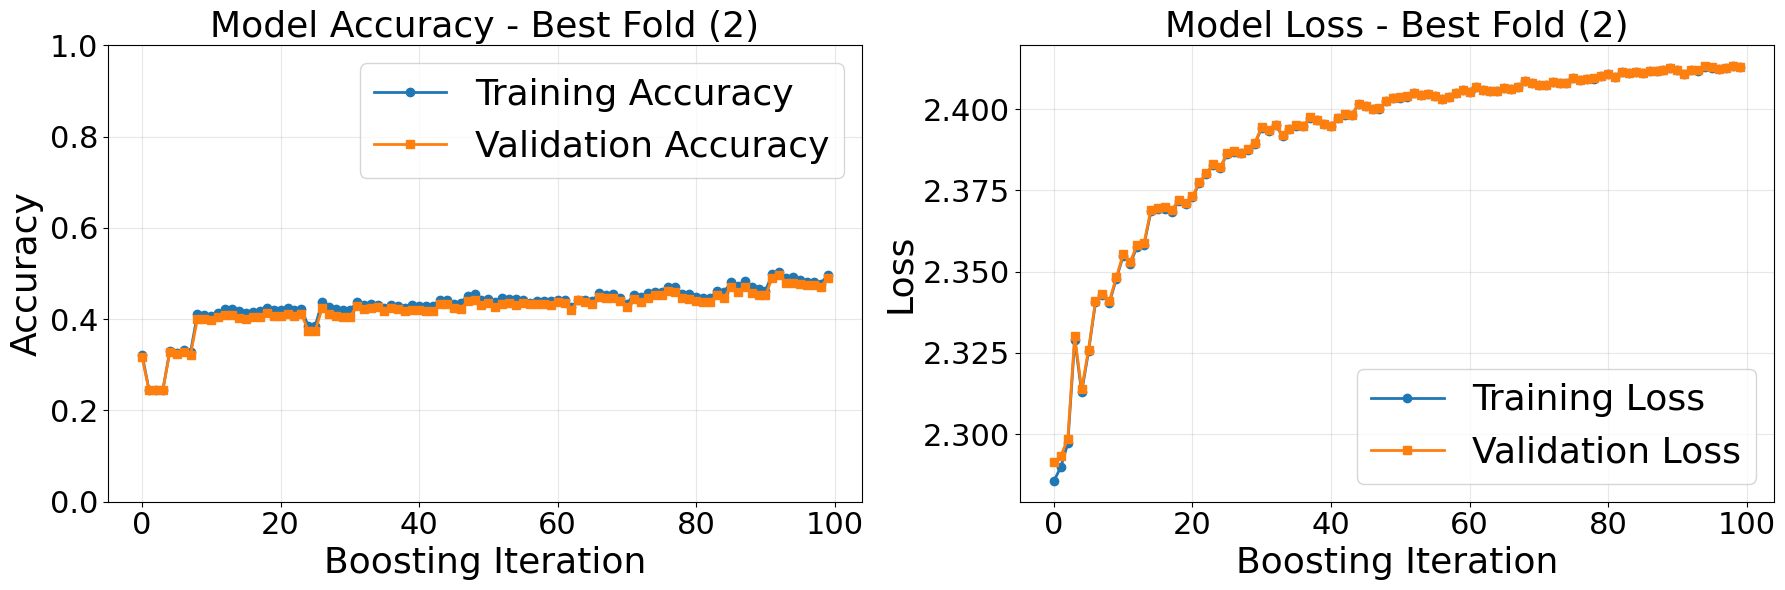


Best Fold (2) Final Metrics:
Training Accuracy: 0.4973
Validation Accuracy: 0.4907
Training Loss: 2.4130
Validation Loss: 2.4131

Improvements:
Training Accuracy Improvement: 0.1748 (54.19%)
Validation Accuracy Improvement: 0.1735 (54.72%)
Training Loss Reduction: -0.1274 (-5.58%)
Validation Loss Reduction: -0.1217 (-5.31%)

====== Class-Wise Metrics Across CV Folds ======
Per-Class Metrics Averaged Across All CV Folds:
                     Class  Precision  Recall/Sensitivity  F1-Score  \
0          Healthy_control     0.6919              0.5621    0.6203   
1                 anterior     0.2934              0.4097    0.3420   
2           antero-lateral     0.2826              0.2145    0.2439   
3            antero-septal     0.4953              0.4935    0.4944   
4     antero-septo-lateral     0.0000              0.0000    0.0000   
5                 inferior     0.4012              0.6284    0.4898   
6           infero-lateral     0.5404              0.3992    0.4592   
7      

C:\Users\Fauzan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fauzan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fauzan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classific

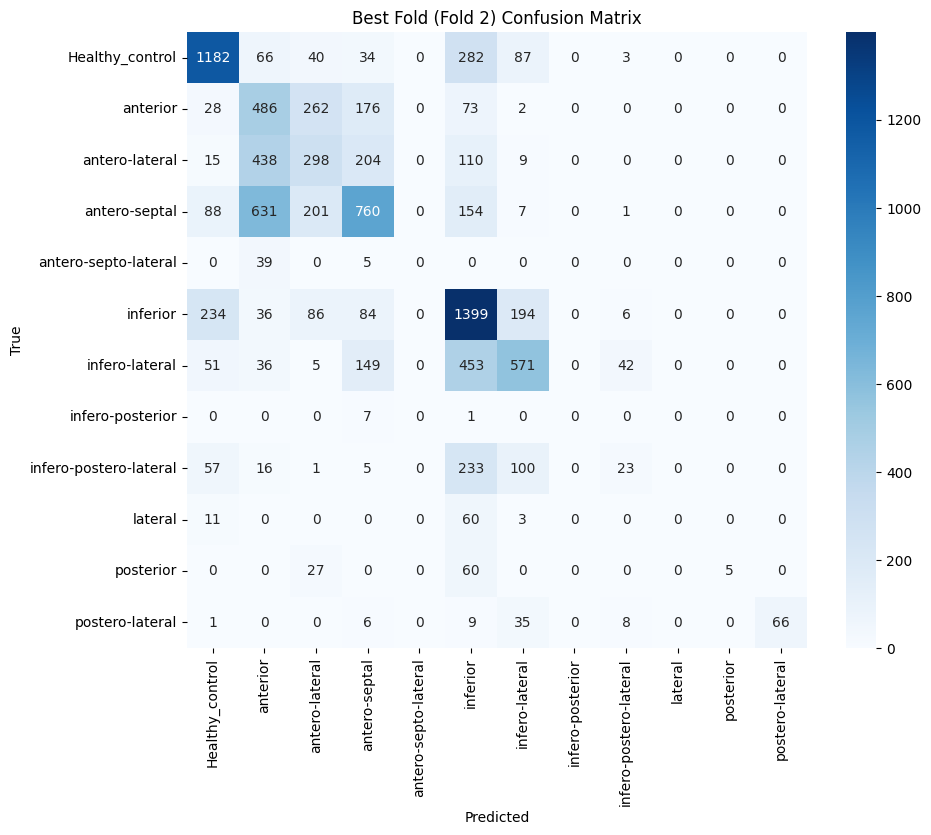

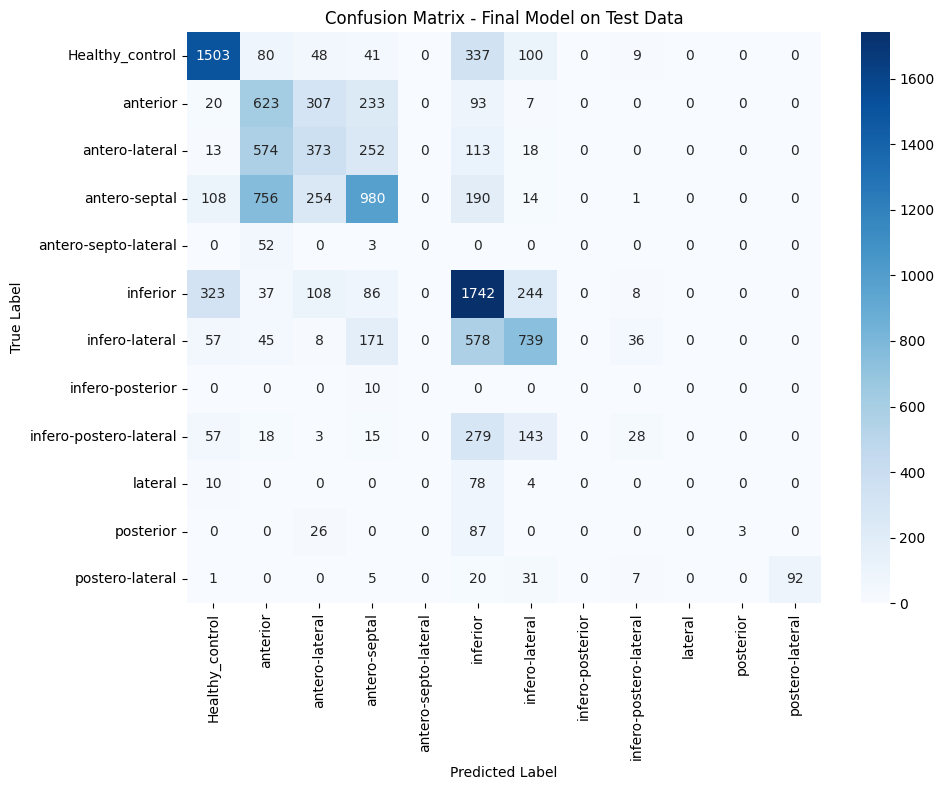

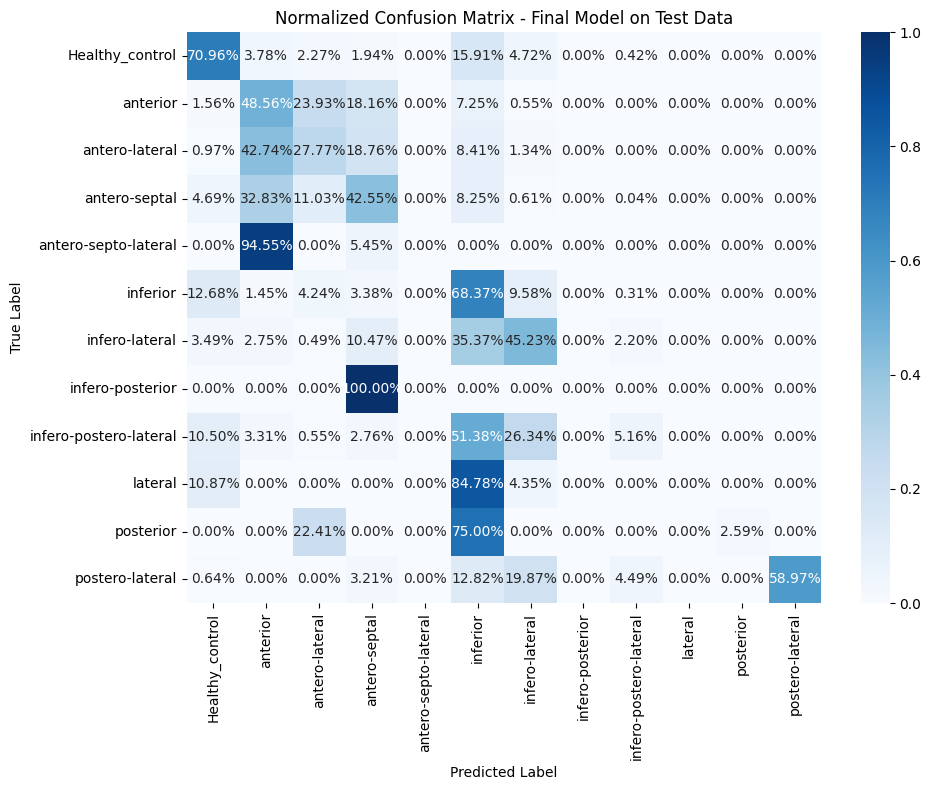


Confusion Matrix Analysis:

Class: Healthy_control
True Positive: 1503
Total Actual: 2118
Total Predicted as Healthy_control: 2092
Recall (Sensitivity): 0.7096
Precision: 0.7185

Class: anterior
True Positive: 623
Total Actual: 1283
Total Predicted as anterior: 2185
Recall (Sensitivity): 0.4856
Precision: 0.2851

Class: antero-lateral
True Positive: 373
Total Actual: 1343
Total Predicted as antero-lateral: 1127
Recall (Sensitivity): 0.2777
Precision: 0.3310

Class: antero-septal
True Positive: 980
Total Actual: 2303
Total Predicted as antero-septal: 1796
Recall (Sensitivity): 0.4255
Precision: 0.5457

Class: antero-septo-lateral
True Positive: 0
Total Actual: 55
Total Predicted as antero-septo-lateral: 0
Recall (Sensitivity): 0.0000

Class: inferior
True Positive: 1742
Total Actual: 2548
Total Predicted as inferior: 3517
Recall (Sensitivity): 0.6837
Precision: 0.4953

Class: infero-lateral
True Positive: 739
Total Actual: 1634
Total Predicted as infero-lateral: 1300
Recall (Sensitivit

C:\Users\Fauzan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fauzan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fauzan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classific

In [18]:
# Load data
file_path = r'D:\TA_baru\dataset\all_label_extracted_features.xlsx'  # Adjust to your file path
df = pd.read_excel(file_path)

# Run classification with cross-validation
results = AdaBoost_classification(df)

# HyperParameter Tuning

LightGBM

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import lightgbm as lgb
import time

# Function to perform hyperparameter tuning using RandomizedSearchCV
def perform_hyperparameter_tuning(X_train, y_train, num_classes):
    print("\n=== Starting Hyperparameter Tuning for LightGBM ===")
    
    # Initialize LGBMClassifier for scikit-learn compatibility
    lgb_clf = lgb.LGBMClassifier(objective='multiclass', 
                                 num_class=num_classes, 
                                 random_state=42,
                                 n_jobs=-1) 
    
    # Define the parameter distribution for RandomizedSearchCV
    # These ranges can be adjusted based on initial results or domain knowledge
    param_distributions = {
        'n_estimators': [300], # Number of boosting rounds
        'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
        'num_leaves': [20, 31, 40, 50, 60], 
        'max_depth': [-1, 5, 7, 10, 15], 
        'min_child_samples': [10, 20, 30, 40, 50], 
        'subsample': [0.7, 0.8, 0.9, 1.0], 
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0], 
        'reg_alpha': [0, 0.1, 0.5, 1.0], 
        'reg_lambda': [0, 0.1, 0.5, 1.0], 
    }
    
    # Set up StratifiedKFold for cross-validation during tuning
    cv_tuning = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(estimator=lgb_clf, 
                                       param_distributions=param_distributions,
                                       n_iter=50, # Number of random combinations to try
                                       cv=cv_tuning, 
                                       scoring='f1_weighted', 
                                       verbose=2, 
                                       random_state=42,
                                       n_jobs=-1)
    
    # Perform the search
    search_start_time = time.time()
    random_search.fit(X_train, y_train)
    search_end_time = time.time()
    
    print(f"\nHyperparameter tuning completed in {(search_end_time - search_start_time):.2f} seconds.")
    print(f"Best parameters found: {random_search.best_params_}")
    print(f"Best cross-validation F1-weighted score: {random_search.best_score_:.4f}")
    
    return random_search.best_params_

def ensemble_boosting_classification(df):
    # Prepare data
    X = df.drop(columns=["segment_id", "label"])
    y = df["label"]

    # Handle missing values by filling with 0 (can be customized)
    X = X.fillna(0)

    # Encode categorical labels into numerical format
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Scale numerical features using StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split data into training and testing sets
    # stratify=y_encoded ensures that the proportion of classes is the same in train and test sets
    X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded = train_test_split(
        X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    print("\n=== LightGBM Classification with 5-Fold Cross-Validation ===")
    
    # Perform hyperparameter tuning to find the best parameters
    num_classes = len(np.unique(y_encoded))
    best_lgb_params = perform_hyperparameter_tuning(X_train_scaled, y_train_encoded, num_classes)
    
file_path = r'D:\TA_baru\dataset\all_label_extracted_features.xlsx' 
df = pd.read_excel(file_path)

results = ensemble_boosting_classification(df)


=== LightGBM Classification with 5-Fold Cross-Validation ===

=== Starting Hyperparameter Tuning for LightGBM ===
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Hyperparameter tuning completed in 1327.92 seconds.
Best parameters found: {'subsample': 0.9, 'reg_lambda': 0, 'reg_alpha': 0, 'num_leaves': 50, 'n_estimators': 300, 'min_child_samples': 10, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
Best cross-validation F1-weighted score: 0.9983


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, roc_curve, auc
import lightgbm as lgb
import time

def ensemble_boosting_classification(df):
    # Prepare data
    X = df.drop(columns=["segment_id", "label"])
    y = df["label"]

    # Handle missing values
    X = X.fillna(0)

    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded = train_test_split(
        X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    # Dictionary to store all results
    results = {
        'models': {},
        'predictions': {},
        'metrics': {}
    }
    
    # LightGBM Classification
    print("\n=== LightGBM Classification with 5-Fold Cross-Validation ===")
    # Modified to include test data as parameters 
    lgb_model, lgb_metrics, cv_results = train_lightgbm_with_cv(
        X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, le
    )
    
    results['models']['lightgbm'] = lgb_model
    results['metrics']['lightgbm'] = lgb_metrics
    results['cv_results'] = cv_results
    
    # Calculate and display class-wise metrics
    calculate_class_wise_metrics(results['cv_results'], le)

    calculate_test_class_wise_metrics(y_test_encoded, results['metrics']['lightgbm']['predictions'], le)
    
    plot_cv_results(cv_results, le)

    # Plot confusion matrix for final model on test data
    plot_final_confusion_matrix(y_test_encoded, results['metrics']['lightgbm']['predictions'], le)
    
    return results

def train_lightgbm_with_cv(X_train, y_train, X_test, y_test, label_encoder):
    # Get number of unique classes
    num_classes = len(np.unique(y_train))
    
    # Initialize the cross-validation splitter
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # LightGBM parameters with hyperparameter tuning results
    lgb_params = {
        'objective': 'multiclass',
        'num_class': num_classes,
        'metric': 'multi_logloss',
        'verbose': -1,
        # Tuned hyperparameters
        'learning_rate': 0.05,
        'num_leaves': 50,
        'max_depth': 7,
        'min_child_samples': 10,
        'subsample': 0.9,
        'colsample_bytree': 0.7,
        'reg_alpha': 0,
        'reg_lambda': 0,
        'random_state': 42,  # For reproducibility
        'force_col_wise': True  # For better performance
    }
    
    # Perform cross-validation and store results
    cv_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrices': [],
        'fold_models': [],
        'fold_predictions': [],
        'fold_probabilities': [],
        'y_true': [],  
        'y_pred': [],  
        'class_reports': [],
        'train_accuracy': [],
        'val_accuracy': [],
        'train_loss': [],
        'val_loss': [],
        'best_fold_history': None
    }
    
    print("\nPerforming 5-fold cross-validation on training data (LightGBM with tuned parameters):")
    print("Tuned Parameters:")
    for key, value in lgb_params.items():
        if key not in ['objective', 'num_class', 'metric', 'verbose', 'force_col_wise']:
            print(f"  {key}: {value}")
    
    fold_num = 1
    best_fold = 0
    best_accuracy = 0
    best_fold_model = None
    
    # Track start time for entire training process
    start_time = time.time()
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
        
        # Create LightGBM datasets for training with callback support
        train_data = lgb.Dataset(X_fold_train, label=y_fold_train)
        valid_data = lgb.Dataset(X_fold_val, label=y_fold_val, reference=train_data)
        
        # Dictionary to store training history
        history = {
            'train_accuracy': [],
            'val_accuracy': [],
            'train_loss': [],
            'val_loss': []
        }
        
        # Callback function to collect metrics during training
        def callback(env):
            # Get current iteration metrics
            train_loss = env.evaluation_result_list[0][2]
            val_loss = env.evaluation_result_list[1][2]
            
            # Calculate accuracy on training data (using the current booster)
            train_preds = np.argmax(env.model.predict(X_fold_train), axis=1)
            train_acc = accuracy_score(y_fold_train, train_preds)
            
            # Calculate accuracy on validation data
            val_preds = np.argmax(env.model.predict(X_fold_val), axis=1)
            val_acc = accuracy_score(y_fold_val, val_preds)
            
            # Store metrics
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['train_accuracy'].append(train_acc)
            history['val_accuracy'].append(val_acc)
            
            return False  # Return False to continue training
        
        # Train the model on this fold with callbacks
        # Using n_estimators from tuned parameters (300 instead of default 100)
        fold_model = lgb.train(
            lgb_params,
            train_data,
            num_boost_round=300,  # number of boosting iterations
            valid_sets=[train_data, valid_data],
            valid_names=['training', 'validation'],
            callbacks=[lgb.log_evaluation(period=100), callback]
        )
        
        # Evaluate on training set using the booster
        y_train_prob = fold_model.predict(X_fold_train)
        train_pred = np.argmax(y_train_prob, axis=1)
        train_accuracy = accuracy_score(y_fold_train, train_pred)
        cv_results['train_accuracy'].append(train_accuracy)
        
        # Predict on validation set using booster
        y_val_prob = fold_model.predict(X_fold_val)
        y_pred = np.argmax(y_val_prob, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_fold_val, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_fold_val, y_pred, average='weighted', zero_division=0)
        cm = confusion_matrix(y_fold_val, y_pred)
        
        # Store validation accuracy
        cv_results['val_accuracy'].append(accuracy)
        
        # Store validation and training loss (take the last values)
        cv_results['train_loss'].append(history['train_loss'][-1])
        cv_results['val_loss'].append(history['val_loss'][-1])
        
        # Store classification report as a dictionary
        class_report = classification_report(y_fold_val, y_pred, output_dict=True, zero_division=0)
        
        # Store results for this fold
        cv_results['accuracy'].append(accuracy)
        cv_results['precision'].append(precision)
        cv_results['recall'].append(recall)
        cv_results['f1'].append(f1)
        cv_results['conf_matrices'].append(cm)
        cv_results['fold_models'].append(fold_model)
        cv_results['fold_predictions'].append(y_pred)
        cv_results['fold_probabilities'].append(y_val_prob)
        cv_results['y_true'].append(y_fold_val)
        cv_results['y_pred'].append(y_pred)
        cv_results['class_reports'].append(class_report)
        
        # Track the best fold based on validation accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_fold = fold_num - 1
            cv_results['best_fold_history'] = history
            best_fold_model = fold_model
        
        # Show results with 4 decimal places
        print(f"Fold {fold_num}: Train Acc={train_accuracy:.4f}, Val Acc={accuracy:.4f}, Prec={precision:.4f}, Rec={recall:.4f}, F1={f1:.4f}")
        fold_num += 1
    
    # Calculate mean and std of all metrics across folds
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        mean_val = np.mean(cv_results[metric])
        std_val = np.std(cv_results[metric])
        print(f"Mean {metric}: {mean_val:.4f} (±{std_val:.4f})")
    
    # Use the best fold model for final evaluation
    print(f"\nBest model found in fold {best_fold + 1} with validation accuracy of {best_accuracy:.4f}")
    final_model = best_fold_model
    
    # Evaluate the best fold model on the test set
    test_prob = final_model.predict(X_test)
    test_pred = np.argmax(test_prob, axis=1)
    
    # Calculate final metrics on test set
    training_time = time.time() - start_time
    metrics = evaluate_classifier(y_test, test_pred, test_prob, label_encoder, training_time)
    
    # Add predictions to metrics for confusion matrix plotting
    metrics['predictions'] = test_pred
    
    # Display test set results
    print(f"\nFinal LightGBM Training Time (including CV): {training_time:.4f} seconds")
    print(f"Best model used {fold_model.num_trees()} trees (early stopping may have reduced from 300)")
    print("\nFinal model evaluation on HELD-OUT TEST SET (LightGBM with tuned parameters):")
    print(classification_report(y_test, test_pred, target_names=label_encoder.classes_, digits=4, zero_division=0))
    
    # Plot accuracy and loss for the best fold
    plot_accuracy_loss_curves(cv_results['best_fold_history'], best_fold)
    
    return final_model, metrics, cv_results

def evaluate_classifier(y_true, y_pred, y_prob, label_encoder, training_time=None):
    """Evaluate classifier performance"""
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # ROC curve and AUC (one-vs-rest)
    n_classes = len(label_encoder.classes_)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Macro-average ROC curve
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    
    mean_tpr /= n_classes
    macro_roc_auc = auc(all_fpr, mean_tpr)
    
    # Create metrics dictionary
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'macro_roc_auc': macro_roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'all_fpr': all_fpr,
        'mean_tpr': mean_tpr,
        'training_time': training_time,
        # Add class-wise metrics
        'class_report': classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)
    }
    
    return metrics

def plot_cv_results(cv_results, label_encoder):
    class_names = label_encoder.classes_

    # ADDITION: Plot the best fold's confusion matrix
    best_fold = np.argmax(cv_results['accuracy'])
    best_cm = cv_results['conf_matrices'][best_fold]
    plt.figure(figsize=(10, 8))
    sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title(f'Best Fold (Fold {best_fold + 1}) Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('best_fold_confusion_matrix_LightGBM__Tuning.png')

def plot_final_confusion_matrix(y_true, y_pred, label_encoder):
    """Plot confusion matrix for final model evaluation on test data"""
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Get class names
    class_names = label_encoder.classes_
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title('Confusion Matrix - Final Model on Test Data')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('final_model_confusion_matrix_LightGBM_Tuning.png')
    plt.show()
    
    # Calculate and display normalized confusion matrix (percentage)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title('Normalized Confusion Matrix - Final Model on Test Data')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('final_model_normalized_confusion_matrix.png')
    plt.show()
    
    # Print additional information
    print("\nConfusion Matrix Analysis:")
    for i, class_name in enumerate(class_names):
        true_positive = cm[i, i]
        total_actual = np.sum(cm[i, :])
        total_predicted = np.sum(cm[:, i])
        print(f"\nClass: {class_name}")
        print(f"True Positive: {true_positive}")
        print(f"Total Actual: {total_actual}")
        print(f"Total Predicted as {class_name}: {total_predicted}")
        if total_actual > 0:
            print(f"Recall (Sensitivity): {true_positive/total_actual:.4f}")
        if total_predicted > 0:
            print(f"Precision: {true_positive/total_predicted:.4f}")

def plot_accuracy_loss_curves(history, best_fold):
    """Plot accuracy and loss curves for the best fold"""
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot accuracy
    ax1.plot(history['train_accuracy'], label='Training Accuracy', marker='o')
    ax1.plot(history['val_accuracy'], label='Validation Accuracy', marker='o')
    ax1.set_title(f'Model Accuracy - Best Fold ({best_fold + 1})',fontsize=26)
    ax1.set_xlabel('Iteration', fontsize=24)
    ax1.set_ylabel('Accuracy', fontsize=24)
    ax1.legend(fontsize=24)
    ax1.tick_params(axis='both', which='major', labelsize=18)
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history['train_loss'], label='Training Loss', marker='o')
    ax2.plot(history['val_loss'], label='Validation Loss', marker='o')
    ax2.set_title(f'Model Loss - Best Fold ({best_fold + 1})',fontsize=26)
    ax2.set_xlabel('Iteration', fontsize=24)
    ax2.set_ylabel('Loss', fontsize=24)
    ax2.legend(fontsize=24)
    ax2.tick_params(axis='both', which='major', labelsize=18)
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('best_fold_accuracy_loss_curves_LightGBM__Tuning.png')
    plt.show()
    
    # Print final metrics for best fold
    print(f"\nBest Fold ({best_fold + 1}) Final Metrics:")
    print(f"Training Accuracy: {history['train_accuracy'][-1]:.4f}")
    print(f"Validation Accuracy: {history['val_accuracy'][-1]:.4f}")
    print(f"Training Loss: {history['train_loss'][-1]:.4f}")
    print(f"Validation Loss: {history['val_loss'][-1]:.4f}")
    
    # Calculate improvements
    first_train_acc = history['train_accuracy'][0]
    last_train_acc = history['train_accuracy'][-1]
    train_acc_improvement = last_train_acc - first_train_acc
    
    first_val_acc = history['val_accuracy'][0]
    last_val_acc = history['val_accuracy'][-1]
    val_acc_improvement = last_val_acc - first_val_acc
    
    first_train_loss = history['train_loss'][0]
    last_train_loss = history['train_loss'][-1]
    train_loss_reduction = first_train_loss - last_train_loss
    
    first_val_loss = history['val_loss'][0]
    last_val_loss = history['val_loss'][-1]
    val_loss_reduction = first_val_loss - last_val_loss
    
    print("\nImprovements:")
    print(f"Training Accuracy Improvement: {train_acc_improvement:.4f} ({train_acc_improvement/first_train_acc*100:.2f}%)")
    print(f"Validation Accuracy Improvement: {val_acc_improvement:.4f} ({val_acc_improvement/first_val_acc*100:.2f}%)")
    print(f"Training Loss Reduction: {train_loss_reduction:.4f} ({train_loss_reduction/first_train_loss*100:.2f}%)")
    print(f"Validation Loss Reduction: {val_loss_reduction:.4f} ({val_loss_reduction/first_val_loss*100:.2f}%)")

def calculate_class_wise_metrics(cv_results, label_encoder):
    print("\n====== Class-Wise Metrics Across CV Folds ======")
    
    # Concatenate results from all folds
    all_y_true = np.concatenate([y for y in cv_results['y_true']])
    all_y_pred = np.concatenate([y for y in cv_results['y_pred']])
    
    # Calculate per-class metrics across all folds
    class_report = classification_report(all_y_true, all_y_pred, 
                                         target_names=label_encoder.classes_, 
                                         output_dict=True)
    
    # Create DataFrame for better formatting
    classes = label_encoder.classes_
    class_metrics = pd.DataFrame({
        'Class': classes,
        'Precision': [class_report[c]['precision'] for c in classes],
        'Recall/Sensitivity': [class_report[c]['recall'] for c in classes],
        'F1-Score': [class_report[c]['f1-score'] for c in classes],
        'Support': [class_report[c]['support'] for c in classes]
    })
    
    # Add per-class accuracy
    accuracies = []
    for i, class_name in enumerate(classes):
        # For each class, accuracy is:
        # (true positives + true negatives) / (total samples)
        true_class = (all_y_true == i)
        pred_class = (all_y_pred == i)
        
        tp = np.sum(true_class & pred_class)  # True positives
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        total = len(all_y_true)
        
        accuracy = (tp + tn) / total
        accuracies.append(accuracy)
    
    class_metrics['Accuracy'] = accuracies
    
    # Add specificity (true negative rate)
    specificities = []
    for i, class_name in enumerate(classes):
        true_class = (all_y_true == i)  
        pred_class = (all_y_pred == i)
        
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        fp = np.sum(~true_class & pred_class)   # False positives
        
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificities.append(specificity)
    
    class_metrics['Specificity'] = specificities
    
    # Calculate per-fold metrics for each class
    fold_metrics = []
    for fold in range(len(cv_results['y_true'])):
        fold_y_true = cv_results['y_true'][fold]
        fold_y_pred = cv_results['y_pred'][fold]
        
        # Get classification report for this fold
        fold_report = classification_report(fold_y_true, fold_y_pred, 
                                           target_names=label_encoder.classes_,
                                           output_dict=True)
        
        # Extract class metrics
        for i, class_name in enumerate(classes):
            # Calculate class accuracy for this fold
            true_class = (fold_y_true == i)
            pred_class = (fold_y_pred == i)
            
            tp = np.sum(true_class & pred_class)  # True positives
            tn = np.sum(~true_class & ~pred_class)  # True negatives
            total = len(fold_y_true)
            
            accuracy = (tp + tn) / total
            
            # Calculate specificity
            tn = np.sum(~true_class & ~pred_class)  # True negatives
            fp = np.sum(~true_class & pred_class)   # False positives
            
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            
            fold_metrics.append({
                'Fold': fold + 1,
                'Class': class_name,
                'Precision': fold_report[class_name]['precision'],
                'Recall/Sensitivity': fold_report[class_name]['recall'], 
                'F1-Score': fold_report[class_name]['f1-score'],
                'Support': fold_report[class_name]['support'],
                'Accuracy': accuracy,
                'Specificity': specificity
            })
    
    # Create DataFrame with all fold results
    fold_df = pd.DataFrame(fold_metrics)
    
    # Display average metrics across all folds with 4 decimal places
    pd.set_option('display.float_format', '{:.4f}'.format)
    print("Per-Class Metrics Averaged Across All CV Folds:")
    print(class_metrics)
    
    # Save to CSV
    class_metrics.to_csv('class_wise_metrics.csv_LightGBM__Tuning', index=False)
    fold_df.to_csv('class_wise_metrics_by_fold.csv_LightGBM__Tuning', index=False)
    
    # Display detailed results for each class by fold
    for class_name in classes:
        print(f"\nDetailed metrics for class '{class_name}' across folds:")
        class_fold_data = fold_df[fold_df['Class'] == class_name]
        
        # Calculate mean and std for each metric
        metrics_summary = {}
        for metric in ['Precision', 'Recall/Sensitivity', 'F1-Score', 'Accuracy', 'Specificity']:
            mean_val = class_fold_data[metric].mean()
            std_val = class_fold_data[metric].std()
            metrics_summary[metric] = f"{mean_val:.4f} (±{std_val:.4f})"
        
        # Print summary
        for metric, value in metrics_summary.items():
            print(f"{metric}: {value}")

def calculate_test_class_wise_metrics(y_true, y_pred, label_encoder):
    """Calculate detailed class-wise metrics for test data"""
    print("\n====== Class-Wise Metrics on Test Data ======")
    
    # Calculate per-class metrics on test data
    class_report = classification_report(y_true, y_pred, 
                                        target_names=label_encoder.classes_, 
                                        output_dict=True)
    
    # Create DataFrame for better formatting
    classes = label_encoder.classes_
    test_class_metrics = pd.DataFrame({
        'Class': classes,
        'Precision': [class_report[c]['precision'] for c in classes],
        'Recall/Sensitivity': [class_report[c]['recall'] for c in classes],
        'F1-Score': [class_report[c]['f1-score'] for c in classes],
        'Support': [class_report[c]['support'] for c in classes]
    })
    
    # Add per-class accuracy
    accuracies = []
    for i, class_name in enumerate(classes):
        # For each class, accuracy is:
        # (true positives + true negatives) / (total samples)
        true_class = (y_true == i)
        pred_class = (y_pred == i)
        
        tp = np.sum(true_class & pred_class)  # True positives
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        total = len(y_true)
        
        accuracy = (tp + tn) / total
        accuracies.append(accuracy)
    
    test_class_metrics['Accuracy'] = accuracies
    
    # Add specificity (true negative rate)
    specificities = []
    for i, class_name in enumerate(classes):
        true_class = (y_true == i)  
        pred_class = (y_pred == i)
        
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        fp = np.sum(~true_class & pred_class)   # False positives
        
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificities.append(specificity)
    
    test_class_metrics['Specificity'] = specificities
    
    # Calculate additional useful metrics for each class
    npvs = []  # Negative Predictive Values
    balanced_accuracies = []  # Balanced Accuracy (mean of sensitivity and specificity)
    
    for i, class_name in enumerate(classes):
        true_class = (y_true == i)
        pred_class = (y_pred == i)
        
        tp = np.sum(true_class & pred_class)  # True positives
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        fp = np.sum(~true_class & pred_class)  # False positives
        fn = np.sum(true_class & ~pred_class)  # False negatives
        
        # Negative Predictive Value = TN / (TN + FN)
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        npvs.append(npv)
        
        # Sensitivity (Recall)
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        # Specificity (already calculated)
        specificity = specificities[i]
        
        # Balanced Accuracy
        bal_acc = (sensitivity + specificity) / 2
        balanced_accuracies.append(bal_acc)
    
    test_class_metrics['NPV'] = npvs
    test_class_metrics['Balanced_Accuracy'] = balanced_accuracies
    
    # Display test metrics with 4 decimal places
    pd.set_option('display.float_format', '{:.4f}'.format)
    print("Per-Class Metrics on Test Data:")
    print(test_class_metrics)
    
    # Save to CSV
    test_class_metrics.to_csv('test_class_wise_metrics_LightGBM__Tuning.csv', index=False)
    
    # Calculate and print overall metrics on test set
    print("\nOverall Test Metrics:")
    overall_accuracy = accuracy_score(y_true, y_pred)
    overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted'
    )
    print(f"Accuracy: {overall_accuracy:.4f}")
    print(f"Weighted Precision: {overall_precision:.4f}")
    print(f"Weighted Recall: {overall_recall:.4f}")
    print(f"Weighted F1-Score: {overall_f1:.4f}")
    
    # Additional diagnostics for each class
    print("\nDetailed Per-Class Analysis on Test Set:")
    for i, class_name in enumerate(classes):
        true_class = (y_true == i)
        pred_class = (y_pred == i)
        
        tp = np.sum(true_class & pred_class)  # True positives
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        fp = np.sum(~true_class & pred_class)  # False positives
        fn = np.sum(true_class & ~pred_class)  # False negatives
        
        print(f"\nClass: {class_name}")
        print(f"True Positives: {tp}")
        print(f"False Positives: {fp}")
        print(f"True Negatives: {tn}")
        print(f"False Negatives: {fn}")
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"Precision: {precision:.4f}")
        print(f"Recall/Sensitivity: {recall:.4f}")
        print(f"Specificity: {specificity:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1-Score: {f1:.4f}")
        
    return test_class_metrics


=== LightGBM Classification with 5-Fold Cross-Validation ===

Performing 5-fold cross-validation on training data (LightGBM with tuned parameters):
Tuned Parameters:
  learning_rate: 0.05
  num_leaves: 50
  max_depth: 7
  min_child_samples: 10
  subsample: 0.9
  colsample_bytree: 0.7
  reg_alpha: 0
  reg_lambda: 0
  random_state: 42
[100]	training's multi_logloss: 0.0039094	validation's multi_logloss: 0.0143643
[200]	training's multi_logloss: 2.61282e-05	validation's multi_logloss: 0.00887178
[300]	training's multi_logloss: 1.40343e-06	validation's multi_logloss: 0.00946383
Fold 1: Train Acc=1.0000, Val Acc=0.9982, Prec=0.9982, Rec=0.9982, F1=0.9981
[100]	training's multi_logloss: 0.00404474	validation's multi_logloss: 0.0125547
[200]	training's multi_logloss: 2.94404e-05	validation's multi_logloss: 0.00465158
[300]	training's multi_logloss: 1.50432e-06	validation's multi_logloss: 0.00400722
Fold 2: Train Acc=1.0000, Val Acc=0.9990, Prec=0.9990, Rec=0.9990, F1=0.9990
[100]	training's 

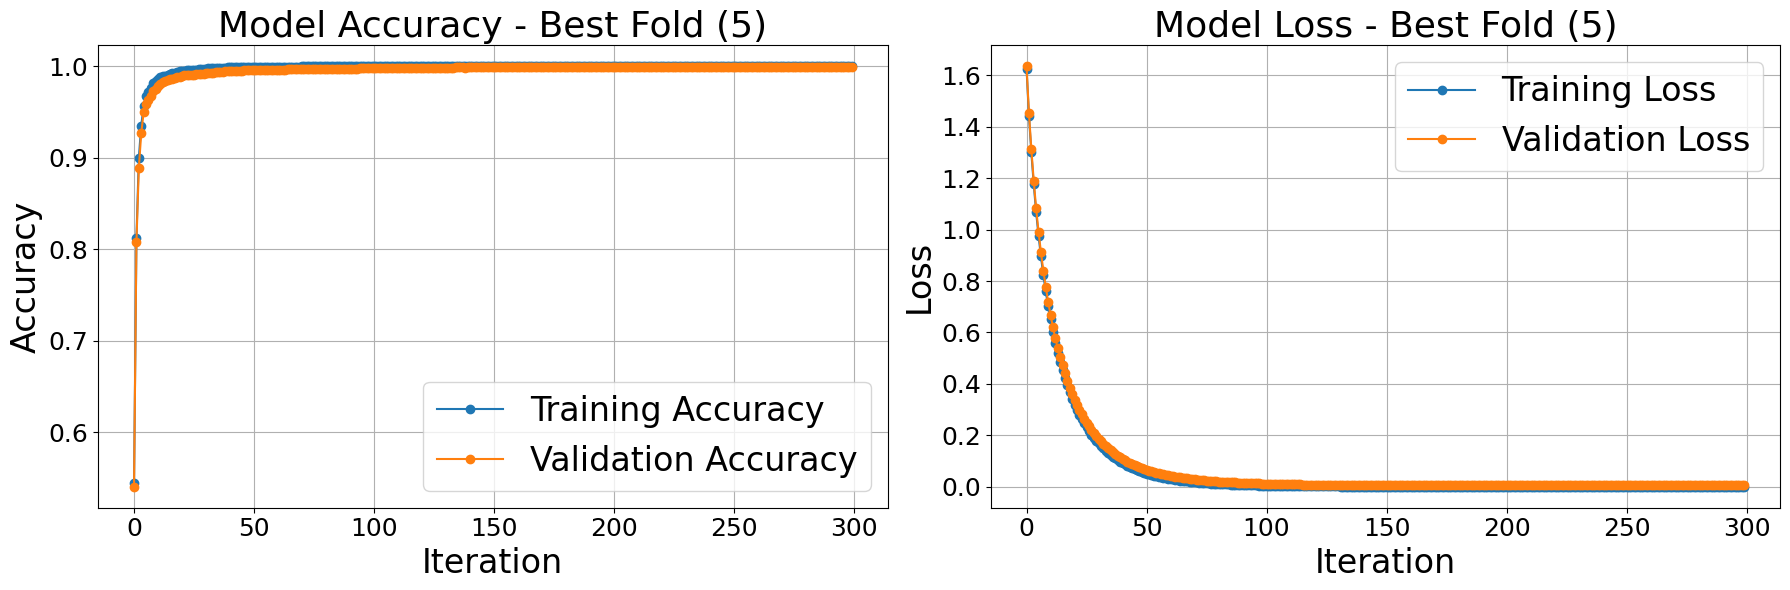


Best Fold (5) Final Metrics:
Training Accuracy: 1.0000
Validation Accuracy: 0.9991
Training Loss: 0.0000
Validation Loss: 0.0047

Improvements:
Training Accuracy Improvement: 0.4551 (83.51%)
Validation Accuracy Improvement: 0.4585 (84.82%)
Training Loss Reduction: 1.6262 (100.00%)
Validation Loss Reduction: 1.6304 (99.71%)

====== Class-Wise Metrics Across CV Folds ======
Per-Class Metrics Averaged Across All CV Folds:
                     Class  Precision  Recall/Sensitivity  F1-Score  \
0          Healthy_control     0.9999              0.9994    0.9996   
1                 anterior     0.9990              0.9981    0.9985   
2           antero-lateral     0.9968              0.9991    0.9980   
3            antero-septal     0.9984              0.9985    0.9984   
4     antero-septo-lateral     1.0000              0.9954    0.9977   
5                 inferior     0.9984              0.9984    0.9984   
6           infero-lateral     0.9982              0.9986    0.9984   
7       

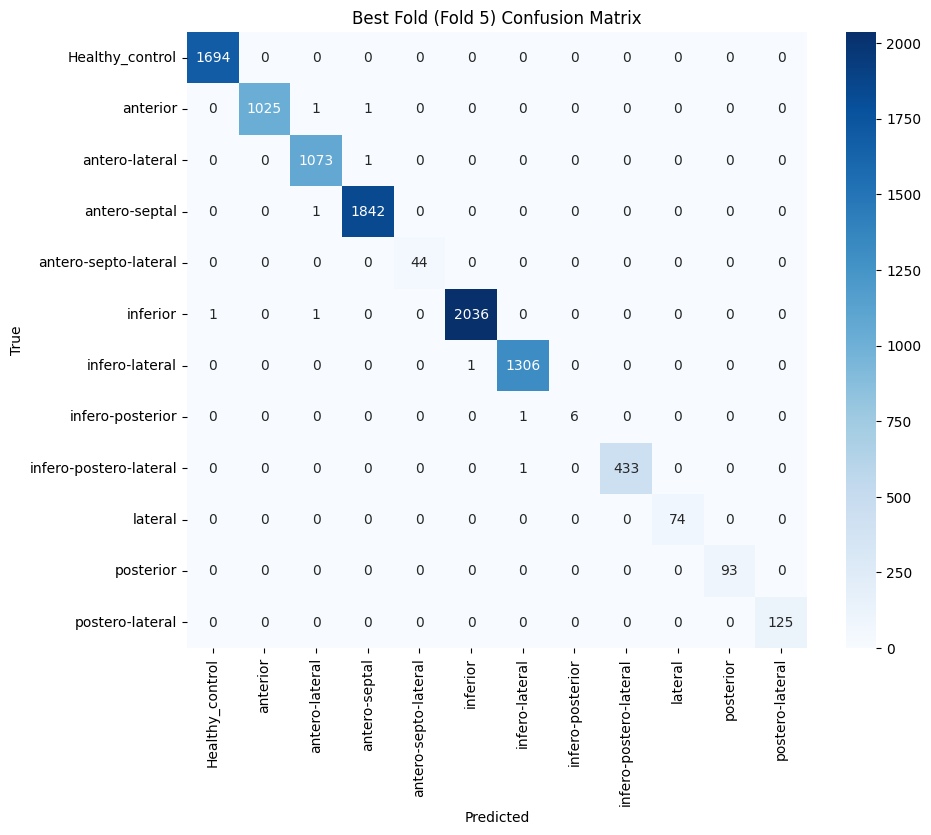

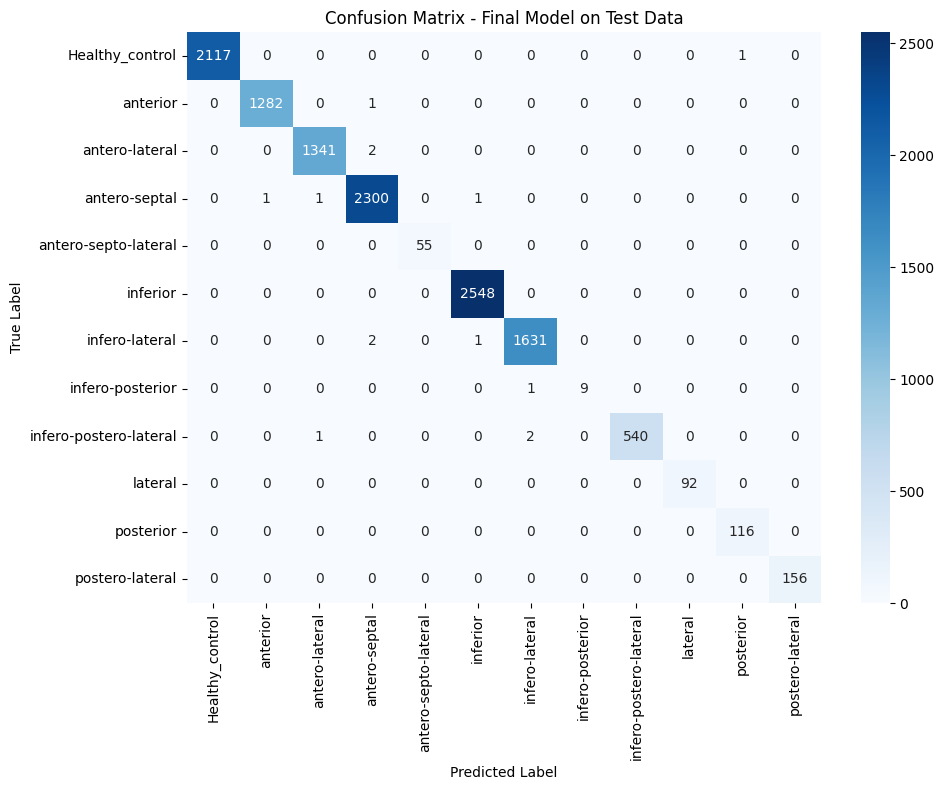

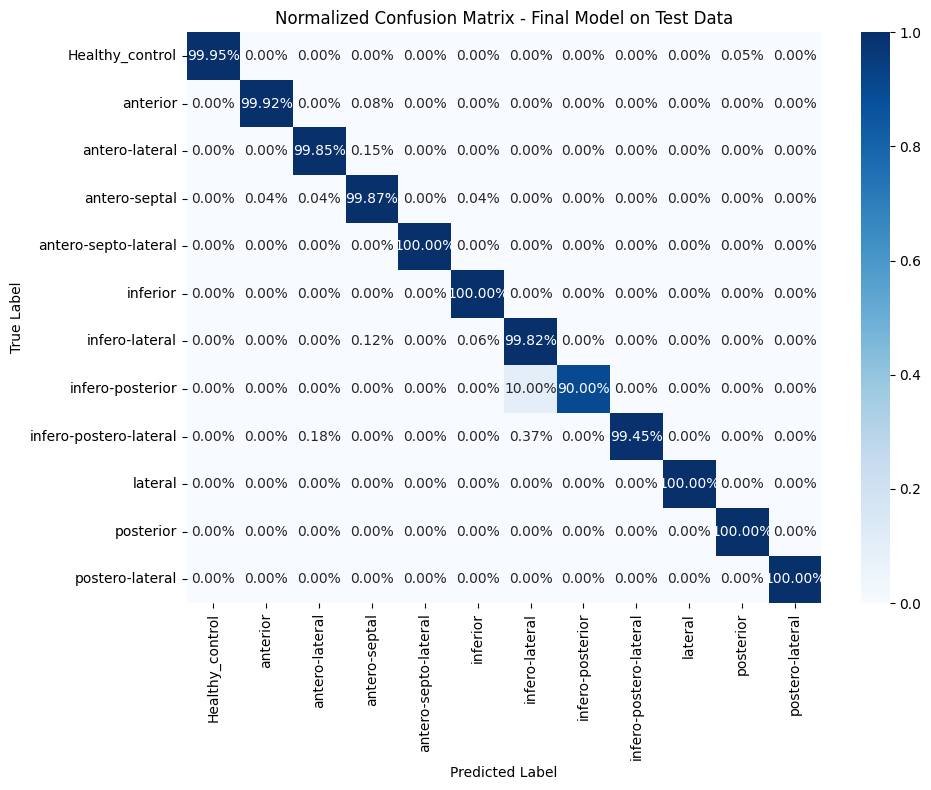


Confusion Matrix Analysis:

Class: Healthy_control
True Positive: 2117
Total Actual: 2118
Total Predicted as Healthy_control: 2117
Recall (Sensitivity): 0.9995
Precision: 1.0000

Class: anterior
True Positive: 1282
Total Actual: 1283
Total Predicted as anterior: 1283
Recall (Sensitivity): 0.9992
Precision: 0.9992

Class: antero-lateral
True Positive: 1341
Total Actual: 1343
Total Predicted as antero-lateral: 1343
Recall (Sensitivity): 0.9985
Precision: 0.9985

Class: antero-septal
True Positive: 2300
Total Actual: 2303
Total Predicted as antero-septal: 2305
Recall (Sensitivity): 0.9987
Precision: 0.9978

Class: antero-septo-lateral
True Positive: 55
Total Actual: 55
Total Predicted as antero-septo-lateral: 55
Recall (Sensitivity): 1.0000
Precision: 1.0000

Class: inferior
True Positive: 2548
Total Actual: 2548
Total Predicted as inferior: 2550
Recall (Sensitivity): 1.0000
Precision: 0.9992

Class: infero-lateral
True Positive: 1631
Total Actual: 1634
Total Predicted as infero-lateral:

In [4]:
file_path = r'D:\TA_baru\dataset\all_label_extracted_features.xlsx'  # Adjust to your file path
df = pd.read_excel(file_path)

# Run classification with cross-validation
results = ensemble_boosting_classification(df)

XGBoost

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import xgboost as xgb
import time

# Function to perform hyperparameter tuning using RandomizedSearchCV
def perform_hyperparameter_tuning(X_train, y_train, num_classes):
    print("\n=== Starting Hyperparameter Tuning for XGBoost ===")
    xgb_clf = xgb.XGBClassifier(objective='multi:softprob',
                                num_class=num_classes,
                                random_state=42,
                                n_jobs=-1,
                                eval_metric='mlogloss') 
    param_distributions = {
        'n_estimators': [300], 
        'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
        'max_depth': [3, 4, 5, 6, 7, 8, 10], 
        'min_child_weight': [1, 3, 5, 7, 10], 
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], 
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0], 
        'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5], 
        'reg_alpha': [0, 0.01, 0.1, 0.5, 1.0], 
        'reg_lambda': [0, 0.01, 0.1, 0.5, 1.0], 
        'scale_pos_weight': [1],
    }
    
    cv_tuning = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    random_search = RandomizedSearchCV(estimator=xgb_clf, 
                                       param_distributions=param_distributions,
                                       n_iter=50, 
                                       cv=cv_tuning, 
                                       scoring='f1_weighted', 
                                       verbose=2, 
                                       random_state=42,
                                       n_jobs=-1)
    
    # Perform the search
    search_start_time = time.time()
    random_search.fit(X_train, y_train)
    search_end_time = time.time()
    
    print(f"\nHyperparameter tuning completed in {(search_end_time - search_start_time):.2f} seconds.")
    print(f"Best parameters found: {random_search.best_params_}")
    print(f"Best cross-validation F1-weighted score: {random_search.best_score_:.4f}")
    
    return random_search.best_params_

def XGBoost_classification(df):
    # Prepare data
    X = df.drop(columns=["segment_id", "label"])
    y = df["label"]

    # Handle missing values by filling with 0 (can be customized)
    X = X.fillna(0)

    # Encode categorical labels into numerical format
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Scale numerical features using StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split data into training and testing sets
    X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded = train_test_split(
        X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    print("\n=== XGBoost Classification with 5-Fold Cross-Validation ===")
    
    # Perform hyperparameter tuning to find the best parameters
    num_classes = len(np.unique(y_encoded))
    perform_hyperparameter_tuning(X_train_scaled, y_train_encoded, num_classes)

# Main
file_path = r'D:\TA_baru\dataset\all_label_extracted_features.xlsx' 

# Run classification with cross-validation and hyperparameter tuning
results = XGBoost_classification(df)



=== XGBoost Classification with 5-Fold Cross-Validation ===

=== Starting Hyperparameter Tuning for XGBoost ===
Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\Fauzan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [20:15:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)



Hyperparameter tuning completed in 1153.09 seconds.
Best parameters found: {'subsample': 0.8, 'scale_pos_weight': 1, 'reg_lambda': 0.5, 'reg_alpha': 0.01, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.15, 'gamma': 0, 'colsample_bytree': 0.8}
Best cross-validation F1-weighted score: 0.9980


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, roc_curve, auc
import xgboost as xgb
import time

def XGBoost_classification(df):
    # Prepare data
    X = df.drop(columns=["segment_id", "label"])
    y = df["label"]

    # Handle missing values
    X = X.fillna(0)

    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded = train_test_split(
        X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    # Dictionary to store all results
    results = {
        'models': {},
        'predictions': {},
        'metrics': {}
    }
    
    # XGBoost Classification with optimized parameters
    print("\n=== XGBoost Classification with Optimized Parameters and 5-Fold Cross-Validation ===")
    # Modified to include test data as parameters 
    xgb_model, xgb_metrics, cv_results = train_xgboost_with_cv(
        X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, le
    )
    
    results['models']['xgboost'] = xgb_model
    results['metrics']['xgboost'] = xgb_metrics
    results['cv_results'] = cv_results
    
    # Calculate and display class-wise metrics
    calculate_class_wise_metrics(results['cv_results'], le)
    
    plot_cv_results(cv_results, le)

    # Plot confusion matrix for final model on test data
    plot_final_confusion_matrix(y_test_encoded, results['metrics']['xgboost']['predictions'], le)
    
    # Calculate class-wise metrics for test data (ADDED)
    calculate_test_class_wise_metrics(y_test_encoded, results['metrics']['xgboost']['predictions'], le)
    
    return results

def train_xgboost_with_cv(X_train, y_train, X_test, y_test, label_encoder):
    # Get number of unique classes
    num_classes = len(np.unique(y_train))
    
    # Initialize the cross-validation splitter
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # XGBoost parameters with optimized hyperparameters from tuning
    xgb_params = {
        'objective': 'multi:softprob',  # For multiclass probability output
        'num_class': num_classes,
        'eval_metric': 'mlogloss',      # Multi-class log loss
        'verbosity': 0,                 # Suppress verbose output
        
        # Optimized hyperparameters from tuning
        'learning_rate': 0.15,          # Learning rate (eta)
        'max_depth': 7,                 # Maximum depth of trees
        'min_child_weight': 1,          # Minimum sum of instance weight needed in a child
        'gamma': 0,                     # Minimum loss reduction required to make split
        'subsample': 0.8,               # Subsample ratio of the training instances
        'colsample_bytree': 0.8,        # Subsample ratio of columns when constructing each tree
        'reg_alpha': 0.01,              # L1 regularization term on weights
        'reg_lambda': 0.5,              # L2 regularization term on weights
        'scale_pos_weight': 1,          # Control the balance of positive and negative weights
        
        # Additional parameters for stability
        'random_state': 42,             # Random seed for reproducibility
    }
    
    # Number of boosting rounds from hyperparameter tuning
    num_boost_round = 300  # n_estimators from tuning results
    
    # Perform cross-validation and store results
    cv_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrices': [],
        'fold_models': [],
        'fold_predictions': [],
        'fold_probabilities': [],
        'y_true': [],  
        'y_pred': [],  
        'class_reports': [],
        'train_accuracy': [], # Track training accuracy for each fold
        'val_accuracy': [],   # Track validation accuracy for each fold
        'train_loss': [],     # Track training loss for each fold
        'val_loss': [],       # Track validation loss for each fold
        'best_fold_history': None # Will store training history for best fold
    }
    
    print("\nUsing optimized parameters:")
    print(f"Learning Rate: {xgb_params['learning_rate']}")
    print(f"Max Depth: {xgb_params['max_depth']}")
    print(f"N Estimators: {num_boost_round}")
    print(f"Subsample: {xgb_params['subsample']}")
    print(f"Colsample Bytree: {xgb_params['colsample_bytree']}")
    print(f"Reg Alpha: {xgb_params['reg_alpha']}")
    print(f"Reg Lambda: {xgb_params['reg_lambda']}")
    print(f"Min Child Weight: {xgb_params['min_child_weight']}")
    print(f"Gamma: {xgb_params['gamma']}")
    print(f"Scale Pos Weight: {xgb_params['scale_pos_weight']}")
    print("\nPerforming 5-fold cross-validation on training data:")
    
    fold_num = 1
    best_fold = 0
    best_accuracy = 0
    best_fold_model = None
    
    # Track start time for entire training process
    start_time = time.time()
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
        
        # Create XGBoost DMatrix for training
        dtrain = xgb.DMatrix(X_fold_train, label=y_fold_train)
        dval = xgb.DMatrix(X_fold_val, label=y_fold_val)
        
        # Dictionary to store training history
        history = {
            'train_accuracy': [],
            'val_accuracy': [],
            'train_loss': [],
            'val_loss': []
        }
        
        # Evaluation list for tracking training progress
        evallist = [(dtrain, 'train'), (dval, 'eval')]
        
        # Store evaluation results
        evals_result = {}
        
        # Train the XGBoost model on this fold with optimized parameters
        fold_model = xgb.train(
            xgb_params,
            dtrain,
            num_boost_round=num_boost_round,  # Use optimized number of estimators
            evals=evallist,
            evals_result=evals_result,
            verbose_eval=100,    # Suppress training output
        )
        
        # Extract training history from evals_result
        history['train_loss'] = evals_result['train']['mlogloss']
        history['val_loss'] = evals_result['eval']['mlogloss']
        
        # Calculate actual number of iterations used (in case of early stopping)
        actual_iterations = len(history['train_loss'])
        
        # Calculate accuracy for each iteration (approximate)
        for i in range(actual_iterations):
            # Get predictions at this iteration
            train_pred_prob = fold_model.predict(dtrain, iteration_range=(0, i+1))
            val_pred_prob = fold_model.predict(dval, iteration_range=(0, i+1))
            
            # Convert probabilities to class predictions
            train_pred = np.argmax(train_pred_prob, axis=1)
            val_pred = np.argmax(val_pred_prob, axis=1)
            
            # Calculate accuracy
            train_acc = accuracy_score(y_fold_train, train_pred)
            val_acc = accuracy_score(y_fold_val, val_pred)
            
            history['train_accuracy'].append(train_acc)
            history['val_accuracy'].append(val_acc)
        
        # Final evaluation on training set
        train_pred_prob = fold_model.predict(dtrain)
        train_pred = np.argmax(train_pred_prob, axis=1)
        train_accuracy = accuracy_score(y_fold_train, train_pred)
        cv_results['train_accuracy'].append(train_accuracy)
        
        # Final evaluation on validation set
        val_pred_prob = fold_model.predict(dval)
        val_pred = np.argmax(val_pred_prob, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_fold_val, val_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_fold_val, val_pred, average='weighted')
        cm = confusion_matrix(y_fold_val, val_pred)
        
        # Store validation accuracy and loss
        cv_results['val_accuracy'].append(accuracy)
        cv_results['train_loss'].append(history['train_loss'][-1])
        cv_results['val_loss'].append(history['val_loss'][-1])
        
        # Store classification report as a dictionary
        class_report = classification_report(y_fold_val, val_pred, output_dict=True)
        
        # Store results for this fold
        cv_results['accuracy'].append(accuracy)
        cv_results['precision'].append(precision)
        cv_results['recall'].append(recall)
        cv_results['f1'].append(f1)
        cv_results['conf_matrices'].append(cm)
        cv_results['fold_models'].append(fold_model)
        cv_results['fold_predictions'].append(val_pred)
        cv_results['fold_probabilities'].append(val_pred_prob)
        cv_results['y_true'].append(y_fold_val)
        cv_results['y_pred'].append(val_pred)
        cv_results['class_reports'].append(class_report)
        
        # Track the best fold based on validation accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_fold = fold_num - 1  # Using 0-based indexing for arrays
            # Store training history for the best fold
            cv_results['best_fold_history'] = history
            best_fold_model = fold_model
        
        # Show results with 4 decimal places
        print(f"Fold {fold_num}: Train Accuracy={train_accuracy:.4f}, Val Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")
        print(f"  Iterations used: {actual_iterations}/{num_boost_round}")
        fold_num += 1
    
    # Calculate mean and std of all metrics across folds
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        mean_val = np.mean(cv_results[metric])
        std_val = np.std(cv_results[metric])
        print(f"Mean {metric}: {mean_val:.4f} (±{std_val:.4f})")
    
    # Use the best fold model for final evaluation
    print(f"\nBest model found in fold {best_fold + 1} with validation accuracy of {best_accuracy:.4f}")
    final_model = best_fold_model
    
    # Evaluate the best fold model on the test set
    dtest = xgb.DMatrix(X_test)
    test_prob = final_model.predict(dtest)
    test_pred = np.argmax(test_prob, axis=1)
    
    # Calculate final metrics on test set
    training_time = time.time() - start_time
    metrics = evaluate_classifier(y_test, test_pred, test_prob, label_encoder, training_time)
    
    # Add predictions to metrics for confusion matrix plotting
    metrics['predictions'] = test_pred
    
    # Display test set results
    print(f"\nFinal Training Time: {training_time:.4f} seconds")
    print("\nFinal model evaluation on test set (20% of data):")
    print(classification_report(y_test, test_pred, target_names=label_encoder.classes_, digits=4))
    
    # Display feature importance from the best model
    print("\nTop 10 Feature Importances from Best Model:")
    feature_importance = final_model.get_score(importance_type='weight')
    sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:10]
    for feature, importance in sorted_features:
        print(f"{feature}: {importance}")
    
    # Plot accuracy and loss for the best fold
    plot_accuracy_loss_curves(cv_results['best_fold_history'], best_fold)
    
    return final_model, metrics, cv_results

def evaluate_classifier(y_true, y_pred, y_prob, label_encoder, training_time=None):
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create metrics dictionary - REMOVED ROC metrics
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'training_time': training_time,
        # Add class-wise metrics
        'class_report': classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)
    }
    
    return metrics

def plot_cv_results(cv_results, label_encoder):
    class_names = label_encoder.classes_
    
    best_fold = np.argmax(cv_results['accuracy'])
    best_cm = cv_results['conf_matrices'][best_fold]
    plt.figure(figsize=(10, 8))
    sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title(f'Best Fold (Fold {best_fold + 1}) Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('best_fold_confusion_matrix_XGBoost_Tuning.png')

def plot_final_confusion_matrix(y_true, y_pred, label_encoder):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Get class names
    class_names = label_encoder.classes_
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title('Confusion Matrix - Final Model on Test Data')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('final_model_confusion_matrix_XGBoost_Tuning.png')
    plt.show()
    
    # Calculate and display normalized confusion matrix (percentage)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title('Normalized Confusion Matrix - Final Model on Test Data')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('final_model_normalized_confusion_matrix_XGBoost_Tuning.png')
    plt.show()
    
    # Print additional information
    print("\nConfusion Matrix Analysis:")
    for i, class_name in enumerate(class_names):
        true_positive = cm[i, i]
        total_actual = np.sum(cm[i, :])
        total_predicted = np.sum(cm[:, i])
        print(f"\nClass: {class_name}")
        print(f"True Positive: {true_positive}")
        print(f"Total Actual: {total_actual}")
        print(f"Total Predicted as {class_name}: {total_predicted}")
        if total_actual > 0:
            print(f"Recall (Sensitivity): {true_positive/total_actual:.4f}")
        if total_predicted > 0:
            print(f"Precision: {true_positive/total_predicted:.4f}")

def plot_accuracy_loss_curves(history, best_fold):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot accuracy
    ax1.plot(history['train_accuracy'], label='Training Accuracy', marker='o')
    ax1.plot(history['val_accuracy'], label='Validation Accuracy', marker='o')
    ax1.set_title(f'Model Accuracy - Best Fold ({best_fold + 1}) ', fontsize=26)
    ax1.set_xlabel('Iteration', fontsize=26)
    ax1.set_ylabel('Accuracy', fontsize=26)
    ax1.legend(fontsize=26)
    ax1.tick_params(axis='both', which='major', labelsize=20)
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history['train_loss'], label='Training Loss', marker='o')
    ax2.plot(history['val_loss'], label='Validation Loss', marker='o')
    ax2.set_title(f'Model Loss - Best Fold ({best_fold + 1}) ', fontsize=26)
    ax2.set_xlabel('Iteration', fontsize=26)
    ax2.set_ylabel('Loss', fontsize=26)
    ax2.legend(fontsize=26)
    ax2.tick_params(axis='both', which='major', labelsize=20)
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('best_fold_accuracy_loss_curves_XGBoost_Tuning.png')
    plt.show()
    
    # Print final metrics for best fold
    print(f"\nBest Fold ({best_fold + 1}) Final Metrics:")
    print(f"Training Accuracy: {history['train_accuracy'][-1]:.4f}")
    print(f"Validation Accuracy: {history['val_accuracy'][-1]:.4f}")
    print(f"Training Loss: {history['train_loss'][-1]:.4f}")
    print(f"Validation Loss: {history['val_loss'][-1]:.4f}")
    
    # Calculate improvements
    first_train_acc = history['train_accuracy'][0]
    last_train_acc = history['train_accuracy'][-1]
    train_acc_improvement = last_train_acc - first_train_acc
    
    first_val_acc = history['val_accuracy'][0]
    last_val_acc = history['val_accuracy'][-1]
    val_acc_improvement = last_val_acc - first_val_acc
    
    first_train_loss = history['train_loss'][0]
    last_train_loss = history['train_loss'][-1]
    train_loss_reduction = first_train_loss - last_train_loss
    
    first_val_loss = history['val_loss'][0]
    last_val_loss = history['val_loss'][-1]
    val_loss_reduction = first_val_loss - last_val_loss
    
    print("\nImprovements:")
    print(f"Training Accuracy Improvement: {train_acc_improvement:.4f} ({train_acc_improvement/first_train_acc*100:.2f}%)")
    print(f"Validation Accuracy Improvement: {val_acc_improvement:.4f} ({val_acc_improvement/first_val_acc*100:.2f}%)")
    print(f"Training Loss Reduction: {train_loss_reduction:.4f} ({train_loss_reduction/first_train_loss*100:.2f}%)")
    print(f"Validation Loss Reduction: {val_loss_reduction:.4f} ({val_loss_reduction/first_val_loss*100:.2f}%)")

def calculate_class_wise_metrics(cv_results, label_encoder):
    print("\n====== Class-Wise Metrics Across CV Folds ======")
    
    # Concatenate results from all folds
    all_y_true = np.concatenate([y for y in cv_results['y_true']])
    all_y_pred = np.concatenate([y for y in cv_results['y_pred']])
    
    # Calculate per-class metrics across all folds
    class_report = classification_report(all_y_true, all_y_pred, 
                                         target_names=label_encoder.classes_, 
                                         output_dict=True)
    
    # Create DataFrame for better formatting
    classes = label_encoder.classes_
    class_metrics = pd.DataFrame({
        'Class': classes,
        'Precision': [class_report[c]['precision'] for c in classes],
        'Recall/Sensitivity': [class_report[c]['recall'] for c in classes],
        'F1-Score': [class_report[c]['f1-score'] for c in classes],
        'Support': [class_report[c]['support'] for c in classes]
    })
    
    # Add per-class accuracy
    accuracies = []
    for i, class_name in enumerate(classes):
        # For each class, accuracy is:
        # (true positives + true negatives) / (total samples)
        true_class = (all_y_true == i)
        pred_class = (all_y_pred == i)
        
        tp = np.sum(true_class & pred_class)  # True positives
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        total = len(all_y_true)
        
        accuracy = (tp + tn) / total
        accuracies.append(accuracy)
    
    class_metrics['Accuracy'] = accuracies
    
    # Add specificity (true negative rate)
    specificities = []
    for i, class_name in enumerate(classes):
        true_class = (all_y_true == i)  
        pred_class = (all_y_pred == i)
        
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        fp = np.sum(~true_class & pred_class)   # False positives
        
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificities.append(specificity)
    
    class_metrics['Specificity'] = specificities
    
    # Calculate per-fold metrics for each class
    fold_metrics = []
    for fold in range(len(cv_results['y_true'])):
        fold_y_true = cv_results['y_true'][fold]
        fold_y_pred = cv_results['y_pred'][fold]
        
        # Get classification report for this fold
        fold_report = classification_report(fold_y_true, fold_y_pred, 
                                           target_names=label_encoder.classes_,
                                           output_dict=True)
        
        # Extract class metrics
        for i, class_name in enumerate(classes):
            # Calculate class accuracy for this fold
            true_class = (fold_y_true == i)
            pred_class = (fold_y_pred == i)
            
            tp = np.sum(true_class & pred_class)  # True positives
            tn = np.sum(~true_class & ~pred_class)  # True negatives
            total = len(fold_y_true)
            
            accuracy = (tp + tn) / total
            
            # Calculate specificity
            tn = np.sum(~true_class & ~pred_class)  # True negatives
            fp = np.sum(~true_class & pred_class)   # False positives
            
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            
            fold_metrics.append({
                'Fold': fold + 1,
                'Class': class_name,
                'Precision': fold_report[class_name]['precision'],
                'Recall/Sensitivity': fold_report[class_name]['recall'], 
                'F1-Score': fold_report[class_name]['f1-score'],
                'Support': fold_report[class_name]['support'],
                'Accuracy': accuracy,
                'Specificity': specificity
            })
    
    # Create DataFrame with all fold results
    fold_df = pd.DataFrame(fold_metrics)
    
    # Display average metrics across all folds with 4 decimal places
    pd.set_option('display.float_format', '{:.4f}'.format)
    print("Per-Class Metrics Averaged Across All CV Folds (Optimized Parameters):")
    print(class_metrics)
    
    # Save to CSV
    class_metrics.to_csv('class_wise_metrics_cv_XGBoost_Tuning.csv', index=False)
    fold_df.to_csv('class_wise_metrics_by_fold_XGBoost_Tuning.csv', index=False)
    
    # Display detailed results for each class by fold
    for class_name in classes:
        print(f"\nDetailed metrics for class '{class_name}' across folds:")
        class_fold_data = fold_df[fold_df['Class'] == class_name]
        
        # Calculate mean and std for each metric
        metrics_summary = {}
        for metric in ['Precision', 'Recall/Sensitivity', 'F1-Score', 'Accuracy', 'Specificity']:
            mean_val = class_fold_data[metric].mean()
            std_val = class_fold_data[metric].std()
            metrics_summary[metric] = f"{mean_val:.4f} (±{std_val:.4f})"
        
        # Print summary
        for metric, value in metrics_summary.items():
            print(f"{metric}: {value}")

def calculate_test_class_wise_metrics(y_true, y_pred, label_encoder):
    """Calculate detailed class-wise metrics for test data"""
    print("\n====== Class-Wise Metrics on Test Data ======")
    
    # Calculate per-class metrics on test data
    class_report = classification_report(y_true, y_pred, 
                                        target_names=label_encoder.classes_, 
                                        output_dict=True)
    
    # Create DataFrame for better formatting
    classes = label_encoder.classes_
    test_class_metrics = pd.DataFrame({
        'Class': classes,
        'Precision': [class_report[c]['precision'] for c in classes],
        'Recall/Sensitivity': [class_report[c]['recall'] for c in classes],
        'F1-Score': [class_report[c]['f1-score'] for c in classes],
        'Support': [class_report[c]['support'] for c in classes]
    })
    
    # Add per-class accuracy
    accuracies = []
    for i, class_name in enumerate(classes):
        # For each class, accuracy is:
        # (true positives + true negatives) / (total samples)
        true_class = (y_true == i)
        pred_class = (y_pred == i)
        
        tp = np.sum(true_class & pred_class)  # True positives
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        total = len(y_true)
        
        accuracy = (tp + tn) / total
        accuracies.append(accuracy)
    
    test_class_metrics['Accuracy'] = accuracies
    
    # Add specificity (true negative rate)
    specificities = []
    for i, class_name in enumerate(classes):
        true_class = (y_true == i)  
        pred_class = (y_pred == i)
        
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        fp = np.sum(~true_class & pred_class)   # False positives
        
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificities.append(specificity)
    
    test_class_metrics['Specificity'] = specificities
    
    # Calculate additional useful metrics for each class
    npvs = []  # Negative Predictive Values
    balanced_accuracies = []  # Balanced Accuracy (mean of sensitivity and specificity)
    
    for i, class_name in enumerate(classes):
        true_class = (y_true == i)
        pred_class = (y_pred == i)
        
        tp = np.sum(true_class & pred_class)  # True positives
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        fp = np.sum(~true_class & pred_class)  # False positives
        fn = np.sum(true_class & ~pred_class)  # False negatives
        
        # Negative Predictive Value = TN / (TN + FN)
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        npvs.append(npv)
        
        # Sensitivity (Recall)
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        # Specificity (already calculated)
        specificity = specificities[i]
        
        # Balanced Accuracy
        bal_acc = (sensitivity + specificity) / 2
        balanced_accuracies.append(bal_acc)
    
    test_class_metrics['NPV'] = npvs
    test_class_metrics['Balanced_Accuracy'] = balanced_accuracies
    
    # Display test metrics with 4 decimal places
    pd.set_option('display.float_format', '{:.4f}'.format)
    print("Per-Class Metrics on Test Data:")
    print(test_class_metrics)
    
    # Save to CSV
    test_class_metrics.to_csv('test_class_wise_metrics_XGBoost_Tuning.csv', index=False)
    
    # Calculate and print overall metrics on test set
    print("\nOverall Test Metrics:")
    overall_accuracy = accuracy_score(y_true, y_pred)
    overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted'
    )
    print(f"Accuracy: {overall_accuracy:.4f}")
    print(f"Weighted Precision: {overall_precision:.4f}")
    print(f"Weighted Recall: {overall_recall:.4f}")
    print(f"Weighted F1-Score: {overall_f1:.4f}")
    
    # Additional diagnostics for each class
    print("\nDetailed Per-Class Analysis on Test Set:")
    for i, class_name in enumerate(classes):
        true_class = (y_true == i)
        pred_class = (y_pred == i)
        
        tp = np.sum(true_class & pred_class)  # True positives
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        fp = np.sum(~true_class & pred_class)  # False positives
        fn = np.sum(true_class & ~pred_class)  # False negatives
        
        print(f"\nClass: {class_name}")
        print(f"True Positives: {tp}")
        print(f"False Positives: {fp}")
        print(f"True Negatives: {tn}")
        print(f"False Negatives: {fn}")
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"Precision: {precision:.4f}")
        print(f"Recall/Sensitivity: {recall:.4f}")
        print(f"Specificity: {specificity:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1-Score: {f1:.4f}")
        
    return test_class_metrics



=== XGBoost Classification with Optimized Parameters and 5-Fold Cross-Validation ===

Using optimized parameters:
Learning Rate: 0.15
Max Depth: 7
N Estimators: 300
Subsample: 0.8
Colsample Bytree: 0.8
Reg Alpha: 0.01
Reg Lambda: 0.5
Min Child Weight: 1
Gamma: 0
Scale Pos Weight: 1

Performing 5-fold cross-validation on training data:
[0]	train-mlogloss:1.81368	eval-mlogloss:1.82584
[100]	train-mlogloss:0.00107	eval-mlogloss:0.00888
[200]	train-mlogloss:0.00039	eval-mlogloss:0.00761
[299]	train-mlogloss:0.00029	eval-mlogloss:0.00736
Fold 1: Train Accuracy=1.0000, Val Accuracy=0.9983, Precision=0.9983, Recall=0.9983, F1=0.9983
  Iterations used: 300/300
[0]	train-mlogloss:1.82185	eval-mlogloss:1.82919
[100]	train-mlogloss:0.00109	eval-mlogloss:0.00814
[200]	train-mlogloss:0.00040	eval-mlogloss:0.00645
[299]	train-mlogloss:0.00029	eval-mlogloss:0.00608
Fold 2: Train Accuracy=1.0000, Val Accuracy=0.9983, Precision=0.9983, Recall=0.9983, F1=0.9983
  Iterations used: 300/300
[0]	train-mlog

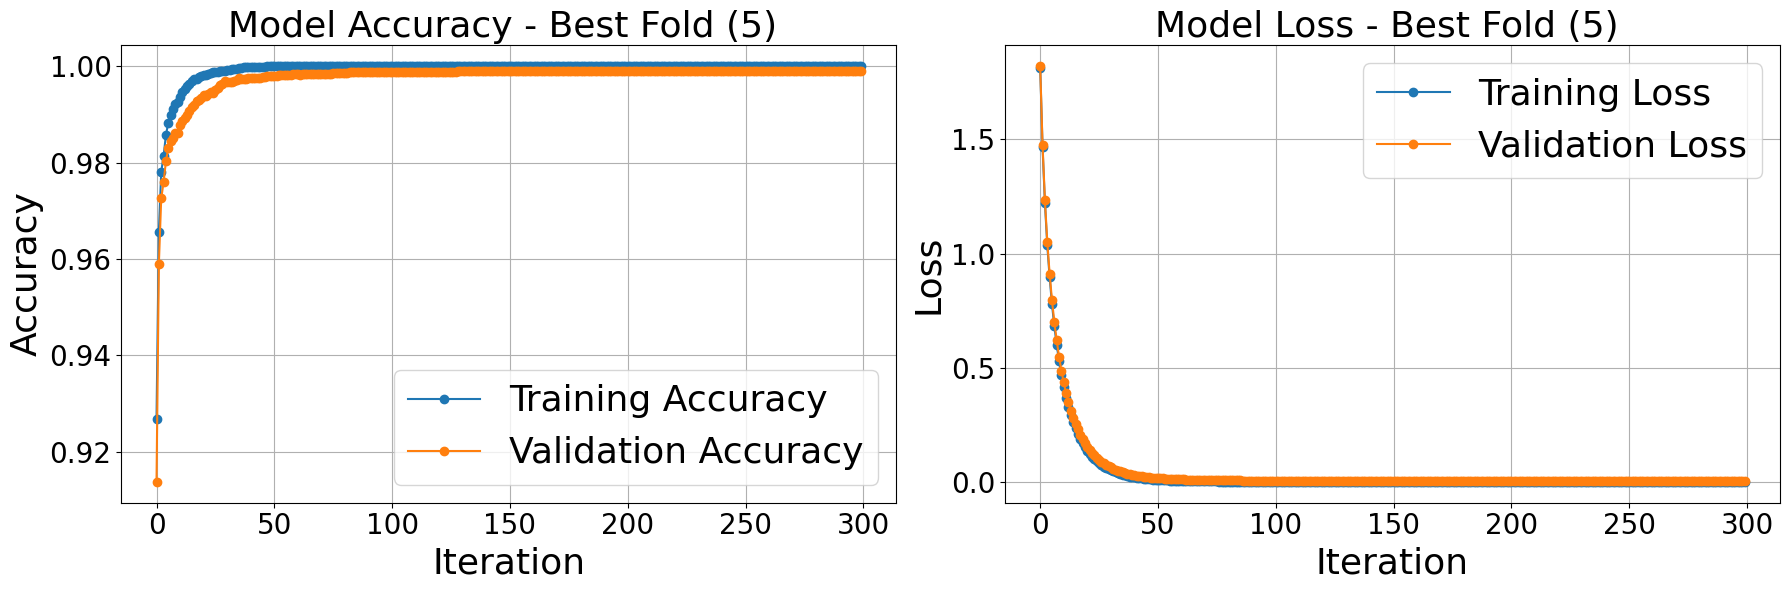


Best Fold (5) Final Metrics:
Training Accuracy: 1.0000
Validation Accuracy: 0.9991
Training Loss: 0.0003
Validation Loss: 0.0038

Improvements:
Training Accuracy Improvement: 0.0733 (7.90%)
Validation Accuracy Improvement: 0.0853 (9.34%)
Training Loss Reduction: 1.8136 (99.98%)
Validation Loss Reduction: 1.8173 (99.79%)

====== Class-Wise Metrics Across CV Folds ======
Per-Class Metrics Averaged Across All CV Folds (Optimized Parameters):
                     Class  Precision  Recall/Sensitivity  F1-Score  \
0          Healthy_control     0.9998              0.9991    0.9994   
1                 anterior     0.9986              0.9971    0.9979   
2           antero-lateral     0.9965              0.9993    0.9979   
3            antero-septal     0.9982              0.9978    0.9980   
4     antero-septo-lateral     0.9954              0.9863    0.9908   
5                 inferior     0.9975              0.9984    0.9980   
6           infero-lateral     0.9983              0.9983  

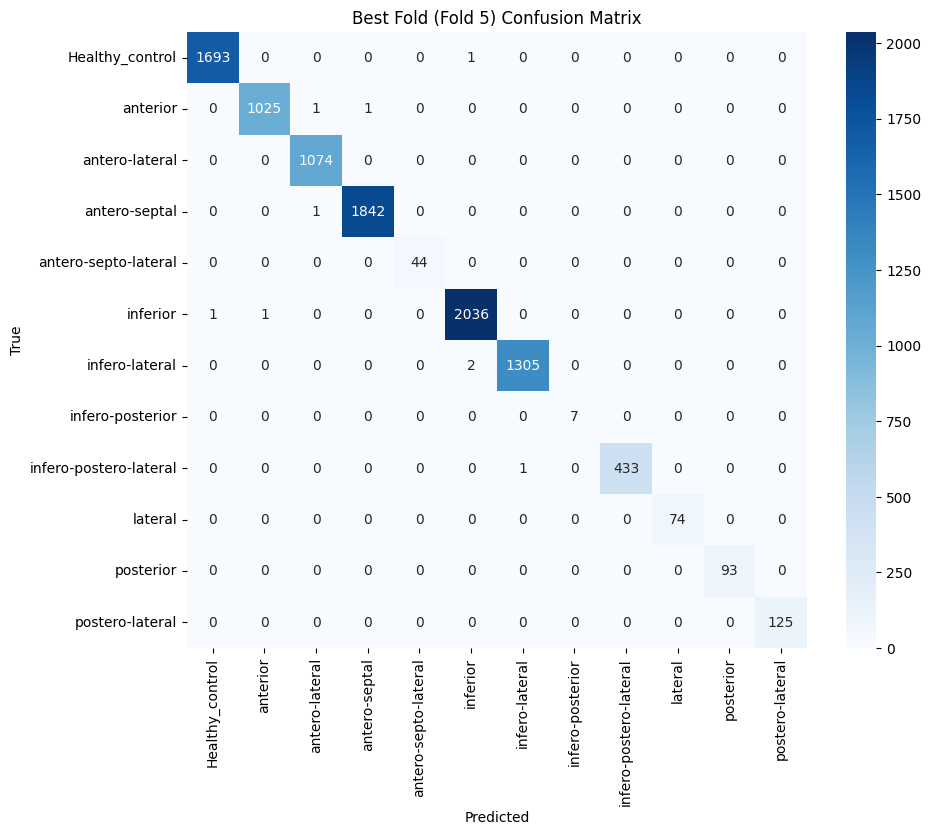

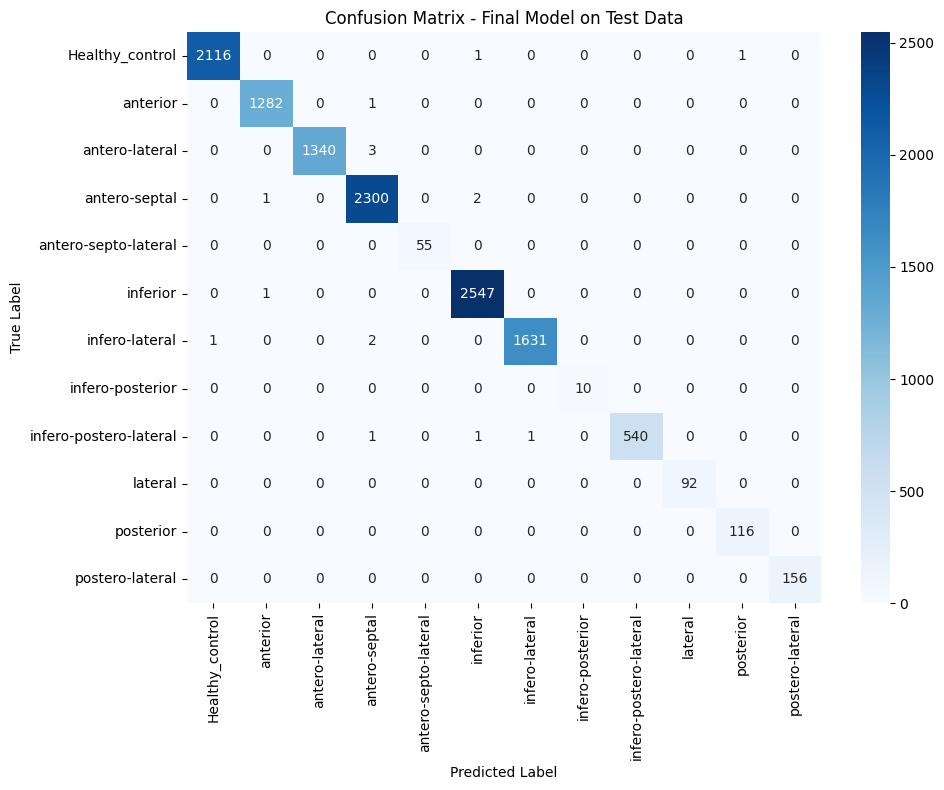

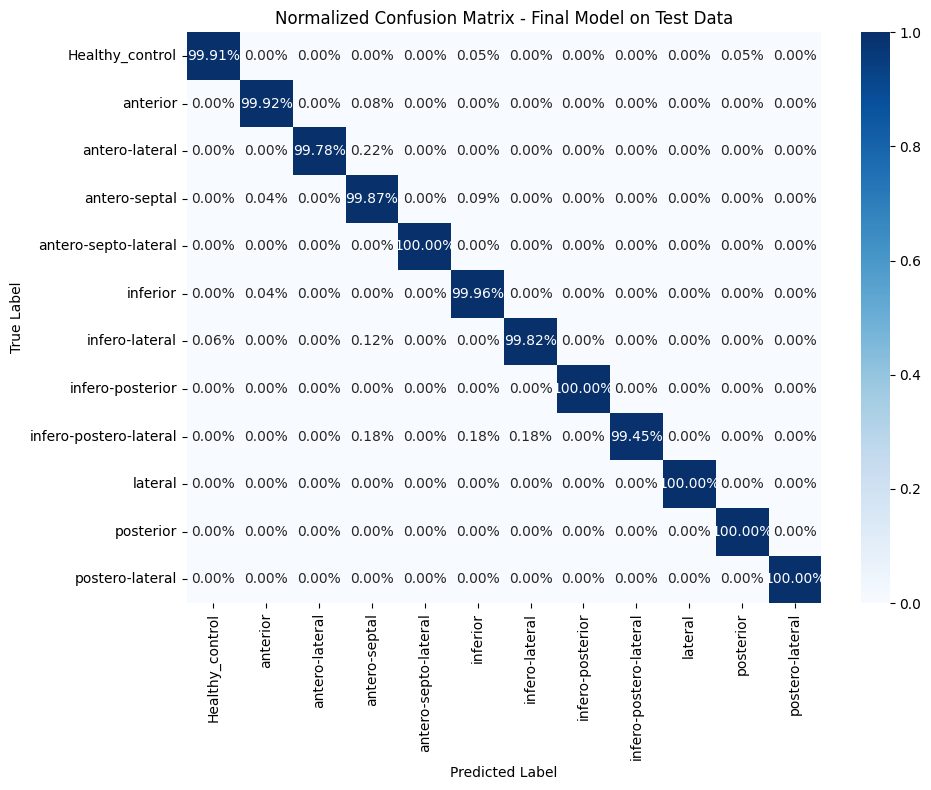


Confusion Matrix Analysis:

Class: Healthy_control
True Positive: 2116
Total Actual: 2118
Total Predicted as Healthy_control: 2117
Recall (Sensitivity): 0.9991
Precision: 0.9995

Class: anterior
True Positive: 1282
Total Actual: 1283
Total Predicted as anterior: 1284
Recall (Sensitivity): 0.9992
Precision: 0.9984

Class: antero-lateral
True Positive: 1340
Total Actual: 1343
Total Predicted as antero-lateral: 1340
Recall (Sensitivity): 0.9978
Precision: 1.0000

Class: antero-septal
True Positive: 2300
Total Actual: 2303
Total Predicted as antero-septal: 2307
Recall (Sensitivity): 0.9987
Precision: 0.9970

Class: antero-septo-lateral
True Positive: 55
Total Actual: 55
Total Predicted as antero-septo-lateral: 55
Recall (Sensitivity): 1.0000
Precision: 1.0000

Class: inferior
True Positive: 2547
Total Actual: 2548
Total Predicted as inferior: 2551
Recall (Sensitivity): 0.9996
Precision: 0.9984

Class: infero-lateral
True Positive: 1631
Total Actual: 1634
Total Predicted as infero-lateral:

In [20]:
# Load data
file_path = r'D:\TA_baru\dataset\all_label_extracted_features.xlsx'  # Adjust to your file path
df = pd.read_excel(file_path)

# Run classification with cross-validation
results = XGBoost_classification(df)

AdaBoost

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, log_loss
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import time

# Function to perform hyperparameter tuning using RandomizedSearchCV
def perform_hyperparameter_tuning(X_train, y_train, num_classes):
    print("\n=== Starting Hyperparameter Tuning for AdaBoost ===")
    
    # Initialize AdaBoostClassifier
    ada_clf = AdaBoostClassifier(random_state=42)
    
    # Define the parameter distribution for RandomizedSearchCV
    # These ranges can be adjusted based on initial results or domain knowledge
    param_distributions = {
        'n_estimators': [300], # Number of estimators
        'learning_rate': [0.01, 0.1, 0.5, 1.0, 1.5, 2.0], # Learning rate
        'algorithm': ['SAMME', 'SAMME.R'], # AdaBoost algorithm
        'estimator__max_depth': [1, 2, 3, 4, 5], # Max depth of base decision tree
        'estimator__min_samples_split': [2, 5, 10, 20], # Min samples to split
        'estimator__min_samples_leaf': [1, 2, 5, 10], # Min samples in leaf
        'estimator__max_features': [None, 'sqrt', 'log2'], # Max features for base estimator
    }
    
    # Create base estimator (Decision Tree)
    base_estimator = DecisionTreeClassifier(random_state=42)
    ada_clf.set_params(estimator=base_estimator)
    
    # Set up StratifiedKFold for cross-validation during tuning
    # Using fewer splits (e.g., 3) for tuning to save time, as it's computationally intensive
    cv_tuning = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(estimator=ada_clf, 
                                       param_distributions=param_distributions,
                                       n_iter=50, # Number of random combinations to try
                                       cv=cv_tuning, 
                                       scoring='f1_weighted', 
                                       verbose=2, 
                                       random_state=42,
                                       n_jobs=-1)
    
    # Perform the search
    search_start_time = time.time()
    random_search.fit(X_train, y_train)
    search_end_time = time.time()
    
    print(f"\nHyperparameter tuning completed in {(search_end_time - search_start_time):.2f} seconds.")
    print(f"Best parameters found: {random_search.best_params_}")
    print(f"Best cross-validation F1-weighted score: {random_search.best_score_:.4f}")
    
    return random_search.best_params_

def AdaBoost_classification(df):
    
    # Prepare data
    X = df.drop(columns=["segment_id", "label"])
    y = df["label"]

    # Handle missing values by filling with 0 (can be customized)
    X = X.fillna(0)

    # Encode categorical labels into numerical format
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Scale numerical features using StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split data into training and testing sets
    # stratify=y_encoded ensures that the proportion of classes is the same in train and test sets
    X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded = train_test_split(
        X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    # Dictionary to store all results
    results = {
        'models': {},
        'predictions': {},
        'metrics': {}
    }
    
    print("\n=== AdaBoost Classification with 5-Fold Cross-Validation ===")
    
    # Perform hyperparameter tuning to find the best parameters
    num_classes = len(np.unique(y_encoded))
    perform_hyperparameter_tuning(X_train_scaled, y_train_encoded, num_classes)
    
# Main

file_path = r'D:\TA_baru\dataset\all_label_extracted_features.xlsx' 

df = pd.read_excel(file_path)
results = AdaBoost_classification(df)



=== AdaBoost Classification with 5-Fold Cross-Validation ===

=== Starting Hyperparameter Tuning for AdaBoost ===
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Hyperparameter tuning completed in 3978.76 seconds.
Best parameters found: {'n_estimators': 300, 'learning_rate': 0.1, 'estimator__min_samples_split': 5, 'estimator__min_samples_leaf': 1, 'estimator__max_features': 'sqrt', 'estimator__max_depth': 5, 'algorithm': 'SAMME'}
Best cross-validation F1-weighted score: 0.9882


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import time

def AdaBoost_classification(df):
    # Prepare data
    X = df.drop(columns=["segment_id", "label"])
    y = df["label"]

    # Handle missing values
    X = X.fillna(0)

    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded = train_test_split(
        X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    # Dictionary to store all results
    results = {
        'models': {},
        'predictions': {},
        'metrics': {}
    }
    
    # AdaBoost Classification
    print("\n=== AdaBoost Classification with 5-Fold Cross-Validation (Tuned Parameters) ===")
    # Modified to include test data as parameters 
    ada_model, ada_metrics, cv_results = train_adaboost_with_cv(
        X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, le
    )
    
    results['models']['adaboost'] = ada_model
    results['metrics']['adaboost'] = ada_metrics
    results['cv_results'] = cv_results
    
    # Calculate and display class-wise metrics
    calculate_class_wise_metrics(results['cv_results'], le)
    
    plot_cv_results(cv_results,le)

    # Plot confusion matrix for final model on test data
    plot_final_confusion_matrix(y_test_encoded, results['metrics']['adaboost']['predictions'], le)
    
    # Calculate class-wise metrics for test data (ADDED)
    calculate_test_class_wise_metrics(y_test_encoded, results['metrics']['adaboost']['predictions'], le)
    
    return results

def train_adaboost_with_cv(X_train, y_train, X_test, y_test, label_encoder):
    num_classes = len(np.unique(y_train))
    
    # Initialize the cross-validation splitter
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # AdaBoost parameters - UPDATED WITH TUNED PARAMETERS
    # Using tuned parameters from hyperparameter optimization
    base_estimator = DecisionTreeClassifier(
        max_depth=5,                    # estimator__max_depth: 5
        min_samples_split=5,           # estimator__min_samples_split: 5
        min_samples_leaf=1,            # estimator__min_samples_leaf: 1
        max_features='sqrt',           # estimator__max_features: 'sqrt'
        random_state=42
    )
    
    ada_params = {
        'estimator': base_estimator,
        'n_estimators': 300,           # n_estimators: 300 (increased from 100)
        'learning_rate': 0.1,          # learning_rate: 0.1 (added learning rate)
        'algorithm': 'SAMME',          # algorithm: 'SAMME' (forced to SAMME)
        'random_state': 42
    }
    
    print(f"Using tuned AdaBoost parameters:")
    print(f"  - n_estimators: {ada_params['n_estimators']}")
    print(f"  - learning_rate: {ada_params['learning_rate']}")
    print(f"  - algorithm: {ada_params['algorithm']}")
    print(f"  - Base estimator max_depth: {base_estimator.max_depth}")
    print(f"  - Base estimator min_samples_split: {base_estimator.min_samples_split}")
    print(f"  - Base estimator min_samples_leaf: {base_estimator.min_samples_leaf}")
    print(f"  - Base estimator max_features: {base_estimator.max_features}")
    
    # Perform cross-validation and store results
    cv_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrices': [],
        'fold_models': [],
        'fold_predictions': [],
        'fold_probabilities': [],
        'y_true': [],  
        'y_pred': [],  
        'class_reports': [],
        'train_accuracy': [], # Track training accuracy for each fold
        'val_accuracy': [],   # Track validation accuracy for each fold
        'train_loss': [],     # Track training loss for each fold
        'val_loss': [],       # Track validation loss for each fold
        'best_fold_history': None # Will store training history for best fold
    }
    
    print("\nPerforming 5-fold cross-validation on training data:")
    fold_num = 1
    best_fold = 0
    best_accuracy = 0
    best_fold_model = None
    
    # Track start time for entire training process
    start_time = time.time()
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
        
        # Create AdaBoost classifier with tuned parameters
        fold_model = AdaBoostClassifier(**ada_params)
        
        # Dictionary to store training history for staged predictions
        history = {
            'train_accuracy': [],
            'val_accuracy': [],
            'train_loss': [],
            'val_loss': []
        }
        
        # Train the model
        fold_model.fit(X_fold_train, y_fold_train)
        
        # Get staged predictions to track training progress
        train_staged_pred = list(fold_model.staged_predict(X_fold_train))
        val_staged_pred = list(fold_model.staged_predict(X_fold_val))
        
        # Calculate metrics for each stage
        for stage_idx in range(len(train_staged_pred)):
            # Training accuracy
            train_acc = accuracy_score(y_fold_train, train_staged_pred[stage_idx])
            
            # Validation accuracy
            val_acc = accuracy_score(y_fold_val, val_staged_pred[stage_idx])
            
            # Calculate loss as simple error rate (1 - accuracy)
            # This ensures loss decreases as accuracy increases
            train_loss = 1 - train_acc
            val_loss = 1 - val_acc
            
            # Store metrics
            history['train_accuracy'].append(train_acc)
            history['val_accuracy'].append(val_acc)
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
        
        # Final predictions for this fold
        y_train_pred = fold_model.predict(X_fold_train)
        train_accuracy = accuracy_score(y_fold_train, y_train_pred)
        cv_results['train_accuracy'].append(train_accuracy)
        
        # Predict on validation set
        y_pred = fold_model.predict(X_fold_val)
        
        # Get probabilities for validation set
        if hasattr(fold_model, "predict_proba"):
            y_val_prob = fold_model.predict_proba(X_fold_val)
        else:
            # If predict_proba is not available, use decision function
            decision_scores = fold_model.decision_function(X_fold_val)
            if num_classes == 2:
                # Binary classification
                y_val_prob = np.column_stack([1 - 1/(1 + np.exp(-decision_scores)), 
                                             1/(1 + np.exp(-decision_scores))])
            else:
                # Multiclass - convert decision function to probabilities
                exp_scores = np.exp(decision_scores)
                y_val_prob = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        # Calculate metrics
        accuracy = accuracy_score(y_fold_val, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_fold_val, y_pred, average='weighted')
        cm = confusion_matrix(y_fold_val, y_pred)
        
        # Store validation accuracy and loss (take the last values)
        cv_results['val_accuracy'].append(accuracy)
        cv_results['train_loss'].append(history['train_loss'][-1])
        cv_results['val_loss'].append(history['val_loss'][-1])
        
        # Store classification report as a dictionary
        class_report = classification_report(y_fold_val, y_pred, output_dict=True)
        
        # Store results for this fold
        cv_results['accuracy'].append(accuracy)
        cv_results['precision'].append(precision)
        cv_results['recall'].append(recall)
        cv_results['f1'].append(f1)
        cv_results['conf_matrices'].append(cm)
        cv_results['fold_models'].append(fold_model)
        cv_results['fold_predictions'].append(y_pred)
        cv_results['fold_probabilities'].append(y_val_prob)
        cv_results['y_true'].append(y_fold_val)
        cv_results['y_pred'].append(y_pred)
        cv_results['class_reports'].append(class_report)
        
        # Track the best fold based on validation accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_fold = fold_num - 1  # Using 0-based indexing for arrays
            # Store training history for the best fold
            cv_results['best_fold_history'] = history
            best_fold_model = fold_model
        
        # Show results with 4 decimal places
        print(f"Fold {fold_num}: Train Accuracy={train_accuracy:.4f}, Val Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")
        fold_num += 1
    
    # Calculate mean and std of all metrics across folds
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        mean_val = np.mean(cv_results[metric])
        std_val = np.std(cv_results[metric])
        print(f"Mean {metric}: {mean_val:.4f} (±{std_val:.4f})")
    
    # Use the best fold model for final evaluation
    print(f"\nBest model found in fold {best_fold + 1} with validation accuracy of {best_accuracy:.4f}")
    final_model = best_fold_model
    
    # Evaluate the best fold model on the test set
    test_pred = final_model.predict(X_test)
    
    # Get test probabilities
    if hasattr(final_model, "predict_proba"):
        test_prob = final_model.predict_proba(X_test)
    else:
        # If predict_proba is not available, use decision function
        decision_scores = final_model.decision_function(X_test)
        if num_classes == 2:
            test_prob = np.column_stack([1 - 1/(1 + np.exp(-decision_scores)), 
                                        1/(1 + np.exp(-decision_scores))])
        else:
            exp_scores = np.exp(decision_scores)
            test_prob = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # Calculate final metrics on test set
    training_time = time.time() - start_time
    metrics = evaluate_classifier(y_test, test_pred, test_prob, label_encoder, training_time)
    
    # Add predictions to metrics for confusion matrix plotting
    metrics['predictions'] = test_pred
    
    # Display test set results
    print(f"\nFinal Training Time: {training_time:.4f} seconds")
    print("\nFinal model evaluation on test set (20% of data):")
    print(classification_report(y_test, test_pred, target_names=label_encoder.classes_, digits=4))
    
    # Plot accuracy and loss for the best fold
    plot_accuracy_loss_curves(cv_results['best_fold_history'], best_fold)
    
    return final_model, metrics, cv_results

def evaluate_classifier(y_true, y_pred, y_prob, label_encoder, training_time=None):
    """Evaluate classifier performance"""
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create metrics dictionary - REMOVED ROC metrics
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'training_time': training_time,
        # Add class-wise metrics
        'class_report': classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)
    }
    
    return metrics

def plot_cv_results(cv_results, label_encoder):
    # Get class names
    class_names = label_encoder.classes_
    
    # ADDITION: Plot the best fold's confusion matrix
    best_fold = np.argmax(cv_results['accuracy'])
    best_cm = cv_results['conf_matrices'][best_fold]
    plt.figure(figsize=(10, 8))
    sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title(f'Best Fold (Fold {best_fold + 1}) Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('best_fold_confusion_matrix_AdaBoost_Tuning.png')

def plot_final_confusion_matrix(y_true, y_pred, label_encoder):
    """Plot confusion matrix for final model evaluation on test data"""
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Get class names
    class_names = label_encoder.classes_
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title('Confusion Matrix - Final Model on Test Data (Tuned Parameters)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('final_model_confusion_matrix_AdaBoost_Tuning.png')
    plt.show()
    
    # Calculate and display normalized confusion matrix (percentage)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title('Normalized Confusion Matrix - Final Model on Test Data (Tuned Parameters)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('final_model_normalized_confusion_matrix_AdaBoost_Tuning.png')
    plt.show()
    
    # Print additional information
    print("\nConfusion Matrix Analysis:")
    for i, class_name in enumerate(class_names):
        true_positive = cm[i, i]
        total_actual = np.sum(cm[i, :])
        total_predicted = np.sum(cm[:, i])
        print(f"\nClass: {class_name}")
        print(f"True Positive: {true_positive}")
        print(f"Total Actual: {total_actual}")
        print(f"Total Predicted as {class_name}: {total_predicted}")
        if total_actual > 0:
            print(f"Recall (Sensitivity): {true_positive/total_actual:.4f}")
        if total_predicted > 0:
            print(f"Precision: {true_positive/total_predicted:.4f}")

def plot_accuracy_loss_curves(history, best_fold):
    """Plot accuracy and loss curves for the best fold"""
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot accuracy
    ax1.plot(history['train_accuracy'], label='Training Accuracy', marker='o', markersize=3)
    ax1.plot(history['val_accuracy'], label='Validation Accuracy', marker='o', markersize=3)
    ax1.set_title(f'Model Accuracy - Best Fold ({best_fold + 1}) - Tuned Parameters', fontsize=24)
    ax1.set_xlabel('Boosting Iteration', fontsize=26)
    ax1.set_ylabel('Accuracy', fontsize=26)
    ax1.legend(fontsize=26)
    ax1.tick_params(axis='both', which='major', labelsize=22)
    ax1.grid(True, alpha=0.3)
    
    # Plot loss
    ax2.plot(history['train_loss'], label='Training Loss', marker='o', markersize=3)
    ax2.plot(history['val_loss'], label='Validation Loss', marker='o', markersize=3)
    ax2.set_title(f'Model Loss - Best Fold ({best_fold + 1}) - Tuned Parameters', fontsize=24)
    ax2.set_xlabel('Boosting Iteration', fontsize=26)
    ax2.set_ylabel('Loss', fontsize=26)
    ax2.legend(fontsize=26)
    ax2.tick_params(axis='both', which='major', labelsize=20)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('best_fold_accuracy_loss_curves_AdaBoost_Tuning.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print final metrics for best fold
    print(f"\nBest Fold ({best_fold + 1}) Final Metrics:")
    print(f"Training Accuracy: {history['train_accuracy'][-1]:.4f}")
    print(f"Validation Accuracy: {history['val_accuracy'][-1]:.4f}")
    print(f"Training Loss: {history['train_loss'][-1]:.4f}")
    print(f"Validation Loss: {history['val_loss'][-1]:.4f}")
    
    # Calculate improvements
    first_train_acc = history['train_accuracy'][0]
    last_train_acc = history['train_accuracy'][-1]
    train_acc_improvement = last_train_acc - first_train_acc
    
    first_val_acc = history['val_accuracy'][0]
    last_val_acc = history['val_accuracy'][-1]
    val_acc_improvement = last_val_acc - first_val_acc
    
    first_train_loss = history['train_loss'][0]
    last_train_loss = history['train_loss'][-1]
    train_loss_reduction = first_train_loss - last_train_loss
    
    first_val_loss = history['val_loss'][0]
    last_val_loss = history['val_loss'][-1]
    val_loss_reduction = first_val_loss - last_val_loss
    
    print("\nImprovements:")
    print(f"Training Accuracy Improvement: {train_acc_improvement:.4f} ({train_acc_improvement/first_train_acc*100:.2f}%)")
    print(f"Validation Accuracy Improvement: {val_acc_improvement:.4f} ({val_acc_improvement/first_val_acc*100:.2f}%)")
    print(f"Training Loss Reduction: {train_loss_reduction:.4f} ({train_loss_reduction/first_train_loss*100:.2f}%)")
    print(f"Validation Loss Reduction: {val_loss_reduction:.4f} ({val_loss_reduction/first_val_loss*100:.2f}%)")
    
    # Additional analysis
    print("\nTraining Progress Analysis:")
    print(f"Initial Training Accuracy: {first_train_acc:.4f}")
    print(f"Final Training Accuracy: {last_train_acc:.4f}")
    print(f"Initial Validation Accuracy: {first_val_acc:.4f}")
    print(f"Final Validation Accuracy: {last_val_acc:.4f}")
    print(f"Initial Training Loss: {first_train_loss:.4f}")
    print(f"Final Training Loss: {last_train_loss:.4f}")
    print(f"Initial Validation Loss: {first_val_loss:.4f}")
    print(f"Final Validation Loss: {last_val_loss:.4f}")
    
    # Check for overfitting
    if last_train_acc > last_val_acc + 0.05:  # 5% threshold
        print("\nWarning: Potential overfitting detected!")
        print(f"Training accuracy ({last_train_acc:.4f}) is significantly higher than validation accuracy ({last_val_acc:.4f})")
    else:
        print("\nGood: No significant overfitting detected.")
        print(f"Training and validation accuracies are well balanced.")

def calculate_class_wise_metrics(cv_results, label_encoder):
    print("\n====== Class-Wise Metrics Across CV Folds (Tuned Parameters) ======")
    
    # Concatenate results from all folds
    all_y_true = np.concatenate([y for y in cv_results['y_true']])
    all_y_pred = np.concatenate([y for y in cv_results['y_pred']])
    
    # Calculate per-class metrics across all folds
    class_report = classification_report(all_y_true, all_y_pred, 
                                         target_names=label_encoder.classes_, 
                                         output_dict=True)
    
    # Create DataFrame for better formatting
    classes = label_encoder.classes_
    class_metrics = pd.DataFrame({
        'Class': classes,
        'Precision': [class_report[c]['precision'] for c in classes],
        'Recall/Sensitivity': [class_report[c]['recall'] for c in classes],
        'F1-Score': [class_report[c]['f1-score'] for c in classes],
        'Support': [class_report[c]['support'] for c in classes]
    })
    
    # Add per-class accuracy
    accuracies = []
    for i, class_name in enumerate(classes):
        # For each class, accuracy is:
        # (true positives + true negatives) / (total samples)
        true_class = (all_y_true == i)
        pred_class = (all_y_pred == i)
        
        tp = np.sum(true_class & pred_class)  # True positives
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        total = len(all_y_true)
        
        accuracy = (tp + tn) / total
        accuracies.append(accuracy)
    
    class_metrics['Accuracy'] = accuracies
    
    # Add specificity (true negative rate)
    specificities = []
    for i, class_name in enumerate(classes):
        true_class = (all_y_true == i)  
        pred_class = (all_y_pred == i)
        
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        fp = np.sum(~true_class & pred_class)   # False positives
        
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificities.append(specificity)
    
    class_metrics['Specificity'] = specificities
    
    # Calculate per-fold metrics for each class
    fold_metrics = []
    for fold in range(len(cv_results['y_true'])):
        fold_y_true = cv_results['y_true'][fold]
        fold_y_pred = cv_results['y_pred'][fold]
        
        # Get classification report for this fold
        fold_report = classification_report(fold_y_true, fold_y_pred, 
                                           target_names=label_encoder.classes_,
                                           output_dict=True)
        
        # Extract class metrics
        for i, class_name in enumerate(classes):
            # Calculate class accuracy for this fold
            true_class = (fold_y_true == i)
            pred_class = (fold_y_pred == i)
            
            tp = np.sum(true_class & pred_class)  # True positives
            tn = np.sum(~true_class & ~pred_class)  # True negatives
            total = len(fold_y_true)
            
            accuracy = (tp + tn) / total
            
            # Calculate specificity
            tn = np.sum(~true_class & ~pred_class)  # True negatives
            fp = np.sum(~true_class & pred_class)   # False positives
            
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            
            fold_metrics.append({
                'Fold': fold + 1,
                'Class': class_name,
                'Precision': fold_report[class_name]['precision'],
                'Recall/Sensitivity': fold_report[class_name]['recall'], 
                'F1-Score': fold_report[class_name]['f1-score'],
                'Support': fold_report[class_name]['support'],
                'Accuracy': accuracy,
                'Specificity': specificity
            })
    
    # Create DataFrame with all fold results
    fold_df = pd.DataFrame(fold_metrics)
    
    # Display average metrics across all folds with 4 decimal places
    pd.set_option('display.float_format', '{:.4f}'.format)
    print("Per-Class Metrics Averaged Across All CV Folds:")
    print(class_metrics)
    
    # Save to CSV
    class_metrics.to_csv('class_wise_metrics_cv_AdaBoost_Tuning.csv', index=False)
    fold_df.to_csv('class_wise_metrics_by_fold_AdaBoost_Tuning.csv', index=False)
    
    # Display detailed results for each class by fold
    for class_name in classes:
        print(f"\nDetailed metrics for class '{class_name}' across folds:")
        class_fold_data = fold_df[fold_df['Class'] == class_name]
        
        # Calculate mean and std for each metric
        metrics_summary = {}
        for metric in ['Precision', 'Recall/Sensitivity', 'F1-Score', 'Accuracy', 'Specificity']:
            mean_val = class_fold_data[metric].mean()
            std_val = class_fold_data[metric].std()
            metrics_summary[metric] = f"{mean_val:.4f} (±{std_val:.4f})"
        
        # Print summary
        for metric, value in metrics_summary.items():
            print(f"{metric}: {value}")

def calculate_test_class_wise_metrics(y_true, y_pred, label_encoder):
    """Calculate detailed class-wise metrics for test data"""
    print("\n====== Class-Wise Metrics on Test Data ======")
    
    # Calculate per-class metrics on test data
    class_report = classification_report(y_true, y_pred, 
                                        target_names=label_encoder.classes_, 
                                        output_dict=True)
    
    # Create DataFrame for better formatting
    classes = label_encoder.classes_
    test_class_metrics = pd.DataFrame({
        'Class': classes,
        'Precision': [class_report[c]['precision'] for c in classes],
        'Recall/Sensitivity': [class_report[c]['recall'] for c in classes],
        'F1-Score': [class_report[c]['f1-score'] for c in classes],
        'Support': [class_report[c]['support'] for c in classes]
    })
    
    # Add per-class accuracy
    accuracies = []
    for i, class_name in enumerate(classes):
        # For each class, accuracy is:
        # (true positives + true negatives) / (total samples)
        true_class = (y_true == i)
        pred_class = (y_pred == i)
        
        tp = np.sum(true_class & pred_class)  # True positives
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        total = len(y_true)
        
        accuracy = (tp + tn) / total
        accuracies.append(accuracy)
    
    test_class_metrics['Accuracy'] = accuracies
    
    # Add specificity (true negative rate)
    specificities = []
    for i, class_name in enumerate(classes):
        true_class = (y_true == i)  
        pred_class = (y_pred == i)
        
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        fp = np.sum(~true_class & pred_class)   # False positives
        
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificities.append(specificity)
    
    test_class_metrics['Specificity'] = specificities
    
    # Calculate additional useful metrics for each class
    npvs = []  # Negative Predictive Values
    balanced_accuracies = []  # Balanced Accuracy (mean of sensitivity and specificity)
    
    for i, class_name in enumerate(classes):
        true_class = (y_true == i)
        pred_class = (y_pred == i)
        
        tp = np.sum(true_class & pred_class)  # True positives
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        fp = np.sum(~true_class & pred_class)  # False positives
        fn = np.sum(true_class & ~pred_class)  # False negatives
        
        # Negative Predictive Value = TN / (TN + FN)
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        npvs.append(npv)
        
        # Sensitivity (Recall)
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        # Specificity (already calculated)
        specificity = specificities[i]
        
        # Balanced Accuracy
        bal_acc = (sensitivity + specificity) / 2
        balanced_accuracies.append(bal_acc)
    
    test_class_metrics['NPV'] = npvs
    test_class_metrics['Balanced_Accuracy'] = balanced_accuracies
    
    # Display test metrics with 4 decimal places
    pd.set_option('display.float_format', '{:.4f}'.format)
    print("Per-Class Metrics on Test Data:")
    print(test_class_metrics)
    
    # Save to CSV
    test_class_metrics.to_csv('test_class_wise_metrics_AdaBoost_Tuning.csv', index=False)
    
    # Calculate and print overall metrics on test set
    print("\nOverall Test Metrics:")
    overall_accuracy = accuracy_score(y_true, y_pred)
    overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted'
    )
    print(f"Accuracy: {overall_accuracy:.4f}")
    print(f"Weighted Precision: {overall_precision:.4f}")
    print(f"Weighted Recall: {overall_recall:.4f}")
    print(f"Weighted F1-Score: {overall_f1:.4f}")
    
    # Additional diagnostics for each class
    print("\nDetailed Per-Class Analysis on Test Set:")
    for i, class_name in enumerate(classes):
        true_class = (y_true == i)
        pred_class = (y_pred == i)
        
        tp = np.sum(true_class & pred_class)  # True positives
        tn = np.sum(~true_class & ~pred_class)  # True negatives
        fp = np.sum(~true_class & pred_class)  # False positives
        fn = np.sum(true_class & ~pred_class)  # False negatives
        
        print(f"\nClass: {class_name}")
        print(f"True Positives: {tp}")
        print(f"False Positives: {fp}")
        print(f"True Negatives: {tn}")
        print(f"False Negatives: {fn}")
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"Precision: {precision:.4f}")
        print(f"Recall/Sensitivity: {recall:.4f}")
        print(f"Specificity: {specificity:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1-Score: {f1:.4f}")
        
    return test_class_metrics


=== AdaBoost Classification with 5-Fold Cross-Validation (Tuned Parameters) ===
Using tuned AdaBoost parameters:
  - n_estimators: 300
  - learning_rate: 0.1
  - algorithm: SAMME
  - Base estimator max_depth: 5
  - Base estimator min_samples_split: 5
  - Base estimator min_samples_leaf: 1
  - Base estimator max_features: sqrt

Performing 5-fold cross-validation on training data:
Fold 1: Train Accuracy=0.9930, Val Accuracy=0.9868, Precision=0.9869, Recall=0.9868, F1=0.9868
Fold 2: Train Accuracy=0.9906, Val Accuracy=0.9853, Precision=0.9856, Recall=0.9853, F1=0.9853
Fold 3: Train Accuracy=0.9924, Val Accuracy=0.9835, Precision=0.9839, Recall=0.9835, F1=0.9835
Fold 4: Train Accuracy=0.9924, Val Accuracy=0.9892, Precision=0.9894, Recall=0.9892, F1=0.9892
Fold 5: Train Accuracy=0.9938, Val Accuracy=0.9885, Precision=0.9886, Recall=0.9885, F1=0.9885
Mean accuracy: 0.9867 (±0.0021)
Mean precision: 0.9868 (±0.0020)
Mean recall: 0.9867 (±0.0021)
Mean f1: 0.9867 (±0.0021)

Best model found in 

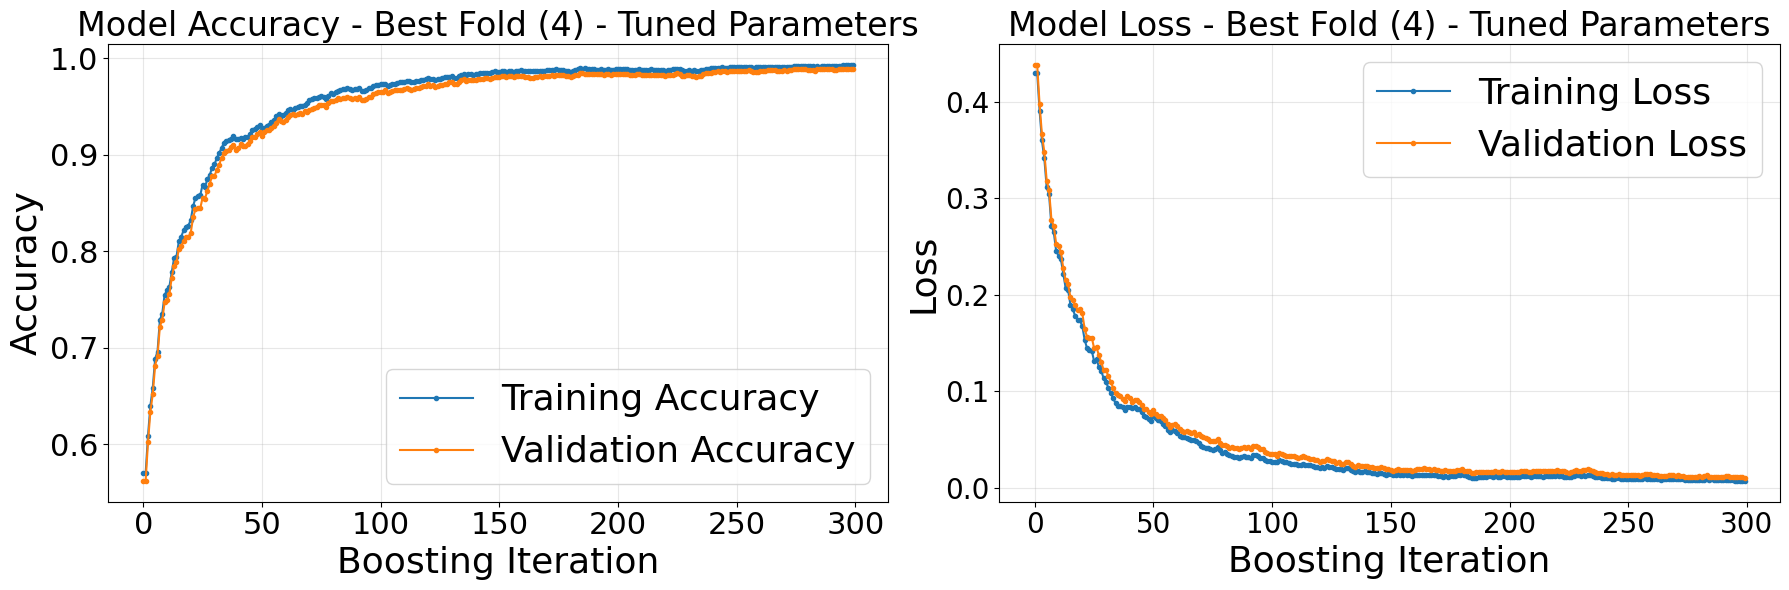


Best Fold (4) Final Metrics:
Training Accuracy: 0.9924
Validation Accuracy: 0.9892
Training Loss: 0.0076
Validation Loss: 0.0108

Improvements:
Training Accuracy Improvement: 0.4226 (74.18%)
Validation Accuracy Improvement: 0.4273 (76.03%)
Training Loss Reduction: 0.4226 (98.24%)
Validation Loss Reduction: 0.4273 (97.54%)

Training Progress Analysis:
Initial Training Accuracy: 0.5698
Final Training Accuracy: 0.9924
Initial Validation Accuracy: 0.5620
Final Validation Accuracy: 0.9892
Initial Training Loss: 0.4302
Final Training Loss: 0.0076
Initial Validation Loss: 0.4380
Final Validation Loss: 0.0108

Good: No significant overfitting detected.
Training and validation accuracies are well balanced.

====== Class-Wise Metrics Across CV Folds (Tuned Parameters) ======
Per-Class Metrics Averaged Across All CV Folds:
                     Class  Precision  Recall/Sensitivity  F1-Score  \
0          Healthy_control     0.9902              0.9945    0.9923   
1                 anterior     0.

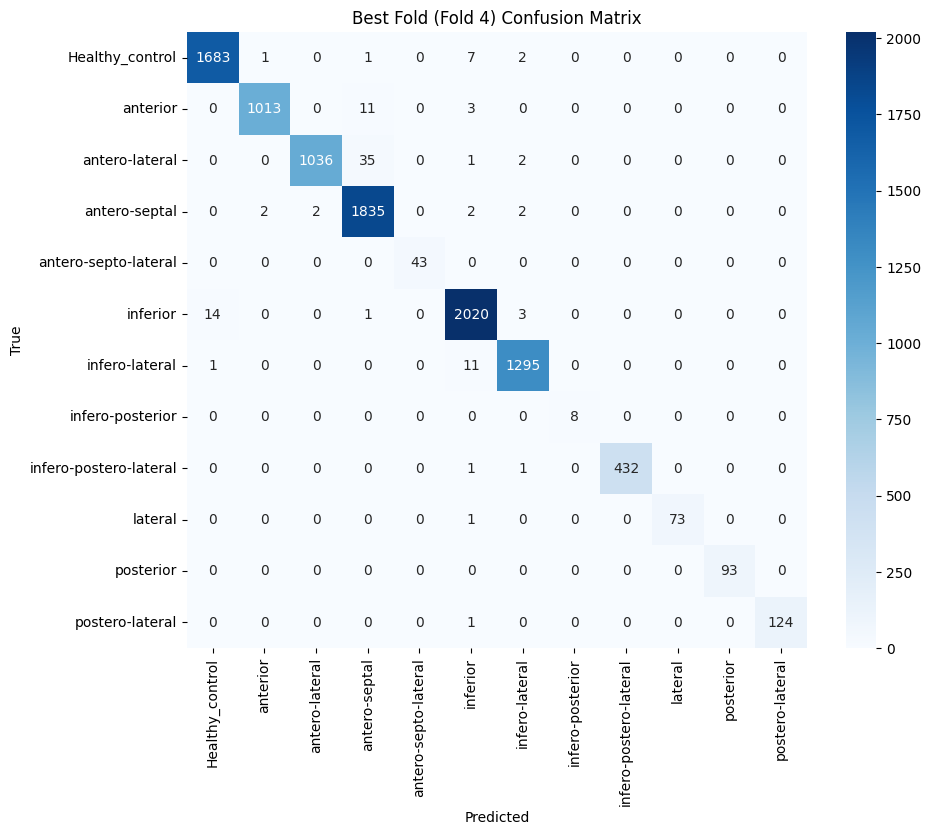

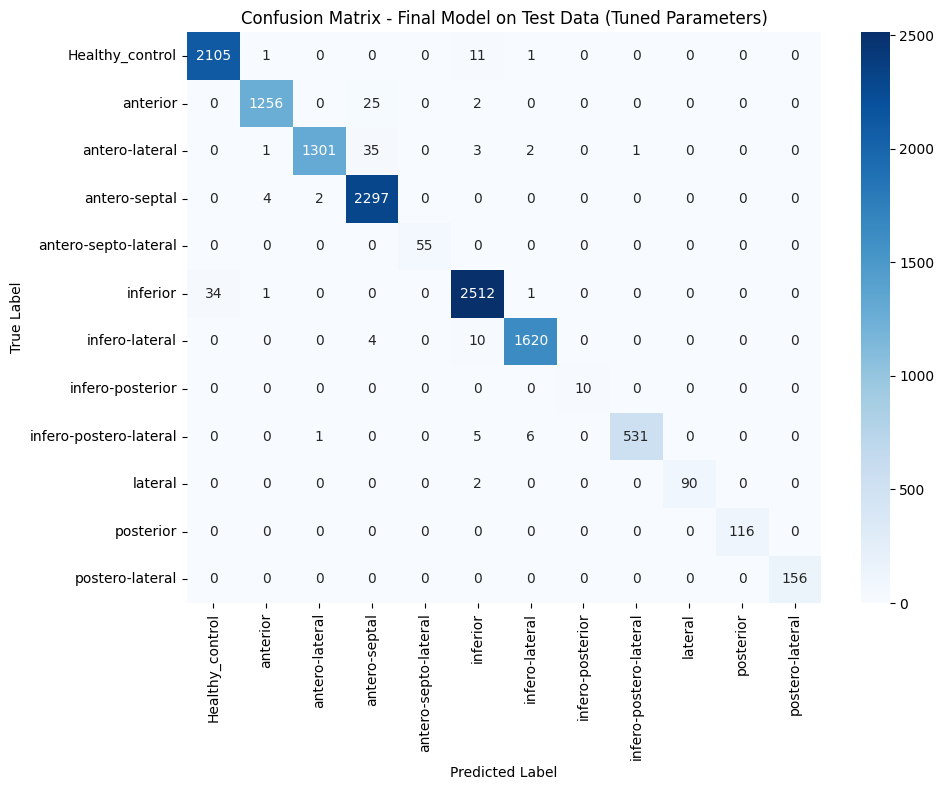

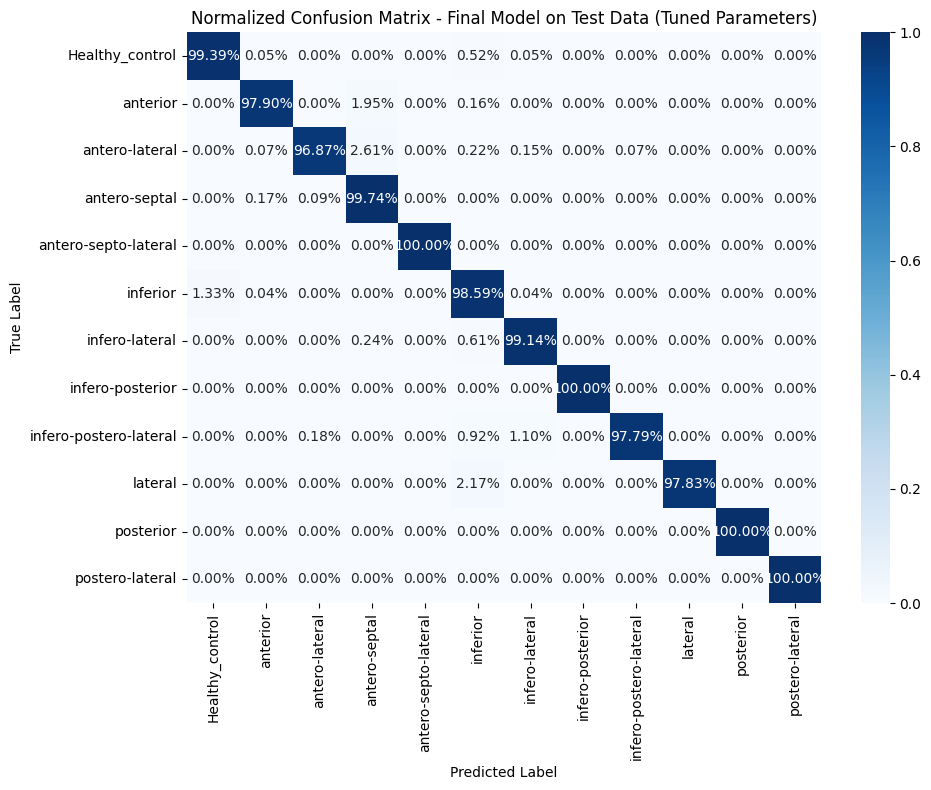


Confusion Matrix Analysis:

Class: Healthy_control
True Positive: 2105
Total Actual: 2118
Total Predicted as Healthy_control: 2139
Recall (Sensitivity): 0.9939
Precision: 0.9841

Class: anterior
True Positive: 1256
Total Actual: 1283
Total Predicted as anterior: 1263
Recall (Sensitivity): 0.9790
Precision: 0.9945

Class: antero-lateral
True Positive: 1301
Total Actual: 1343
Total Predicted as antero-lateral: 1304
Recall (Sensitivity): 0.9687
Precision: 0.9977

Class: antero-septal
True Positive: 2297
Total Actual: 2303
Total Predicted as antero-septal: 2361
Recall (Sensitivity): 0.9974
Precision: 0.9729

Class: antero-septo-lateral
True Positive: 55
Total Actual: 55
Total Predicted as antero-septo-lateral: 55
Recall (Sensitivity): 1.0000
Precision: 1.0000

Class: inferior
True Positive: 2512
Total Actual: 2548
Total Predicted as inferior: 2545
Recall (Sensitivity): 0.9859
Precision: 0.9870

Class: infero-lateral
True Positive: 1620
Total Actual: 1634
Total Predicted as infero-lateral:

In [4]:
# Load data
file_path = r'D:\TA_baru\dataset\all_label_extracted_features.xlsx'  # Adjust to your file path
df = pd.read_excel(file_path)

# Run classification with cross-validation
results = AdaBoost_classification(df)

# Plot cross-validation results
# plot_cv_results(results['cv_results'])

# Comparison Of 3 Model

Default


=== LightGBM Classification with 5-Fold Cross-Validation ===

Performing 5-fold cross-validation on training data (LightGBM):
Fold 1: Val Acc=0.9978, Prec=0.9979, Rec=0.9978, F1=0.9978
Fold 2: Val Acc=0.9981, Prec=0.9981, Rec=0.9981, F1=0.9981
Fold 3: Val Acc=0.9980, Prec=0.9980, Rec=0.9980, F1=0.9979
Fold 4: Val Acc=0.9974, Prec=0.9974, Rec=0.9974, F1=0.9974
Fold 5: Val Acc=0.9983, Prec=0.9983, Rec=0.9983, F1=0.9983
Mean accuracy: 0.9979 (±0.0003)
Mean precision: 0.9979 (±0.0003)
Mean recall: 0.9979 (±0.0003)
Mean f1: 0.9979 (±0.0003)

Best model found in fold <lightgbm.basic.Booster object at 0x000002330A895ED0> with validation accuracy of 0.9983

Final LightGBM Training Time (including CV and final fit): 38.3495 seconds

Final model evaluation on HELD-OUT TEST SET (LightGBM):
                        precision    recall  f1-score   support

       Healthy_control     1.0000    0.9995    0.9998      2118
              anterior     0.9977    1.0000    0.9988      1283
        antero-l

C:\Users\Fauzan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fauzan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fauzan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classific


Final AdaBoost Training Time (including CV and final fit): 200.9359 seconds

Final model evaluation on HELD-OUT TEST SET (AdaBoost):
                        precision    recall  f1-score   support

       Healthy_control     0.5956    0.5633    0.5790      2118
              anterior     0.3944    0.1208    0.1850      1283
        antero-lateral     0.2448    0.3574    0.2906      1343
         antero-septal     0.5016    0.5367    0.5186      2303
  antero-septo-lateral     0.0000    0.0000    0.0000        55
              inferior     0.4079    0.6240    0.4933      2548
        infero-lateral     0.4379    0.3280    0.3751      1634
      infero-posterior     0.0000    0.0000    0.0000        10
infero-postero-lateral     0.1422    0.0552    0.0796       543
               lateral     0.0000    0.0000    0.0000        92
             posterior     0.0000    0.0000    0.0000       116
       postero-lateral     0.8511    0.2564    0.3941       156

              accuracy          

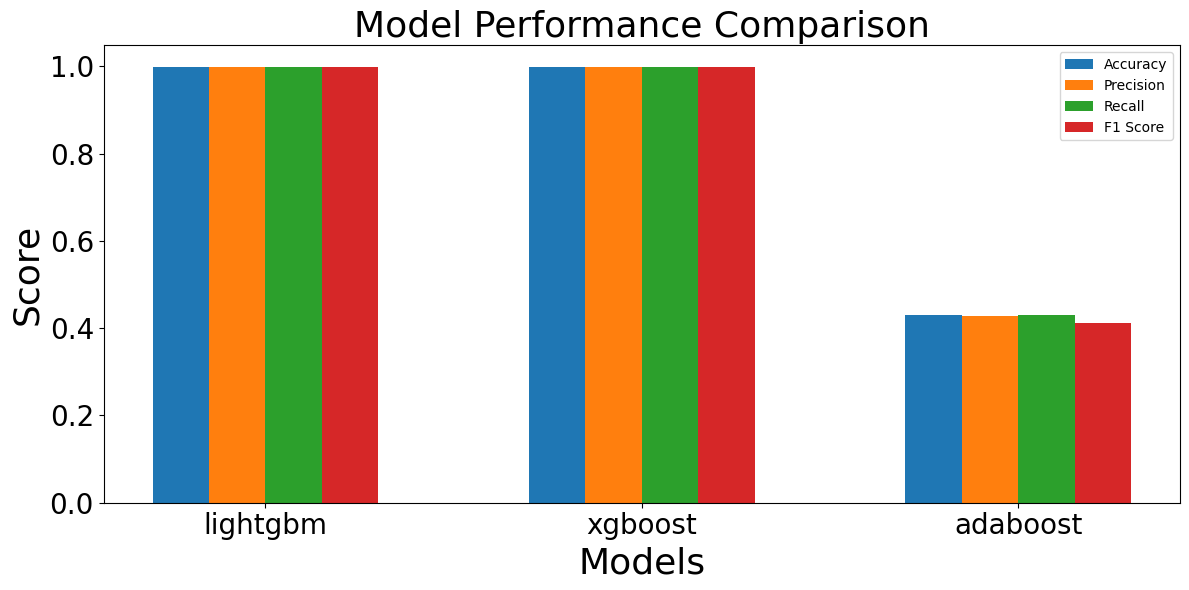

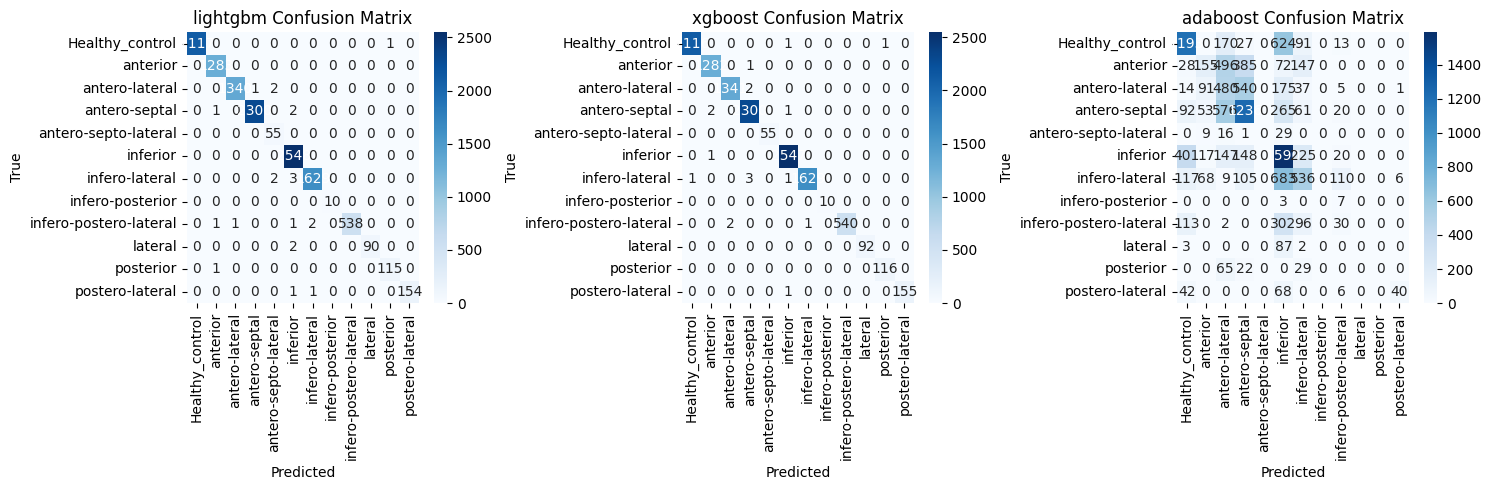

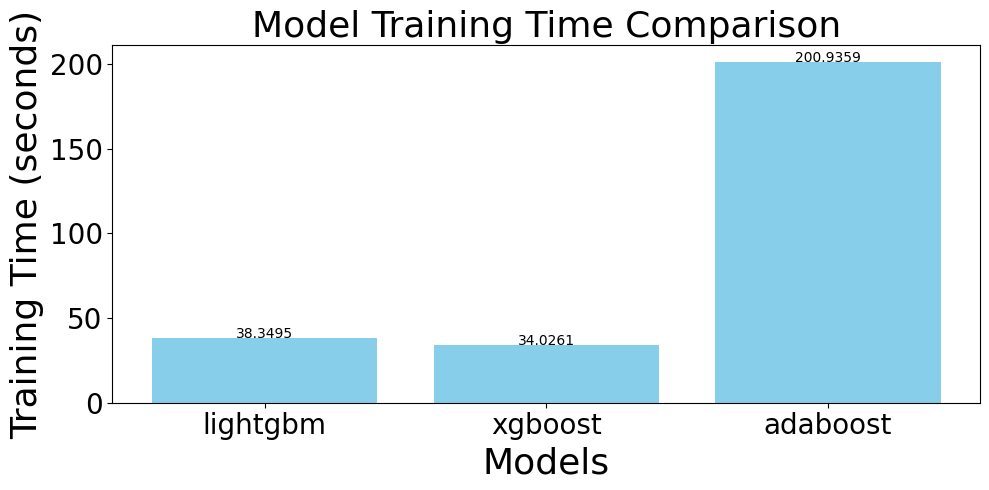


==== Class-wise Metrics for lightgbm ====
                     Class  Precision  Recall  F1-Score   Support
0          Healthy_control     1.0000  0.9995    0.9998 2118.0000
1                 anterior     0.9977  1.0000    0.9988 1283.0000
2           antero-lateral     0.9993  0.9978    0.9985 1343.0000
3            antero-septal     0.9996  0.9987    0.9991 2303.0000
4     antero-septo-lateral     0.9322  1.0000    0.9649   55.0000
5                 inferior     0.9965  1.0000    0.9982 2548.0000
6           infero-lateral     0.9982  0.9969    0.9976 1634.0000
7         infero-posterior     1.0000  1.0000    1.0000   10.0000
8   infero-postero-lateral     1.0000  0.9908    0.9954  543.0000
9                  lateral     1.0000  0.9783    0.9890   92.0000
10               posterior     0.9914  0.9914    0.9914  116.0000
11         postero-lateral     1.0000  0.9872    0.9935  156.0000

==== Class-wise Metrics for xgboost ====
                     Class  Precision  Recall  F1-Score  

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, roc_curve, auc
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import time

def ensemble_boosting_classification(df):
    # Prepare data
    X = df.drop(columns=["segment_id", "label"])
    y = df["label"]

    # Handle missing values
    X = X.fillna(0)

    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Splitting Data (80% Training, 20% Testing)
    X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded = train_test_split(
        X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    # Dictionary to store all results
    results = {
        'models': {},
        'predictions': {},
        'metrics': {},
        'cv_results': {} # This will store CV results for each model
    }

    # LightGBM Classification
    print("\n=== LightGBM Classification with 5-Fold Cross-Validation ===")
    lgb_model, lgb_metrics, lgb_cv_results = train_lightgbm_with_cv(X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, le)
    results['models']['lightgbm'] = lgb_model
    results['metrics']['lightgbm'] = lgb_metrics
    results['cv_results']['lightgbm'] = lgb_cv_results # Store LightGBM CV results

    # XGBoost Classification
    print("\n=== XGBoost Classification with 5-Fold Cross-Validation ===")
    xgb_model, xgb_metrics, xgb_cv_results = train_xgboost_with_cv(X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, le)
    results['models']['xgboost'] = xgb_model
    results['metrics']['xgboost'] = xgb_metrics
    results['cv_results']['xgboost'] = xgb_cv_results # Store XGBoost CV results

    # AdaBoost Classification
    print("\n=== AdaBoost Classification with 5-Fold Cross-Validation ===")
    ada_model, ada_metrics, ada_cv_results = train_adaboost_with_cv(X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, le)
    results['models']['adaboost'] = ada_model
    results['metrics']['adaboost'] = ada_metrics
    results['cv_results']['adaboost'] = ada_cv_results # Store AdaBoost CV results

    # Compare models
    compare_models(results['metrics'], le)

    return results

def train_lightgbm_with_cv(X_train, y_train, X_test, y_test, label_encoder):
    num_classes = len(np.unique(y_train))
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Parameter
    lgb_params = {
        'objective': 'multiclass', # for multiclass classfification
        'num_class': num_classes,
        'metric': 'multi_logloss',  
        'verbose': -1               
    }

    cv_results = {
        'accuracy': [], 'precision': [], 'recall': [], 'f1': [],
        'conf_matrices': [], 'fold_models': [],
        'fold_predictions': [], 'fold_probabilities': [],
        'y_true': [], 'y_pred': [], 'class_reports': [],
    }

    print("\nPerforming 5-fold cross-validation on training data (LightGBM):")
    fold_num = 1
    best_accuracy = -1
    best_fold_model = None # store best model from CV (not used for final metrics, but good practice)
    overall_start_time = time.time() # Track total time for training

    # Splitting Data Training (80% Training, 20% Validation Data)
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        train_data = lgb.Dataset(X_fold_train, label=y_fold_train)
        valid_data = lgb.Dataset(X_fold_val, label=y_fold_val, reference=train_data)

        # LightGBM Model
        fold_model = lgb.train(
            lgb_params,
            train_data,
            num_boost_round=100,  # number of boosting iterations
            valid_sets=[train_data, valid_data],
            valid_names=['training', 'validation'],
        )

        y_val_prob = fold_model.predict(X_fold_val)
        y_pred = np.argmax(y_val_prob, axis=1)

        # Calculate Metrics
        accuracy = accuracy_score(y_fold_val, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_fold_val, y_pred, average='weighted', zero_division=0)
        cm = confusion_matrix(y_fold_val, y_pred)
        class_report = classification_report(y_fold_val, y_pred, output_dict=True, zero_division=0)

        # Initialization value Metrics
        cv_results['accuracy'].append(accuracy)
        cv_results['precision'].append(precision)
        cv_results['recall'].append(recall)
        cv_results['f1'].append(f1)
        cv_results['conf_matrices'].append(cm)
        cv_results['fold_models'].append(fold_model) # Store the LGBMClassifier instance
        cv_results['fold_predictions'].append(y_pred)
        cv_results['fold_probabilities'].append(y_val_prob)
        cv_results['y_true'].append(y_fold_val)
        cv_results['y_pred'].append(y_pred)
        cv_results['class_reports'].append(class_report)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_fold_model = fold_model # Store the best performing model
        
        print(f"Fold {fold_num}: Val Acc={accuracy:.4f}, Prec={precision:.4f}, Rec={recall:.4f}, F1={f1:.4f}")
        fold_num += 1

    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        mean_val = np.mean(cv_results[metric])
        std_val = np.std(cv_results[metric])
        print(f"Mean {metric}: {mean_val:.4f} (±{std_val:.4f})")

    #  Use the best fold model for final evaluation
    print(f"\nBest model found in fold {best_fold_model} with validation accuracy of {best_accuracy:.4f}")
    final_model = best_fold_model

    test_prob = final_model.predict(X_test)
    test_pred = np.argmax(test_prob, axis=1)  

    training_time = time.time() - overall_start_time
    metrics = evaluate_classifier(y_test, test_pred, test_prob, label_encoder, training_time)

    print(f"\nFinal LightGBM Training Time (including CV and final fit): {training_time:.4f} seconds")
    print("\nFinal model evaluation on HELD-OUT TEST SET (LightGBM):")
    print(classification_report(y_test, test_pred, target_names=label_encoder.classes_, digits=4, zero_division=0))

    return final_model, metrics, cv_results

def train_xgboost_with_cv(X_train, y_train, X_test, y_test, label_encoder):
    num_classes = len(np.unique(y_train))
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    xgb_params = {
        'objective': 'multi:softprob', # For multiclass probability output
        'num_class': num_classes,
        'eval_metric': 'mlogloss',
        'verbosity': 0, 
        'n_estimators': 100,
    }

    cv_results = {
        'accuracy': [], 'precision': [], 'recall': [], 'f1': [],
        'conf_matrices': [], 'fold_models': [],
        'fold_predictions': [], 'fold_probabilities': [],
        'y_true': [], 'y_pred': [], 'class_reports': [],
    }

    print("\nPerforming 5-fold cross-validation on training data (XGBoost):")
    fold_num = 1
    best_accuracy = -1
    best_fold_model = None
    overall_start_time = time.time()

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        dtrain = xgb.DMatrix(X_fold_train, label=y_fold_train)
        dval = xgb.DMatrix(X_fold_val, label=y_fold_val)
        evallist = [(dtrain, 'train'), (dval, 'eval')]

        fold_model = xgb.train(
            xgb_params,
            dtrain,
            num_boost_round=100,  # number of boosting rounds
            evals=evallist,
            verbose_eval=False    # Suppress training output
        )

        val_pred_prob = fold_model.predict(dval)
        val_pred = np.argmax(val_pred_prob, axis=1)

        accuracy = accuracy_score(y_fold_val, val_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_fold_val, val_pred, average='weighted', zero_division=0)
        cm = confusion_matrix(y_fold_val, val_pred)
        class_report = classification_report(y_fold_val, val_pred, output_dict=True, zero_division=0)

        cv_results['accuracy'].append(accuracy)
        cv_results['precision'].append(precision)
        cv_results['recall'].append(recall)
        cv_results['f1'].append(f1)
        cv_results['conf_matrices'].append(cm)
        cv_results['fold_models'].append(fold_model)
        cv_results['fold_predictions'].append(val_pred)
        cv_results['fold_probabilities'].append(val_pred_prob)
        cv_results['y_true'].append(y_fold_val)
        cv_results['y_pred'].append(val_pred)
        cv_results['class_reports'].append(class_report)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_fold_model = fold_model

        print(f"Fold {fold_num}: Val Acc={accuracy:.4f}, Prec={precision:.4f}, Rec={recall:.4f}, F1={f1:.4f}")
        fold_num += 1

    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        mean_val = np.mean(cv_results[metric])
        std_val = np.std(cv_results[metric])
        print(f"Mean {metric}: {mean_val:.4f} (±{std_val:.4f})")

    # Train final model on the ENTIRE training data
    print(f"\nBest model found with validation accuracy of {best_accuracy:.4f}")
    final_model = best_fold_model

    # Evaluate this final_model_on_full_train on the independent TEST data
    dtest = xgb.DMatrix(X_test)
    test_prob = final_model.predict(dtest)
    test_pred = np.argmax(test_prob, axis=1)

    training_time = time.time() - overall_start_time
    metrics = evaluate_classifier(y_test, test_pred, test_prob, label_encoder, training_time)

    print(f"\nFinal XGBoost Training Time (including CV and final fit): {training_time:.4f} seconds")
    print("\nFinal model evaluation on HELD-OUT TEST SET (XGBoost):")
    print(classification_report(y_test, test_pred, target_names=label_encoder.classes_, digits=4, zero_division=0))

    return final_model, metrics, cv_results

def train_adaboost_with_cv(X_train, y_train, X_test, y_test, label_encoder):
    """Train and evaluate AdaBoost model with 5-fold cross-validation."""
    num_classes = len(np.unique(y_train))
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)
    ada_params = {
        'estimator': base_estimator,
        'n_estimators': 100,
        'algorithm': 'SAMME', # SAMME.R for multi-class with probabilities
        'random_state': 42
    }

    cv_results = {
        'accuracy': [], 'precision': [], 'recall': [], 'f1': [],
        'conf_matrices': [], 'fold_models': [],
        'fold_predictions': [], 'fold_probabilities': [],
        'y_true': [], 'y_pred': [], 'class_reports': [],
    }

    print("\nPerforming 5-fold cross-validation on training data (AdaBoost):")
    fold_num = 1
    best_accuracy = -1
    best_fold_model = None
    overall_start_time = time.time()

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        fold_model = AdaBoostClassifier(**ada_params)
        fold_model.fit(X_fold_train, y_fold_train)

        y_pred = fold_model.predict(X_fold_val)

        # Get probabilities for validation set
        if hasattr(fold_model, "predict_proba"):
            y_val_prob = fold_model.predict_proba(X_fold_val)
        else:
            # Fallback if predict_proba is not available (e.g., if algorithm is 'SAMME' which doesn't guarantee prob output)
            decision_scores = fold_model.decision_function(X_fold_val)
            if num_classes == 2:
                # For binary, decision_function is 1D. Apply sigmoid.
                y_val_prob = np.column_stack([1 - 1/(1 + np.exp(-decision_scores)),
                                             1/(1 + np.exp(-decision_scores))])
            else:
                # For multiclass, decision_function returns raw scores per class. Apply softmax.
                exp_scores = np.exp(decision_scores)
                y_val_prob = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)


        accuracy = accuracy_score(y_fold_val, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_fold_val, y_pred, average='weighted', zero_division=0)
        cm = confusion_matrix(y_fold_val, y_pred)
        class_report = classification_report(y_fold_val, y_pred, output_dict=True, zero_division=0)

        cv_results['accuracy'].append(accuracy)
        cv_results['precision'].append(precision)
        cv_results['recall'].append(recall)
        cv_results['f1'].append(f1)
        cv_results['conf_matrices'].append(cm)
        cv_results['fold_models'].append(fold_model)
        cv_results['fold_predictions'].append(y_pred)
        cv_results['fold_probabilities'].append(y_val_prob)
        cv_results['y_true'].append(y_fold_val)
        cv_results['y_pred'].append(y_pred)
        cv_results['class_reports'].append(class_report)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_fold_model = fold_model

        print(f"Fold {fold_num}: Val Acc={accuracy:.4f}, Prec={precision:.4f}, Rec={recall:.4f}, F1={f1:.4f}")
        fold_num += 1

    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        mean_val = np.mean(cv_results[metric])
        std_val = np.std(cv_results[metric])
        print(f"Mean {metric}: {mean_val:.4f} (±{std_val:.4f})")

    # Train final model on the ENTIRE training data
    final_model_on_full_train = AdaBoostClassifier(**ada_params)
    final_model_on_full_train.fit(X_train, y_train)

    # Evaluate this final_model_on_full_train on the independent TEST data
    test_pred = final_model_on_full_train.predict(X_test)
    if hasattr(final_model_on_full_train, "predict_proba"):
        test_prob = final_model_on_full_train.predict_proba(X_test)
    else:
        # Fallback if predict_proba is not directly available (e.g. if AdaBoost algo is 'SAMME')
        decision_scores = final_model_on_full_train.decision_function(X_test)
        if num_classes == 2:
            test_prob = np.column_stack([1 - 1/(1 + np.exp(-decision_scores)),
                                         1/(1 + np.exp(-decision_scores))])
        else:
            exp_scores = np.exp(decision_scores)
            test_prob = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    training_time = time.time() - overall_start_time
    metrics = evaluate_classifier(y_test, test_pred, test_prob, label_encoder, training_time)

    print(f"\nFinal AdaBoost Training Time (including CV and final fit): {training_time:.4f} seconds")
    print("\nFinal model evaluation on HELD-OUT TEST SET (AdaBoost):")
    print(classification_report(y_test, test_pred, target_names=label_encoder.classes_, digits=4, zero_division=0))

    return final_model_on_full_train, metrics, cv_results

def evaluate_classifier(y_true, y_pred, y_prob, label_encoder, training_time=None):
    """Evaluate classifier performance"""
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    cm = confusion_matrix(y_true, y_pred)

    n_classes = len(label_encoder.classes_)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    macro_roc_auc = auc(all_fpr, mean_tpr)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'macro_roc_auc': macro_roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'all_fpr': all_fpr,
        'mean_tpr': mean_tpr,
        'training_time': training_time,
        'class_report': classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)
    }

    return metrics

def compare_models(metrics_dict, label_encoder):
    models = list(metrics_dict.keys())

    # 1. Compare basic metrics
    accuracies = [metrics_dict[model]['accuracy'] for model in models]
    precisions = [metrics_dict[model]['precision'] for model in models]
    recalls = [metrics_dict[model]['recall'] for model in models]
    f1s = [metrics_dict[model]['f1'] for model in models]

    plt.figure(figsize=(12, 6))
    x = np.arange(len(models))
    width = 0.15

    # Adjusting bar positions for 4 bars
    plt.bar(x - width*1.5, accuracies, width, label='Accuracy')
    plt.bar(x - width/2, precisions, width, label='Precision')
    plt.bar(x + width/2, recalls, width, label='Recall')
    plt.bar(x + width*1.5, f1s, width, label='F1 Score')

    plt.xlabel('Models', fontsize=26)
    plt.ylabel('Score', fontsize=26)
    plt.title('Model Performance Comparison', fontsize=26)
    plt.xticks(x, models)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.legend()
    plt.tight_layout()
    plt.savefig('model_comparison_default.png')
    plt.show()
    # plt.close() # Close figure to free up memory

    # 2. Plot confusion matrices
    plt.figure(figsize=(5 * len(models), 5)) # Adjust figure size dynamically
    for i, model in enumerate(models):
        plt.subplot(1, len(models), i+1)
        cm = metrics_dict[model]['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=label_encoder.classes_,
                    yticklabels=label_encoder.classes_)
        plt.title(f'{model} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
    plt.tight_layout()
    plt.savefig('confusion_matrices_default.png')
    plt.show()
    # plt.close()

    # 3. Training time comparison
    if all('training_time' in metrics_dict[model] for model in models):
        training_times = [metrics_dict[model]['training_time'] for model in models]

        plt.figure(figsize=(10, 5))
        plt.bar(models, training_times, color='skyblue')
        plt.xlabel('Models', fontsize=26)
        plt.ylabel('Training Time (seconds)', fontsize=26)
        plt.title('Model Training Time Comparison', fontsize=26)
        plt.tick_params(axis='both', which='major', labelsize=20)
        for i, v in enumerate(training_times):
            plt.text(i, v + 0.1, f"{v:.4f}", ha='center')

        plt.tight_layout()
        plt.savefig('training_times_default.png')
        plt.show()
        # plt.close()

    # Display class-wise metrics in a table for each model
    for model in models:
        if 'class_report' in metrics_dict[model]:
            print(f"\n==== Class-wise Metrics for {model} ====")
            class_report = metrics_dict[model]['class_report']

            classes = [c for c in class_report if c not in ['accuracy', 'macro avg', 'weighted avg']]
            metrics_df = pd.DataFrame({
                'Class': classes,
                'Precision': [class_report[c]['precision'] for c in classes],
                'Recall': [class_report[c]['recall'] for c in classes],
                'F1-Score': [class_report[c]['f1-score'] for c in classes],
                'Support': [class_report[c]['support'] for c in classes]
            })

            pd.set_option('display.float_format', '{:.4f}'.format)
            print(metrics_df)

# Main execution
if __name__ == "__main__":
    # Load data
    file_path = r'D:\TA_baru\dataset\all_label_extracted_features.xlsx'
    try:
        df = pd.read_excel(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        print("Please ensure the 'extracted_features.xlsx' file is in the specified path.")
        exit()

    selected_features = None
    results = ensemble_boosting_classification(df)

Hyperparameter Tuning


=== LightGBM Classification with 5-Fold Cross-Validation ===

Performing 5-fold cross-validation on training data (LightGBM):
Fold 1: Val Acc=0.9982, Prec=0.9982, Rec=0.9982, F1=0.9981
Fold 2: Val Acc=0.9990, Prec=0.9990, Rec=0.9990, F1=0.9990
Fold 3: Val Acc=0.9986, Prec=0.9986, Rec=0.9986, F1=0.9986
Fold 4: Val Acc=0.9984, Prec=0.9984, Rec=0.9984, F1=0.9984
Fold 5: Val Acc=0.9991, Prec=0.9991, Rec=0.9991, F1=0.9991
Mean accuracy: 0.9986 (±0.0004)
Mean precision: 0.9986 (±0.0004)
Mean recall: 0.9986 (±0.0004)
Mean f1: 0.9986 (±0.0004)

Best model found in fold <lightgbm.basic.Booster object at 0x000002330A95CAD0> with validation accuracy of 0.9991

Final LightGBM Training Time (including CV and final fit): 85.2045 seconds

Final model evaluation on HELD-OUT TEST SET (LightGBM):
                        precision    recall  f1-score   support

       Healthy_control     1.0000    0.9995    0.9998      2118
              anterior     0.9992    0.9992    0.9992      1283
        antero-l

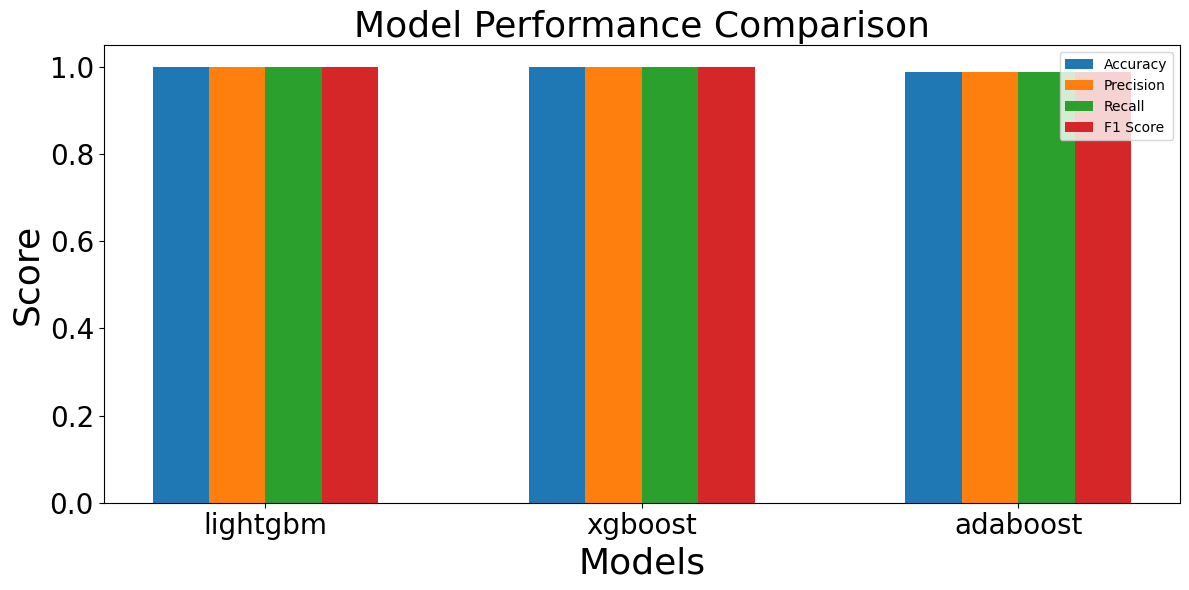

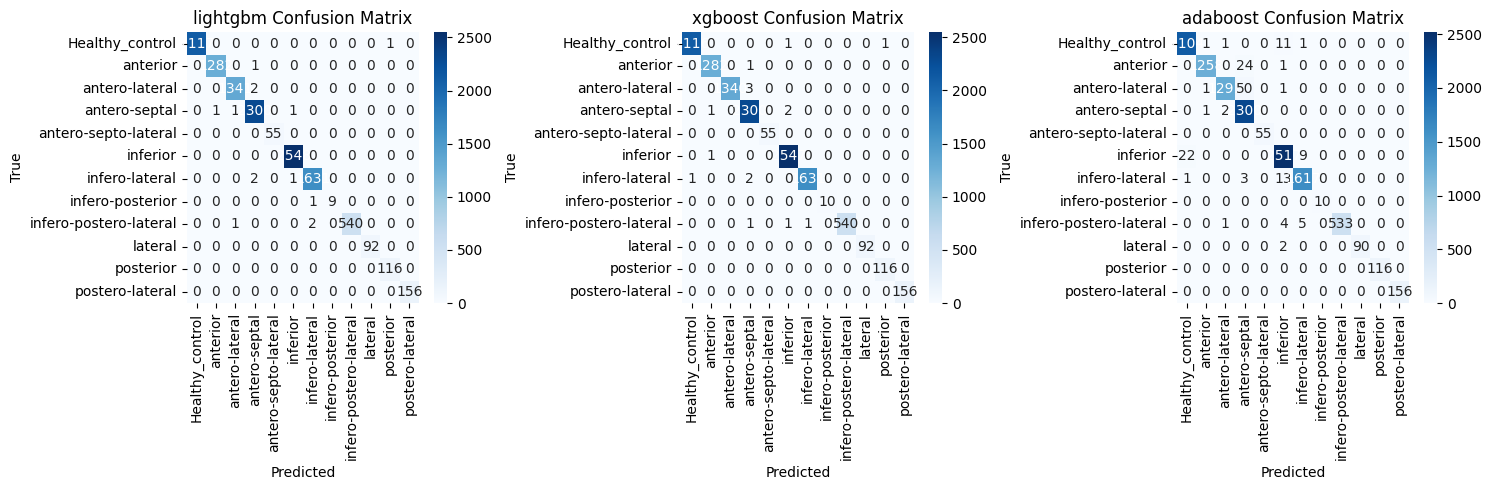

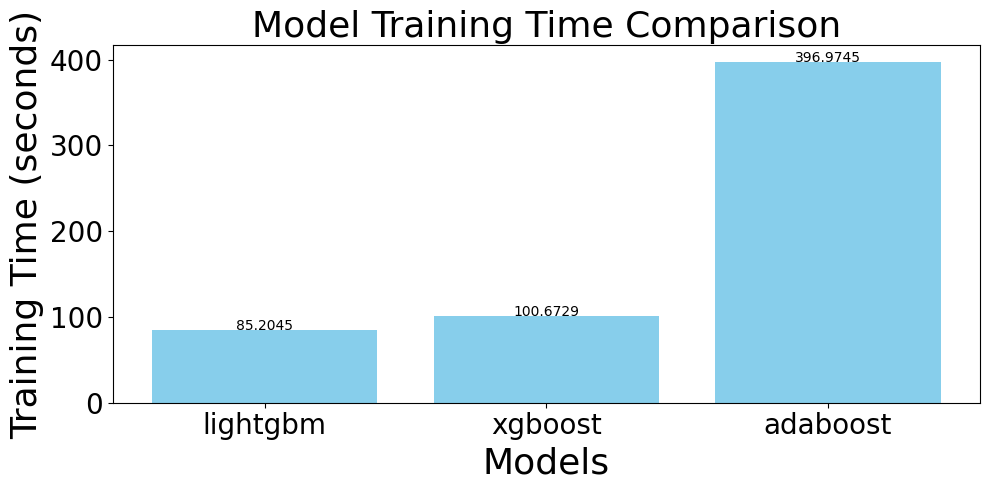


==== Class-wise Metrics for lightgbm ====
                     Class  Precision  Recall  F1-Score   Support
0          Healthy_control     1.0000  0.9995    0.9998 2118.0000
1                 anterior     0.9992  0.9992    0.9992 1283.0000
2           antero-lateral     0.9985  0.9985    0.9985 1343.0000
3            antero-septal     0.9978  0.9987    0.9983 2303.0000
4     antero-septo-lateral     1.0000  1.0000    1.0000   55.0000
5                 inferior     0.9992  1.0000    0.9996 2548.0000
6           infero-lateral     0.9982  0.9982    0.9982 1634.0000
7         infero-posterior     1.0000  0.9000    0.9474   10.0000
8   infero-postero-lateral     1.0000  0.9945    0.9972  543.0000
9                  lateral     1.0000  1.0000    1.0000   92.0000
10               posterior     0.9915  1.0000    0.9957  116.0000
11         postero-lateral     1.0000  1.0000    1.0000  156.0000

==== Class-wise Metrics for xgboost ====
                     Class  Precision  Recall  F1-Score  

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, roc_curve, auc
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import time

def ensemble_boosting_classification(df, selected_features=None):
    # Prepare data
    X = df.drop(columns=["segment_id", "label"])
    y = df["label"]

    # Handle missing values
    X = X.fillna(0)

    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded = train_test_split(
        X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    # Dictionary to store all results
    results = {
        'models': {},
        'predictions': {},
        'metrics': {},
        'cv_results': {} # This will store CV results for each model
    }

    # LightGBM Classification
    print("\n=== LightGBM Classification with 5-Fold Cross-Validation ===")
    lgb_model, lgb_metrics, lgb_cv_results = train_lightgbm_with_cv(X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, le)
    results['models']['lightgbm'] = lgb_model
    results['metrics']['lightgbm'] = lgb_metrics
    results['cv_results']['lightgbm'] = lgb_cv_results # Store LightGBM CV results

    # XGBoost Classification
    print("\n=== XGBoost Classification with 5-Fold Cross-Validation ===")
    xgb_model, xgb_metrics, xgb_cv_results = train_xgboost_with_cv(X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, le)
    results['models']['xgboost'] = xgb_model
    results['metrics']['xgboost'] = xgb_metrics
    results['cv_results']['xgboost'] = xgb_cv_results # Store XGBoost CV results

    # AdaBoost Classification
    print("\n=== AdaBoost Classification with 5-Fold Cross-Validation ===")
    ada_model, ada_metrics, ada_cv_results = train_adaboost_with_cv(X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, le)
    results['models']['adaboost'] = ada_model
    results['metrics']['adaboost'] = ada_metrics
    results['cv_results']['adaboost'] = ada_cv_results # Store AdaBoost CV results

    # Compare models
    compare_models(results['metrics'], le)
    return results

def train_lightgbm_with_cv(X_train, y_train, X_test, y_test, label_encoder):
    """Train and evaluate LightGBM model with 5-fold cross-validation."""
    num_classes = len(np.unique(y_train))
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    lgb_params = {
        'objective': 'multiclass',
        'num_class': num_classes,
        'metric': 'multi_logloss',
        'verbose': -1,
        # Tuned hyperparameters
        'learning_rate': 0.05,
        'num_leaves': 50,
        'max_depth': 7,
        'min_child_samples': 10,
        'subsample': 0.9,
        'colsample_bytree': 0.7,
        'reg_alpha': 0,
        'reg_lambda': 0,
        'random_state': 42,  # For reproducibility
        'force_col_wise': True  # For better performance
    }

    cv_results = {
        'accuracy': [], 'precision': [], 'recall': [], 'f1': [],
        'conf_matrices': [], 'fold_models': [],
        'fold_predictions': [], 'fold_probabilities': [],
        'y_true': [], 'y_pred': [], 'class_reports': [],
    }

    print("\nPerforming 5-fold cross-validation on training data (LightGBM):")
    fold_num = 1
    best_accuracy = -1
    best_fold_model = None # This will store the *best* model from CV (not used for final metrics, but good practice)
    overall_start_time = time.time() # Track total time for training

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        train_data = lgb.Dataset(X_fold_train, label=y_fold_train)
        valid_data = lgb.Dataset(X_fold_val, label=y_fold_val, reference=train_data)

        fold_model = lgb.train(
            lgb_params,
            train_data,
            num_boost_round=300,  # number of boosting iterations
            valid_sets=[train_data, valid_data],
            valid_names=['training', 'validation'],
        )

        y_val_prob = fold_model.predict(X_fold_val)  # Shape: (n_samples, n_classes)
        y_pred = np.argmax(y_val_prob, axis=1)

        accuracy = accuracy_score(y_fold_val, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_fold_val, y_pred, average='weighted', zero_division=0)
        cm = confusion_matrix(y_fold_val, y_pred)
        class_report = classification_report(y_fold_val, y_pred, output_dict=True, zero_division=0)

        cv_results['accuracy'].append(accuracy)
        cv_results['precision'].append(precision)
        cv_results['recall'].append(recall)
        cv_results['f1'].append(f1)
        cv_results['conf_matrices'].append(cm)
        cv_results['fold_models'].append(fold_model) # Store the LGBMClassifier instance
        cv_results['fold_predictions'].append(y_pred)
        cv_results['fold_probabilities'].append(y_val_prob)
        cv_results['y_true'].append(y_fold_val)
        cv_results['y_pred'].append(y_pred)
        cv_results['class_reports'].append(class_report)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_fold_model = fold_model # Store the best performing model (though not strictly used for final eval, good for debugging)
        
        print(f"Fold {fold_num}: Val Acc={accuracy:.4f}, Prec={precision:.4f}, Rec={recall:.4f}, F1={f1:.4f}")
        fold_num += 1

    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        mean_val = np.mean(cv_results[metric])
        std_val = np.std(cv_results[metric])
        print(f"Mean {metric}: {mean_val:.4f} (±{std_val:.4f})")

    #  Use the best fold model for final evaluation
    print(f"\nBest model found in fold {best_fold_model} with validation accuracy of {best_accuracy:.4f}")
    final_model = best_fold_model  # Menggunakan booster langsung

    test_prob = final_model.predict(X_test)  # Booster.predict mengembalikan probabilitas
    test_pred = np.argmax(test_prob, axis=1)  # Konversi ke kelas

    training_time = time.time() - overall_start_time
    metrics = evaluate_classifier(y_test, test_pred, test_prob, label_encoder, training_time)

    print(f"\nFinal LightGBM Training Time (including CV and final fit): {training_time:.4f} seconds")
    print("\nFinal model evaluation on HELD-OUT TEST SET (LightGBM):")
    print(classification_report(y_test, test_pred, target_names=label_encoder.classes_, digits=4, zero_division=0))

    return final_model, metrics, cv_results

def train_xgboost_with_cv(X_train, y_train, X_test, y_test, label_encoder):
    num_classes = len(np.unique(y_train))
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    xgb_params = {
        'objective': 'multi:softprob', # For multiclass probability output
        'num_class': num_classes,
        'eval_metric': 'mlogloss',
        'verbosity': 0, # Suppress verbose output

        # Optimized hyperparameters from tuning
        'learning_rate': 0.15,          # Learning rate (eta)
        'max_depth': 7,                 # Maximum depth of trees
        'min_child_weight': 1,          # Minimum sum of instance weight needed in a child
        'gamma': 0,                     # Minimum loss reduction required to make split
        'subsample': 0.8,               # Subsample ratio of the training instances
        'colsample_bytree': 0.8,        # Subsample ratio of columns when constructing each tree
        'reg_alpha': 0.01,              # L1 regularization term on weights
        'reg_lambda': 0.5,              # L2 regularization term on weights
        'scale_pos_weight': 1,          # Control the balance of positive and negative weights
        
        # Additional parameters for stability
        'random_state': 42,             # Random seed for reproducibility
        'tree_method': 'auto'           # Tree construction algorithm
    }

    cv_results = {
        'accuracy': [], 'precision': [], 'recall': [], 'f1': [],
        'conf_matrices': [], 'fold_models': [],
        'fold_predictions': [], 'fold_probabilities': [],
        'y_true': [], 'y_pred': [], 'class_reports': [],
    }

    print("\nPerforming 5-fold cross-validation on training data (XGBoost):")
    fold_num = 1
    best_accuracy = -1
    best_fold_model = None
    overall_start_time = time.time()

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        # # Use XGBClassifier for easier integration with sklearn's fit/predict interface
        # fold_model = xgb.XGBClassifier(**xgb_params)
        # fold_model.fit(X_fold_train, y_fold_train)
        dtrain = xgb.DMatrix(X_fold_train, label=y_fold_train)
        dval = xgb.DMatrix(X_fold_val, label=y_fold_val)
        evallist = [(dtrain, 'train'), (dval, 'eval')]

        fold_model = xgb.train(
            xgb_params,
            dtrain,
            num_boost_round=300,  # number of boosting rounds
            evals=evallist,
            verbose_eval=False    # Suppress training output
        )

        val_pred_prob = fold_model.predict(dval)
        val_pred = np.argmax(val_pred_prob, axis=1)

        accuracy = accuracy_score(y_fold_val, val_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_fold_val, val_pred, average='weighted', zero_division=0)
        cm = confusion_matrix(y_fold_val, val_pred)
        class_report = classification_report(y_fold_val, val_pred, output_dict=True, zero_division=0)

        cv_results['accuracy'].append(accuracy)
        cv_results['precision'].append(precision)
        cv_results['recall'].append(recall)
        cv_results['f1'].append(f1)
        cv_results['conf_matrices'].append(cm)
        cv_results['fold_models'].append(fold_model)
        cv_results['fold_predictions'].append(val_pred)
        cv_results['fold_probabilities'].append(val_pred_prob)
        cv_results['y_true'].append(y_fold_val)
        cv_results['y_pred'].append(val_pred)
        cv_results['class_reports'].append(class_report)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_fold_model = fold_model

        print(f"Fold {fold_num}: Val Acc={accuracy:.4f}, Prec={precision:.4f}, Rec={recall:.4f}, F1={f1:.4f}")
        fold_num += 1

    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        mean_val = np.mean(cv_results[metric])
        std_val = np.std(cv_results[metric])
        print(f"Mean {metric}: {mean_val:.4f} (±{std_val:.4f})")

    # Train final model on the ENTIRE training data
    print(f"\nBest model found with validation accuracy of {best_accuracy:.4f}")
    final_model = best_fold_model

    # Evaluate this final_model_on_full_train on the independent TEST data
    dtest = xgb.DMatrix(X_test)
    test_prob = final_model.predict(dtest)
    test_pred = np.argmax(test_prob, axis=1)

    training_time = time.time() - overall_start_time
    metrics = evaluate_classifier(y_test, test_pred, test_prob, label_encoder, training_time)

    print(f"\nFinal XGBoost Training Time (including CV and final fit): {training_time:.4f} seconds")
    print("\nFinal model evaluation on HELD-OUT TEST SET (XGBoost):")
    print(classification_report(y_test, test_pred, target_names=label_encoder.classes_, digits=4, zero_division=0))

    return final_model, metrics, cv_results

def train_adaboost_with_cv(X_train, y_train, X_test, y_test, label_encoder):
    num_classes = len(np.unique(y_train))
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    base_estimator = DecisionTreeClassifier(
        max_depth=5,                    # estimator__max_depth: 5
        min_samples_split=5,           # estimator__min_samples_split: 5
        min_samples_leaf=1,            # estimator__min_samples_leaf: 1
        max_features='sqrt',           # estimator__max_features: 'sqrt'
        random_state=42
        )
    ada_params = {
        'estimator': base_estimator,
        'n_estimators': 300,           # n_estimators: 300 (increased from 100)
        'learning_rate': 0.1,          # learning_rate: 0.1 (added learning rate)
        'algorithm': 'SAMME',          # algorithm: 'SAMME' (forced to SAMME)
        'random_state': 42
    }

    cv_results = {
        'accuracy': [], 'precision': [], 'recall': [], 'f1': [],
        'conf_matrices': [], 'fold_models': [],
        'fold_predictions': [], 'fold_probabilities': [],
        'y_true': [], 'y_pred': [], 'class_reports': [],
    }

    print("\nPerforming 5-fold cross-validation on training data (AdaBoost):")
    fold_num = 1
    best_accuracy = -1
    best_fold_model = None
    overall_start_time = time.time()

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        fold_model = AdaBoostClassifier(**ada_params)
        fold_model.fit(X_fold_train, y_fold_train)

        y_pred = fold_model.predict(X_fold_val)

        # Get probabilities for validation set
        if hasattr(fold_model, "predict_proba"):
            y_val_prob = fold_model.predict_proba(X_fold_val)
        else:
            # Fallback if predict_proba is not available (e.g., if algorithm is 'SAMME' which doesn't guarantee prob output)
            decision_scores = fold_model.decision_function(X_fold_val)
            if num_classes == 2:
                # For binary, decision_function is 1D. Apply sigmoid.
                y_val_prob = np.column_stack([1 - 1/(1 + np.exp(-decision_scores)),
                                             1/(1 + np.exp(-decision_scores))])
            else:
                # For multiclass, decision_function returns raw scores per class. Apply softmax.
                exp_scores = np.exp(decision_scores)
                y_val_prob = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)


        accuracy = accuracy_score(y_fold_val, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_fold_val, y_pred, average='weighted', zero_division=0)
        cm = confusion_matrix(y_fold_val, y_pred)
        class_report = classification_report(y_fold_val, y_pred, output_dict=True, zero_division=0)

        cv_results['accuracy'].append(accuracy)
        cv_results['precision'].append(precision)
        cv_results['recall'].append(recall)
        cv_results['f1'].append(f1)
        cv_results['conf_matrices'].append(cm)
        cv_results['fold_models'].append(fold_model)
        cv_results['fold_predictions'].append(y_pred)
        cv_results['fold_probabilities'].append(y_val_prob)
        cv_results['y_true'].append(y_fold_val)
        cv_results['y_pred'].append(y_pred)
        cv_results['class_reports'].append(class_report)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_fold_model = fold_model

        print(f"Fold {fold_num}: Val Acc={accuracy:.4f}, Prec={precision:.4f}, Rec={recall:.4f}, F1={f1:.4f}")
        fold_num += 1

    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        mean_val = np.mean(cv_results[metric])
        std_val = np.std(cv_results[metric])
        print(f"Mean {metric}: {mean_val:.4f} (±{std_val:.4f})")

    # Train final model on the ENTIRE training data
    final_model_on_full_train = AdaBoostClassifier(**ada_params)
    final_model_on_full_train.fit(X_train, y_train)

    # Evaluate this final_model_on_full_train on the independent TEST data
    test_pred = final_model_on_full_train.predict(X_test)
    if hasattr(final_model_on_full_train, "predict_proba"):
        test_prob = final_model_on_full_train.predict_proba(X_test)
    else:
        # Fallback if predict_proba is not directly available (e.g. if AdaBoost algo is 'SAMME')
        decision_scores = final_model_on_full_train.decision_function(X_test)
        if num_classes == 2:
            test_prob = np.column_stack([1 - 1/(1 + np.exp(-decision_scores)),
                                         1/(1 + np.exp(-decision_scores))])
        else:
            exp_scores = np.exp(decision_scores)
            test_prob = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    training_time = time.time() - overall_start_time
    metrics = evaluate_classifier(y_test, test_pred, test_prob, label_encoder, training_time)

    print(f"\nFinal AdaBoost Training Time (including CV and final fit): {training_time:.4f} seconds")
    print("\nFinal model evaluation on HELD-OUT TEST SET (AdaBoost):")
    print(classification_report(y_test, test_pred, target_names=label_encoder.classes_, digits=4, zero_division=0))

    return final_model_on_full_train, metrics, cv_results

def evaluate_classifier(y_true, y_pred, y_prob, label_encoder, training_time=None):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    cm = confusion_matrix(y_true, y_pred)

    n_classes = len(label_encoder.classes_)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    macro_roc_auc = auc(all_fpr, mean_tpr)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'macro_roc_auc': macro_roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'all_fpr': all_fpr,
        'mean_tpr': mean_tpr,
        'training_time': training_time,
        'class_report': classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)
    }

    return metrics

def compare_models(metrics_dict, label_encoder):
    models = list(metrics_dict.keys())

    # 1. Compare basic metrics
    accuracies = [metrics_dict[model]['accuracy'] for model in models]
    precisions = [metrics_dict[model]['precision'] for model in models]
    recalls = [metrics_dict[model]['recall'] for model in models]
    f1s = [metrics_dict[model]['f1'] for model in models]

    plt.figure(figsize=(12, 6))
    x = np.arange(len(models))
    width = 0.15

    # Adjusting bar positions for 4 bars
    plt.bar(x - width*1.5, accuracies, width, label='Accuracy')
    plt.bar(x - width/2, precisions, width, label='Precision')
    plt.bar(x + width/2, recalls, width, label='Recall')
    plt.bar(x + width*1.5, f1s, width, label='F1 Score')

    plt.xlabel('Models', fontsize=26)
    plt.ylabel('Score', fontsize=26)
    plt.title('Model Performance Comparison', fontsize=26)
    plt.xticks(x, models)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.legend()
    plt.tight_layout()
    plt.savefig('model_comparison_Tuned.png')
    plt.show()
    # plt.close() # Close figure to free up memory

    # 2. Plot confusion matrices
    plt.figure(figsize=(5 * len(models), 5)) # Adjust figure size dynamically
    for i, model in enumerate(models):
        plt.subplot(1, len(models), i+1)
        cm = metrics_dict[model]['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=label_encoder.classes_,
                    yticklabels=label_encoder.classes_)
        plt.title(f'{model} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
    plt.tight_layout()
    plt.savefig('confusion_matrices_Tuned.png')
    plt.show()
    # plt.close()


    # 3. Training time comparison
    if all('training_time' in metrics_dict[model] for model in models):
        training_times = [metrics_dict[model]['training_time'] for model in models]

        plt.figure(figsize=(10, 5))
        plt.bar(models, training_times, color='skyblue')
        plt.xlabel('Models', fontsize=26)
        plt.ylabel('Training Time (seconds)', fontsize=26)
        plt.title('Model Training Time Comparison', fontsize=26)
        plt.tick_params(axis='both', which='major', labelsize=20)

        for i, v in enumerate(training_times):
            plt.text(i, v + 0.1, f"{v:.4f}", ha='center')

        plt.tight_layout()
        plt.savefig('training_times_Tuned.png')
        plt.show()
        # plt.close()

    # Display class-wise metrics in a table for each model
    for model in models:
        if 'class_report' in metrics_dict[model]:
            print(f"\n==== Class-wise Metrics for {model} ====")
            class_report = metrics_dict[model]['class_report']

            classes = [c for c in class_report if c not in ['accuracy', 'macro avg', 'weighted avg']]
            metrics_df = pd.DataFrame({
                'Class': classes,
                'Precision': [class_report[c]['precision'] for c in classes],
                'Recall': [class_report[c]['recall'] for c in classes],
                'F1-Score': [class_report[c]['f1-score'] for c in classes],
                'Support': [class_report[c]['support'] for c in classes]
            })

            pd.set_option('display.float_format', '{:.4f}'.format)
            print(metrics_df)

# Main execution
if __name__ == "__main__":
    # Load data
    file_path = r'D:\TA_baru\dataset\all_label_extracted_features.xlsx'
    try:
        df = pd.read_excel(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        print("Please ensure the 'extracted_features.xlsx' file is in the specified path.")
        exit()

    selected_features = None

    results = ensemble_boosting_classification(df, selected_features)